<a href="https://colab.research.google.com/github/JulioLaz/store_sales_analysis_sqlite/blob/develop/Store_Sales_Analysis_SQL_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**PROBLEMA DE NEGOCIO**


---




##Una tienda online de moda, con presencia en todo Brasil, necesita impulsar su rendimiento utilizando sus datos de manera estratégica. Como científico de datos, has sido convocado para analizar estos datos y ofrecer insights que guíen sus decisiones y respondan a las siguientes preguntas clave:

### **Preguntas**

1. ¿Cual es el Top 5 productos más vendidos históricamente?

2. ¿Cual es la evolución histórica de las ingresos netos?

3. ¿Cuáles son los ingresos netos por vendedor por año?

4. ¿Cuáles son las ciudades que proporcionan mayores ingresos netos?

5. ¿Existe otro insight que puedas proporcionar?

#**1. Configuración del Ambiente**


---




In [1]:
# !python -V
# print('------')
# !pip show Pandas | grep 'Name\|Version'
# print('------')
# !pip show Matplotlib | grep 'Name\|Version'

          # Python 3.10.12
          # ------
          # Name: pandas
          # Version: 2.0.3
          # ------
          # Name: matplotlib
          # Version: 3.7.1

In [2]:
!pip install geobr
import geobr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import FancyBboxPatch
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as ticker
import requests
from io import BytesIO
from sqlalchemy import create_engine, MetaData, Table, inspect, text
import urllib.request

global df_itens_pedidos, df_pedidos, df_productos, df_vendedores, database

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 39.2 MB/s eta 0:00:00
  Attempting uninstall: shapely
    Found existing installation: shapely 2.0.4
    Uninstalling shapely-2.0.4:
      Successfully uninstalled shapely-2.0.4
  Attempting uninstall: lxml
    Found existing installation: lxml 4.9.4
    Uninstalling lxml-4.9.4:
      Successfully uninstalled lxml-4.9.4
  Attempting uninstall: geopandas
    Found existing installation: geopandas 0.13.2
    Uninstalling geopandas-0.13.2:
      Successfully uninstalled geopandas-0.13.2


In [3]:
# Configurar pandas para mostrar todas las columnas
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_row', None)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**2. Obtención, Tratamiento y Análisis Exploratório (EDA)**


---




##**2.1 Cargando las bases de datos**

In [5]:
df_itens_pedidos = pd.read_csv('https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/itens_pedidos.csv')
df_itens_pedidos.head()

id_recibo  producto_id  pedido_id  cantidad  valor_unitario  valor_total  \
0          1        41518        341         3             260          780   
1          2         4307       1174         5            6175        30875   
2          3        22407       1399         3             200          600   
3          4         3820       1652         6             139          834   
4          5        29012       2470         3             525         1575   

  ciudad  costo_envio  
0  BR-BA        156.0  
1  BR-RJ       6175.0  
2  BR-PB        120.0  
3  BR-DF        166.8  
4  BR-BA        315.0

In [6]:
df_pedidos = pd.read_csv('https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/pedidos.csv')
df_pedidos.head()

pedido_id  producto_id  vendedor_id fecha_compra  total
0        341        41518            6   2019-01-05    780
1       1174         4307            3   2019-01-05  30875
2       1399        22407            1   2019-01-05    600
3       1652         3820            4   2019-01-05    834
4       2470        29012            2   2019-01-05   1575

In [7]:
df_productos = pd.read_csv('https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/productos.csv')
df_productos.head()

producto_id                 producto  precio                marca  \
0        21244     Oculos Lente Azulada    1120  D&g Dolce & Gabbana   
1         9981         Bolsa Coral Saco    4000             Givenchy   
2        84176      Camisa Xadrez Verde     310            Joe Fresh   
3        47475  Calca Alfaiataria Preta     490                Mixed   
4        74864    Vestido Jeans Babados     130                 Zara   

        sku condicion  
0  209297.0     Usado  
1  278612.0     Usado  
2  322482.0     Usado  
3  263658.0     Usado  
4  219248.0     Usado

In [8]:
df_vendedores = pd.read_csv('https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/vendedores.csv')
df_vendedores

vendedor_id  nombre_vendedor
0            1       Ana Duarte
1            2  Daniel Siqueira
2            3   Nadia Oliveira
3            4  Millena Pereira
4            5    Paulo Calanca
5            6          Unknown

In [9]:
###  GUARDAR DDBB EN DRIVE  ###

# df_vendedores.to_csv('/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/DDBB/vendedores.csv', index=False)
# df_itens_pedidos.to_csv('/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/DDBB/itens_pedidos.csv', index=False)
# df_pedidos.to_csv('/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/DDBB/pedidos.csv', index=False)
# df_productos.to_csv('/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/DDBB/productos.csv', index=False)

###**Apicando unique a cada df:**

In [10]:
dfs = [df_itens_pedidos, df_pedidos, df_productos, df_vendedores]

for df in dfs:
    print('Cantidad de valores únicos de:')
    print('-------------------------------')
    for n in df.columns:
        print(f'{n}: {len(df[n].unique())}')

Cantidad de valores únicos de:
-------------------------------
id_recibo: 24527
producto_id: 205
pedido_id: 24527
cantidad: 6
valor_unitario: 85
valor_total: 354
ciudad: 27
costo_envio: 354
Cantidad de valores únicos de:
-------------------------------
pedido_id: 24527
producto_id: 205
vendedor_id: 6
fecha_compra: 780
total: 354
Cantidad de valores únicos de:
-------------------------------
producto_id: 207
producto: 202
precio: 85
marca: 117
sku: 206
condicion: 3
Cantidad de valores únicos de:
-------------------------------
vendedor_id: 6
nombre_vendedor: 6


###**Apicando info a cada df:**

In [11]:
dfs=[df_itens_pedidos,df_pedidos,df_productos,df_vendedores]

def info_df(dfs):
    for df in dfs:
        df_name = [name for name, obj in globals().items() if obj is df][0]
        print("Nombre del DataFrame:", df_name)
        print(df.info())
        print('-------------------------------------------')

info_df(dfs)

Nombre del DataFrame: df_itens_pedidos
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_recibo       24527 non-null  int64  
 1   producto_id     24527 non-null  int64  
 2   pedido_id       24527 non-null  int64  
 3   cantidad        24527 non-null  int64  
 4   valor_unitario  24527 non-null  int64  
 5   valor_total     24527 non-null  int64  
 6   ciudad          24527 non-null  object 
 7   costo_envio     24527 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 1.5+ MB
None
-------------------------------------------
Nombre del DataFrame: df_pedidos
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   pedido_id     24527 non-null  int64 
 1   producto_id   24527 

##**2.2 Tratamiento de Datos**

In [12]:
df_productos[df_productos.producto.isna()]

producto_id producto  precio                marca  sku  \
205        41598      NaN     260      Banana Republic  NaN   
206        32926      NaN     210  Limone By Jade Seba  NaN   

              condicion  
205  Nuevo con etiqueta  
206  Nuevo sin etiqueta

###**"Los productos que tienen valores faltantes (NaN) y no tienen un código de stock (SKU) válido serán eliminados, ya que están fuera de control".**

### Daclaración de la función preprocesamiento:

In [13]:
def preprocesamiento():
    global df_itens_pedidos, df_pedidos, df_productos, df_vendedores

    # Eliminar registros con valores nulos en columnas primary o foreign key
    df_itens_pedidos.dropna(subset=['pedido_id', 'producto_id'], inplace=True)
    df_pedidos.dropna(subset=['pedido_id', 'producto_id', 'vendedor_id'], inplace=True)
    df_productos.dropna(subset=['producto_id','producto'], inplace=True)### Elimino también los NaN de producto
    df_vendedores.dropna(subset=['vendedor_id'], inplace=True)

    #eliminar la fila con Vendedor='Unknown':
    df_vendedores = df_vendedores[df_vendedores['nombre_vendedor'] != 'Unknown']

    # Eliminar registros duplicados
    df_itens_pedidos.drop_duplicates(inplace=True)
    df_pedidos.drop_duplicates(inplace=True)
    df_productos.drop_duplicates(inplace=True)
    df_vendedores.drop_duplicates(inplace=True)

    # Asegurar tipos de datos correctos:
    df_itens_pedidos['id_recibo'] = df_itens_pedidos['id_recibo'].astype(int)
    df_itens_pedidos['producto_id'] = df_itens_pedidos['producto_id'].astype(int)
    df_itens_pedidos['pedido_id'] = df_itens_pedidos['pedido_id'].astype(int)
    df_itens_pedidos['ciudad'] = df_itens_pedidos['ciudad'].astype(str)
    df_itens_pedidos['costo_envio'] = df_itens_pedidos['costo_envio'].astype(float)

    df_pedidos['pedido_id'] = df_pedidos['pedido_id'].astype(int)
    df_pedidos['producto_id'] = df_pedidos['producto_id'].astype(int)
    df_pedidos['vendedor_id'] = df_pedidos['vendedor_id'].astype(int)
    df_pedidos['fecha_compra'] = pd.to_datetime(df_pedidos['fecha_compra'])

    df_productos['producto_id'] = df_productos['producto_id'].astype(int)
    df_productos['precio'] = df_productos['precio'].astype(float)
    df_productos['sku'] = df_productos['sku'].astype(str)

    df_vendedores['vendedor_id'] = df_vendedores['vendedor_id'].astype(int)
    df_vendedores['nombre_vendedor'] = df_vendedores['nombre_vendedor'].astype(str)

    return df_itens_pedidos, df_pedidos, df_productos, df_vendedores

df_itens_pedidos, df_pedidos, df_productos, df_vendedores = preprocesamiento()

<ipython-input-13-fd4c1633cc1b>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vendedores.drop_duplicates(inplace=True)
<ipython-input-13-fd4c1633cc1b>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vendedores['vendedor_id'] = df_vendedores['vendedor_id'].astype(int)
<ipython-input-13-fd4c1633cc1b>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

### Verificar DDBB:

In [14]:
dfs=[df_itens_pedidos,df_pedidos,df_productos,df_vendedores]
info_df(dfs)

Nombre del DataFrame: df_itens_pedidos
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_recibo       24527 non-null  int64  
 1   producto_id     24527 non-null  int64  
 2   pedido_id       24527 non-null  int64  
 3   cantidad        24527 non-null  int64  
 4   valor_unitario  24527 non-null  int64  
 5   valor_total     24527 non-null  int64  
 6   ciudad          24527 non-null  object 
 7   costo_envio     24527 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 1.5+ MB
None
-------------------------------------------
Nombre del DataFrame: df_pedidos
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   pedido_id     24527 non-null  int64         
 

###**Preprocesamiento realizado con éxito!**

##**2.3 Análisis Exploratorio (EDA)**

### Ver DDBB: Decribe

In [15]:
def describe_dfs_all(dfs):
  for df in dfs:
    df_name = [name for name, obj in globals().items() if obj is df][0]
    print("Nombre del DataFrame:", df_name)
    print(df.describe().round(1))
    print('--------------------------------------------------------------------------------------')

In [16]:
dfs = [df_itens_pedidos, df_pedidos, df_productos, df_vendedores]
describe_dfs_all(dfs)

Nombre del DataFrame: df_itens_pedidos
       id_recibo  producto_id  pedido_id  cantidad  valor_unitario  \
count    24527.0      24527.0    24527.0   24527.0         24527.0   
mean     12405.4      44627.6    69931.4       3.5           535.7   
std       7242.7      29347.8    40560.8       1.7           839.2   
min          1.0       2706.0        1.0       1.0            45.0   
25%       6132.5      17258.0    34487.0       2.0           210.0   
50%      12264.0      42913.0    69945.0       4.0           336.0   
75%      18689.5      70673.0   105355.0       5.0           450.0   
max      25055.0     100983.0   139993.0       6.0          6500.0   

       valor_total  costo_envio  
count      24527.0      24527.0  
mean        1867.5        373.5  
std         3379.7        675.9  
min           45.0          9.0  
25%          520.0        104.0  
50%         1050.0        210.0  
75%         1920.0        384.0  
max        39000.0       7800.0  
------------------------

In [17]:
def describe_dfs(dfs):
    for df in dfs:
        df_name = [name for name, obj in globals().items() if obj is df][0]
        print("Nombre del DataFrame:", df_name)
        non_id_columns = [col for col in df.columns if 'id' not in col.lower()]
        if non_id_columns:
            print(df[non_id_columns].describe().round(1))
        else:
            print("No hay columnas para describir, todas son identificadores.")
        print('-------------------------------------------')

In [18]:
dfs = [df_itens_pedidos, df_pedidos, df_productos, df_vendedores]
describe_dfs(dfs)

Nombre del DataFrame: df_itens_pedidos
       valor_unitario  valor_total  costo_envio
count         24527.0      24527.0      24527.0
mean            535.7       1867.5        373.5
std             839.2       3379.7        675.9
min              45.0         45.0          9.0
25%             210.0        520.0        104.0
50%             336.0       1050.0        210.0
75%             450.0       1920.0        384.0
max            6500.0      39000.0       7800.0
-------------------------------------------
Nombre del DataFrame: df_pedidos
                        fecha_compra    total
count                          24527  24527.0
mean   2020-04-02 12:10:46.406001664   1867.5
min              2019-01-05 00:00:00     45.0
25%              2019-11-12 00:00:00    520.0
50%              2020-04-09 00:00:00   1050.0
75%              2020-09-21 00:00:00   1920.0
max              2021-03-10 00:00:00  39000.0
std                              NaN   3379.7
--------------------------------------

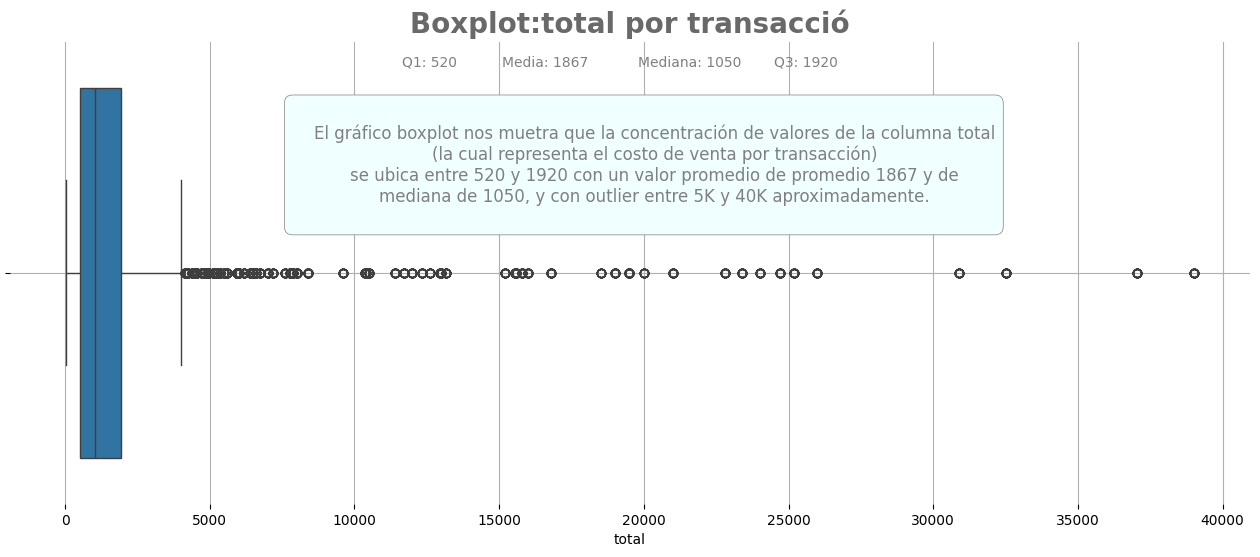

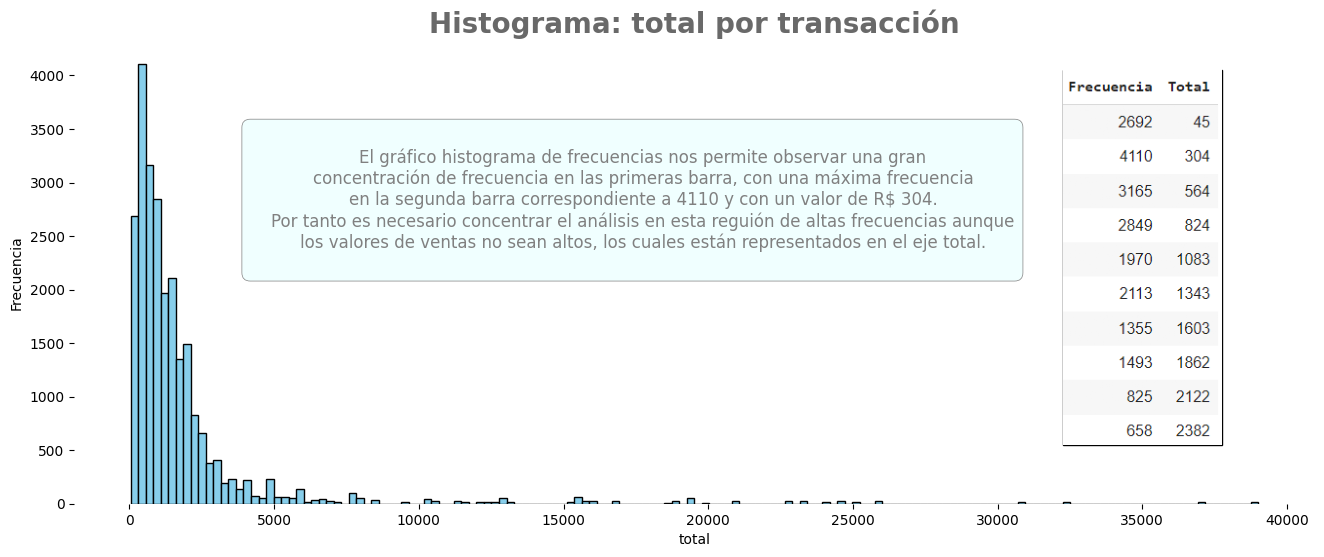

In [19]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def Boxplot_Histograma_graf(df, col):
    global df_histograma
    plt.figure(figsize=(16, 6))
    sns.boxplot(data=df, x=col)
    plt.title(f'Boxplot:{col} por transacció',fontsize=20,color='dimgray', fontweight= 'bold')

    # Calcular estadísticos descriptivos
    quartiles = df[col].quantile([0.25, 0.75])
    mean = df[col].mean()

    # Agregar anotaciones
    plt.text(12600, -.44, f'Q1: {quartiles[0.25]:.0f}', ha='center', va='bottom', color='gray')
    plt.text(16600, -.44, f'Media: {mean:.0f}', ha='center', va='bottom', color='gray')
    plt.text(21600, -.44, f'Mediana: {df[col].median():.0f}', ha='center', va='bottom', color='gray')
    plt.text(25600, -.44, f'Q3: {quartiles[0.75]:.0f}', ha='center', va='bottom', color='gray')

    plt.xlabel(col)
    plt.ylabel('')
    plt.grid(None)
    plt.box(None)
    text_boxplot = f'''
    El gráfico boxplot nos muetra que la concentración de valores de la columna total
    (la cual representa el costo de venta por transacción)
    se ubica entre {quartiles[0.25]:.0f} y {quartiles[0.75]:.0f} con un valor promedio de promedio {mean:.0f} y de
    mediana de {df[col].median():.0f}, y con outlier entre 5K y 40K aproximadamente.
    '''
    # plt.text(2e4, -0.1, text_boxplot, ha='center', va='bottom', color='black')
    plt.annotate(text_boxplot, xy=(2e4, -0.1), xytext=(0, 0), textcoords='offset points',
             ha='center', va='bottom',bbox=dict(boxstyle='round,pad=.5', fc='azure', ec='gray', lw=.5), fontsize=12, color='grey')
    plt.show()

    plt.figure(figsize=(16, 6))
    freq, bins, _ = plt.hist(df[col], bins=150, color='skyblue', edgecolor='black')
    df_histograma = pd.DataFrame({'Frecuencia': freq, 'Total': bins[:-1]}).head(10)

    plt.title(f'Histograma: {col} por transacción',fontsize=20,color='dimgray', fontweight= 'bold')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    text_histograma = f'''
    El gráfico histograma de frecuencias nos permite observar una gran
    concentración de frecuencia en las primeras barra, con una máxima frecuencia
    en la segunda barra correspondiente a {int(df_histograma.Frecuencia.iloc[1])} y con un valor de R$ {int(df_histograma.Total.iloc[1])}.
    Por tanto es necesario concentrar el análisis en esta reguión de altas frecuencias aunque
    los valores de ventas no sean altos, los cuales están representados en el eje total.
    '''
    # plt.text(17e3, 2500, text_histograma, ha='center', va='bottom', color='black')
    plt.annotate(text_histograma, xy=(0.45, 0.5), xycoords='axes fraction', ha='center', va='bottom',
             bbox=dict(boxstyle='round,pad=.5', fc='azure', ec='gray', lw=.5), fontsize=12, color='grey')

    plt.box(None)
        # Mostrar la imagen
    img = '/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/img/tabla_histograma.png'
    img_ventas = OffsetImage(plt.imread(img), zoom=0.7)
    ab_ventas = AnnotationBbox(img_ventas, (35000, 2300), frameon=True, xycoords='data', boxcoords='data', pad=0, zorder=100)
    plt.gca().add_artist(ab_ventas)  # Ajusta las coordenadas según sea necesario
    plt.show()

Boxplot_Histograma_graf(df_pedidos, 'total')


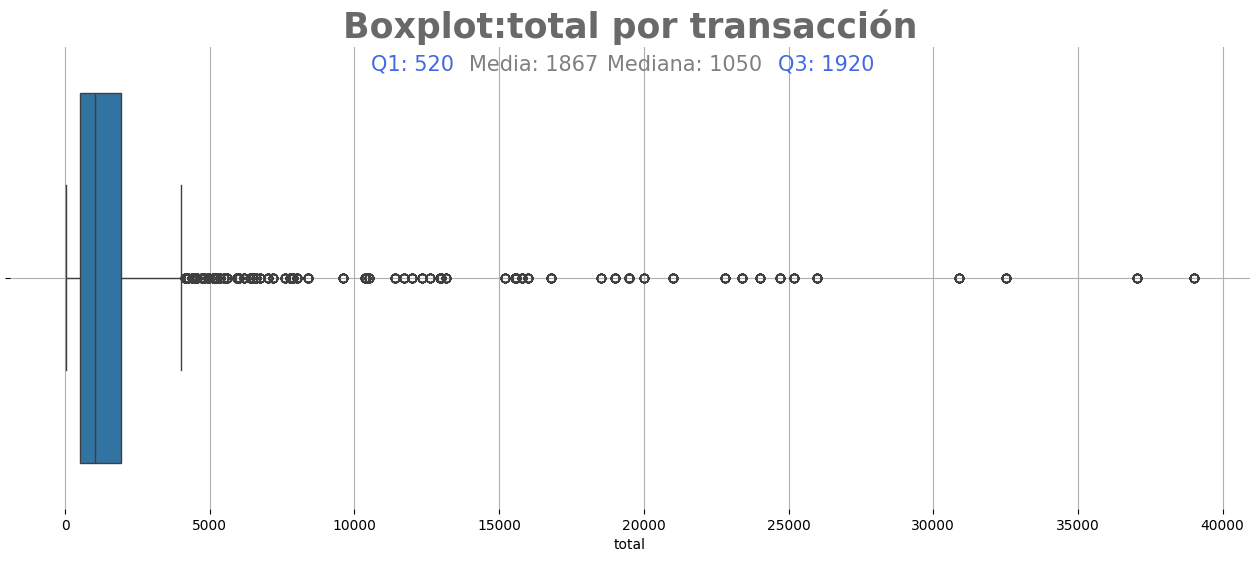


    El gráfico boxplot nos muetra que la concentración de valores de la columna total
    (la cual representa el costo de venta por transacción)
    se ubica entre 520 y 1920 con un valor promedio de promedio 1867 y de
    mediana de 1050, y con outlier entre 5K y 40K aproximadamente.
    


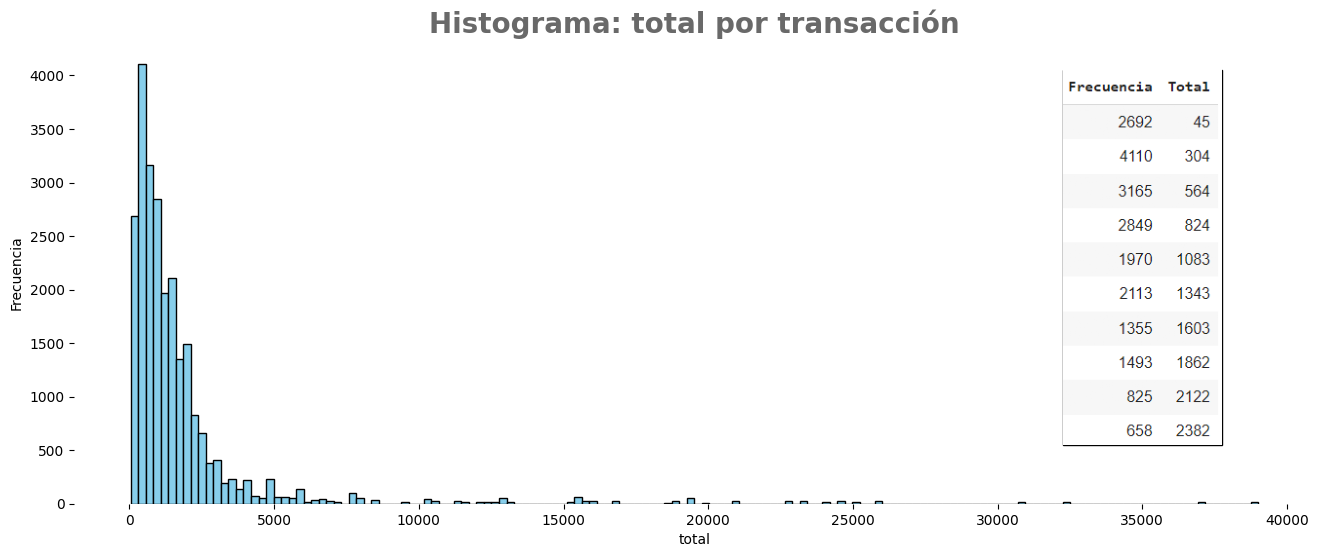


    El gráfico   histograma de frecuencias nos permite observar una gran
    concentración de frecuencia en las primeras barra, con una máxima frecuencia
    en la segunda barra correspondiente a 4110 y con un valor de R$ 304.
    Por tanto es necesario concentrar el análisis en esta reguión de altas frecuencias aunque
    los valores de ventas no sean altos, los cuales están representados en el eje total.
    


In [20]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def Boxplot_Histograma_graf(df, col):
    global df_histograma, text_histograma
    plt.figure(figsize=(16, 6),facecolor='none')
    sns.boxplot(data=df, x=col)
    plt.title(f'Boxplot:{col} por transacción',fontsize=25,color='dimgray', fontweight= 'bold')

    # Calcular estadísticos descriptivos
    quartiles = df[col].quantile([0.25, 0.75])
    mean = df[col].mean()

    # Agregar anotaciones
    plt.text(12000, -.44, f'Q1: {quartiles[0.25]:.0f}', ha='center', va='bottom', color='royalblue',fontsize=15)
    plt.text(16200, -.44, f'Media: {mean:.0f}', ha='center', va='bottom', color='gray',fontsize=15)
    plt.text(21400, -.44, f'Mediana: {df[col].median():.0f}', ha='center', va='bottom', color='gray',fontsize=15)
    plt.text(26300, -.44, f'Q3: {quartiles[0.75]:.0f}', ha='center', va='bottom', color='royalblue',fontsize=15)

    plt.xlabel(col)
    plt.ylabel('')
    plt.grid(None)
    plt.box(None)
    text_boxplot = f'''
    El gráfico boxplot nos muetra que la concentración de valores de la columna total
    (la cual representa el costo de venta por transacción)
    se ubica entre {quartiles[0.25]:.0f} y {quartiles[0.75]:.0f} con un valor promedio de promedio {mean:.0f} y de
    mediana de {df[col].median():.0f}, y con outlier entre 5K y 40K aproximadamente.
    '''
    # plt.text(2e4, -0.1, text_boxplot, ha='center', va='bottom', color='black')
    # plt.annotate(text_boxplot, xy=(2e4, -0.1), xytext=(0, 0), textcoords='offset points',
    #          ha='center', va='bottom',bbox=dict(boxstyle='round,pad=.5', fc='azure', ec='gray', lw=.5), fontsize=12, color='grey')
    plt.savefig('/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/graf/001_boxplot.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(text_boxplot)

    plt.figure(figsize=(16, 6),facecolor='none')
    freq, bins, _ = plt.hist(df[col], bins=150, color='skyblue', edgecolor='black')
    df_histograma = pd.DataFrame({'Frecuencia': freq, 'Total': bins[:-1]}).head(10)

    plt.title(f'Histograma: {col} por transacción',fontsize=20,color='dimgray', fontweight= 'bold')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    text_histograma = f'''
    El gráfico   histograma de frecuencias nos permite observar una gran
    concentración de frecuencia en las primeras barra, con una máxima frecuencia
    en la segunda barra correspondiente a {int(df_histograma.Frecuencia.iloc[1])} y con un valor de R$ {int(df_histograma.Total.iloc[1])}.
    Por tanto es necesario concentrar el análisis en esta reguión de altas frecuencias aunque
    los valores de ventas no sean altos, los cuales están representados en el eje total.
    '''
    # plt.text(17e3, 2500, text_histograma, ha='center', va='bottom', color='black')
    # plt.annotate(text_histograma, xy=(0.45, 0.5), xycoords='axes fraction', ha='center', va='bottom',
    #          bbox=dict(boxstyle='round,pad=.5', fc='azure', ec='gray', lw=.5), fontsize=12, color='grey')

    plt.box(None)
        # Mostrar la imagen
    img = '/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/img/tabla_histograma.png'
    img_ventas = OffsetImage(plt.imread(img), zoom=0.7)
    ab_ventas = AnnotationBbox(img_ventas, (35000, 2300), frameon=True, xycoords='data', boxcoords='data', pad=0, zorder=100)
    plt.gca().add_artist(ab_ventas)  # Ajusta las coordenadas según sea necesario
    plt.savefig('/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/graf/001_histograma.png', dpi=300, bbox_inches='tight')

    plt.show()
    print(text_histograma)
Boxplot_Histograma_graf(df_pedidos, 'total')


In [21]:
df_histograma.astype(int)

Frecuencia  Total
0        2692     45
1        4110    304
2        3165    564
3        2849    824
4        1970   1083
5        2113   1343
6        1355   1603
7        1493   1862
8         825   2122
9         658   2382

In [22]:
df_productos.condicion.value_counts()

condicion
Usado                 176
Nuevo con etiqueta     22
Nuevo sin etiqueta      7
Name: count, dtype: int64

###**Cantidad de tipos de productos por marca: top 10**

In [206]:
df_productos.groupby('marca')['producto'].value_counts()

marca    producto                    
284      Camiseta Animal Print           1
A.brand  Bota Veludo Azul                1
         Camisa Verde Classica           1
Adidas   Tenis Tecido Purple             1
Agilità  Calca Costuras Bege             1
                                        ..
Zara     Casaqueto Estampa Geometrica    1
         Saia Evase Cinza                1
         Shorts Estampa Floral           1
         Vestido Jeans Babados           1
         Vestido Preto Bolso             1
Name: count, Length: 204, dtype: int64

In [209]:
df_productos.marca.unique()

array(['D&g Dolce & Gabbana', 'Givenchy', 'Joe Fresh', 'Mixed', 'Zara',
       'Gap', 'Banana Republic', 'Fyi', 'Sacada', 'Rag & Bone', 'Cori',
       'Forever 21', 'Tigresse', 'Tory Burch', 'Brooksfield', 'Animale',
       '284', 'Dkny', 'Cheroy', 'Canal', 'Le Lis Blanc', 'Spezzato',
       'Cantão', 'Talie Nk', 'H&M', 'Schutz', 'Jorge Bischoff',
       'Luisa Farani', 'Seven', 'Kipling', 'Louis Vuitton', 'Agilità',
       'Fabiana Caterina', 'Reinaldo Lourenço', 'Karmani', 'Erre Erre',
       'H&m', 'Forum', 'Ellus', 'J. Crew', "Joe's", 'Galeria Tricot',
       'Loft 747', 'Oxyfit', 'Topshop', 'A.brand', 'Isolda',
       'American Eagle', 'Colcci', 'Carter’s', 'Thay Ribas',
       'Carina Duek', 'Kate Spade', 'Bottega Veneta', 'Morena Rosa',
       'Luiza Barcelos', 'Lezalez', 'My Place', 'Farm', 'Armani Exchange',
       'Bcbgmaxzria', 'Dica da Ka', 'My Shoes', 'Argentum',
       'Red Valentino', 'Maria Filó', 'Marc By Marcjacobs',
       'Track & Field', 'Christian Dior', 'Toca do 

In [204]:
marca_counts = df_productos['marca'].value_counts()
marca_counts_gt2 = marca_counts[marca_counts]
marca_counts_gt2=marca_counts_gt2.reset_index()
marca_counts_gt2

marca  count
0       Seven      2
1      Schutz      2
2    Dress&co      3
3         H&m      4
4        Farm      4
..        ...    ...
112     Mixed     14
113     Mixed     14
114     Mixed     14
115     Mixed     14
116     Mixed     14

[117 rows x 2 columns]

In [221]:
df_productos[df_productos['marca']=='Barbara Bela']
df_productos[df_productos['marca']=='Givenchy']
df_productos[df_productos['marca']=='Jimmy Choo']
df_productos[df_productos['marca']=='Prada']

producto_id               producto  precio  marca       sku condicion
116        12895  Oculos Redondo Purple  2600.0  Prada  237288.0     Usado

In [202]:
marca_counts = df_productos['marca'].value_counts()
marca_counts_gt1 = marca_counts[marca_counts > 1]
marca_counts_gt1=marca_counts_gt1.reset_index()
marca_counts_gt1.head(2)

marca  count
0   Zara     23
1  Mixed     14

In [215]:
(marca_counts_gt1['marca']=='Prada').unique()

array([False])

###**Productos de la marca ZARA**

In [24]:
df_productos[df_productos.marca=='Zara']

producto_id                      producto  precio marca       sku  \
4          74864         Vestido Jeans Babados   130.0  Zara  219248.0   
11         44379        Calca Textura Vermelha   165.0  Zara  213039.0   
28         27659                Blusa Tricolor   140.0  Zara  278232.0   
41         95805           Blusa Fio Correntes   100.0  Zara  188980.0   
63         75557             Saia Pregas Preta    90.0  Zara  127344.0   
71          4553         Blusa Preta Aplicacao   110.0  Zara  232886.0   
85         77079              Saia Evase Cinza   100.0  Zara  260523.0   
86         45878           Vestido Preto Bolso   210.0  Zara  114614.0   
88         72667             Saia Pregas Preta   139.0  Zara  205904.0   
102        30263         Camiseta Neon Bordado   135.0  Zara  103277.0   
103        72621               Capa Fio Marrom   179.0  Zara  304783.0   
119         6769             Blazer Nude Botao   220.0  Zara  161490.0   
126        37794       Blusa Coracao Pedrarias   105.0  Zara  304416.0   
139        19432        Camisa Jeans Destroyed   190.0  Zara  255486.0   
146         8691        Blusinha Basica Mescla   180.0  Zara  304828.0   
149        50330             Camisa Jeans Azul   210.0  Zara  250096.0   
153        56380         Calca Moletom Listras   179.0  Zara  218866.0   
168        41189         Calca Acetinada Preta   160.0  Zara  176893.0   
176        73692         Shorts Estampa Floral    90.0  Zara  238011.0   
177        18212         Blusa Laranja Golinha   120.0  Zara  322472.0   
178        31651         Blusa Roxa Babadinhos   180.0  Zara  295222.0   
195        36195         Calca Jeans Off-white   110.0  Zara  142699.0   
202        22568  Casaqueto Estampa Geometrica   245.0  Zara  244931.0   

    condicion  
4       Usado  
11      Usado  
28      Usado  
41      Usado  
63      Usado  
71      Usado  
85      Usado  
86      Usado  
88      Usado  
102     Usado  
103     Usado  
119     Usado  
126     Usado  
139     Usado  
146     Usado  
149     Usado  
153     Usado  
168     Usado  
176     Usado  
177     Usado  
178     Usado  
195     Usado  
202     Usado

###**Productos de la marca MIXED**

In [25]:
df_productos[df_productos.marca=='Mixed']

producto_id                 producto  precio  marca       sku  \
3          47475  Calca Alfaiataria Preta   490.0  Mixed  263658.0   
9           6262        Camiseta Eternity   644.0  Mixed  247015.0   
17         31835           Camisa Seda Pb   399.0  Mixed  258114.0   
21         17990        Saia Couro Tijolo  3800.0  Mixed  255109.0   
37          5292        Saia Jeans Forest   576.0  Mixed  222683.0   
68         11736         Saia Guipir Nude   740.0  Mixed  324428.0   
79          6381       Camiseta Cindy Sky   586.0  Mixed  193567.0   
83         68110     Casaqueto Fio Mescla   790.0  Mixed  294836.0   
110         6137         Camisa Tear Folk   100.0  Mixed  114671.0   
115         5995          Calca Linho Ten   398.0  Mixed  216052.0   
120        15470      Vestido Jeans Ombro   590.0  Mixed  292393.0   
140         2706              Blusa Cinza   590.0  Mixed  297627.0   
147         7193        Saia Preta Babado   320.0  Mixed  185450.0   
173         5412     Camiseta Tencel Umay   788.0  Mixed  257373.0   

              condicion  
3                 Usado  
9    Nuevo con etiqueta  
17                Usado  
21                Usado  
37   Nuevo con etiqueta  
68                Usado  
79   Nuevo con etiqueta  
83                Usado  
110  Nuevo con etiqueta  
115  Nuevo con etiqueta  
120               Usado  
140               Usado  
147               Usado  
173  Nuevo con etiqueta

###**Gráfica Boxplot de la Condición según su precio:**

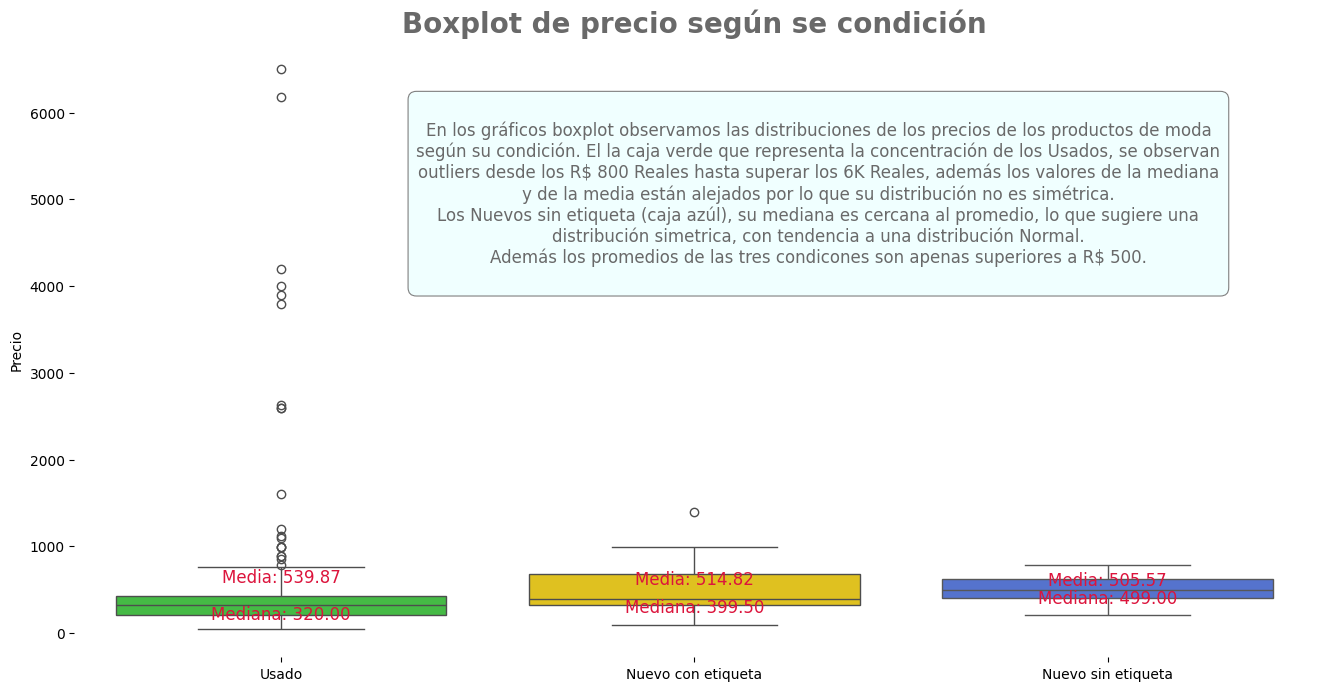

In [26]:
# Filtrar el DataFrame para cada condición
df_usado = df_productos[df_productos['condicion'] == 'Usado']
df_nuevo = df_productos[df_productos['condicion'] == 'Nuevo con etiqueta']
df_etiqueta = df_productos[df_productos['condicion'] == 'Nuevo sin etiqueta']

# Crear los boxplots
plt.subplots(figsize=(16, 8), facecolor='none')
sns.boxplot(data=df_usado, x='condicion', y='precio', color='limegreen')
sns.boxplot(data=df_nuevo, x='condicion', y='precio', color='gold')
sns.boxplot(data=df_etiqueta, x='condicion', y='precio', color='royalblue')

# Calcular medianas y medias
median_usado = np.median(df_usado['precio'])
median_nuevo = np.median(df_nuevo['precio'])
median_etiqueta = np.median(df_etiqueta['precio'])

mean_usado = np.mean(df_usado['precio'])
mean_nuevo = np.mean(df_nuevo['precio'])
mean_etiqueta = np.mean(df_etiqueta['precio'])

# Mostrar valores en la gráfica
plt.text(0, median_usado, f'Mediana: {median_usado:.2f}', ha='center', va='top', color='crimson', fontsize=12)
plt.text(1, median_nuevo, f'Mediana: {median_nuevo:.2f}', ha='center', va='top', color='crimson', fontsize=12)
plt.text(2, median_etiqueta, f'Mediana: {median_etiqueta:.2f}', ha='center', va='top', color='crimson', fontsize=12)

plt.text(0, mean_usado, f'Media: {mean_usado:.2f}', ha='center', va='bottom', color='crimson', fontsize=12)
plt.text(1, mean_nuevo, f'Media: {mean_nuevo:.2f}', ha='center', va='bottom', color='crimson', fontsize=12)
plt.text(2, mean_etiqueta, f'Media: {mean_etiqueta:.2f}', ha='center', va='bottom', color='crimson', fontsize=12)

text_boxplot = '''
En los gráficos boxplot observamos las distribuciones de los precios de los productos de moda
según su condición. El la caja verde que representa la concentración de los Usados, se observan
outliers desde los R$ 800 Reales hasta superar los 6K Reales, además los valores de la mediana
y de la media están alejados por lo que su distribución no es simétrica.
Los Nuevos sin etiqueta (caja azúl), su mediana es cercana al promedio, lo que sugiere una
distribución simetrica, con tendencia a una distribución Normal.
Además los promedios de las tres condicones son apenas superiores a R$ 500.
'''
plt.annotate(text_boxplot, xy=(0.6, 0.6), xycoords='axes fraction', ha='center', va='bottom',
         bbox=dict(boxstyle='round,pad=.5', fc='azure', ec='gray', lw=.8), fontsize=12, color='dimgray')


plt.title('Boxplot de precio según se condición',fontsize=20, color='dimgray', fontweight='bold')
plt.xlabel('')
plt.ylabel('Precio')
plt.box(None)
plt.show()


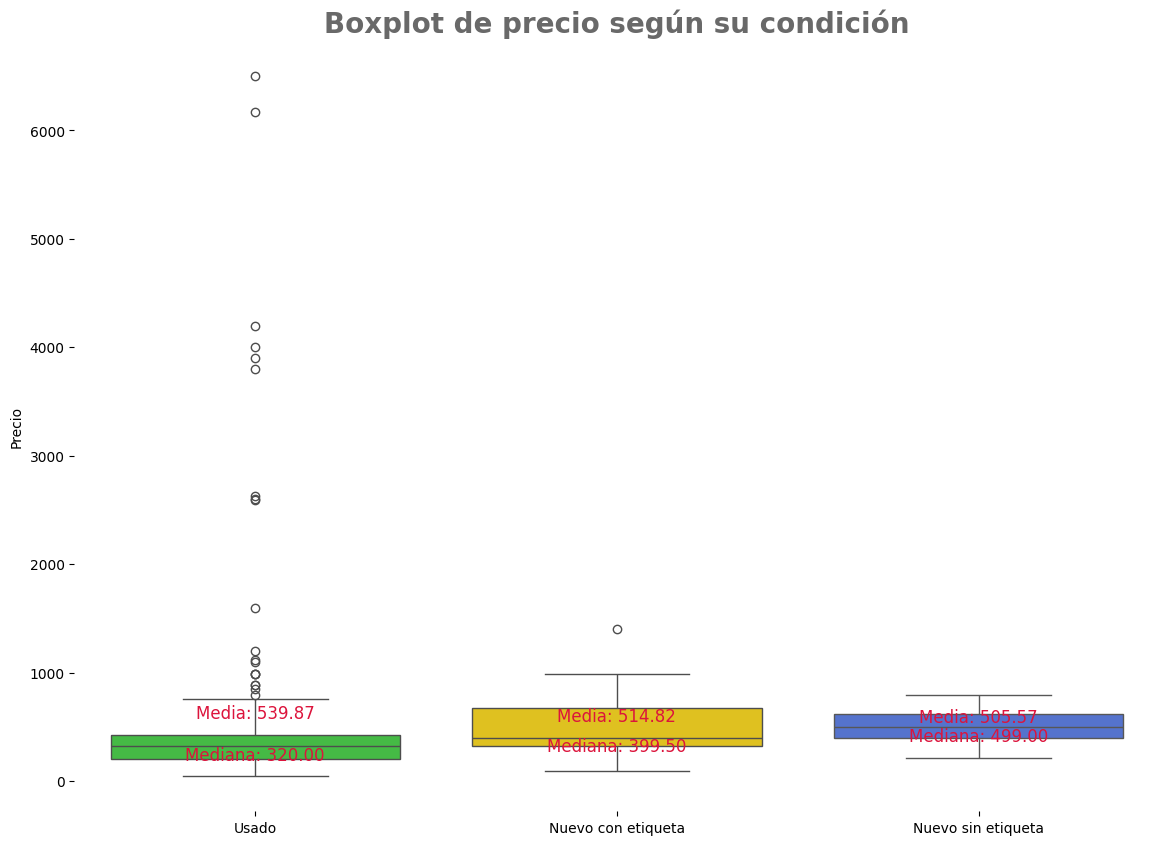

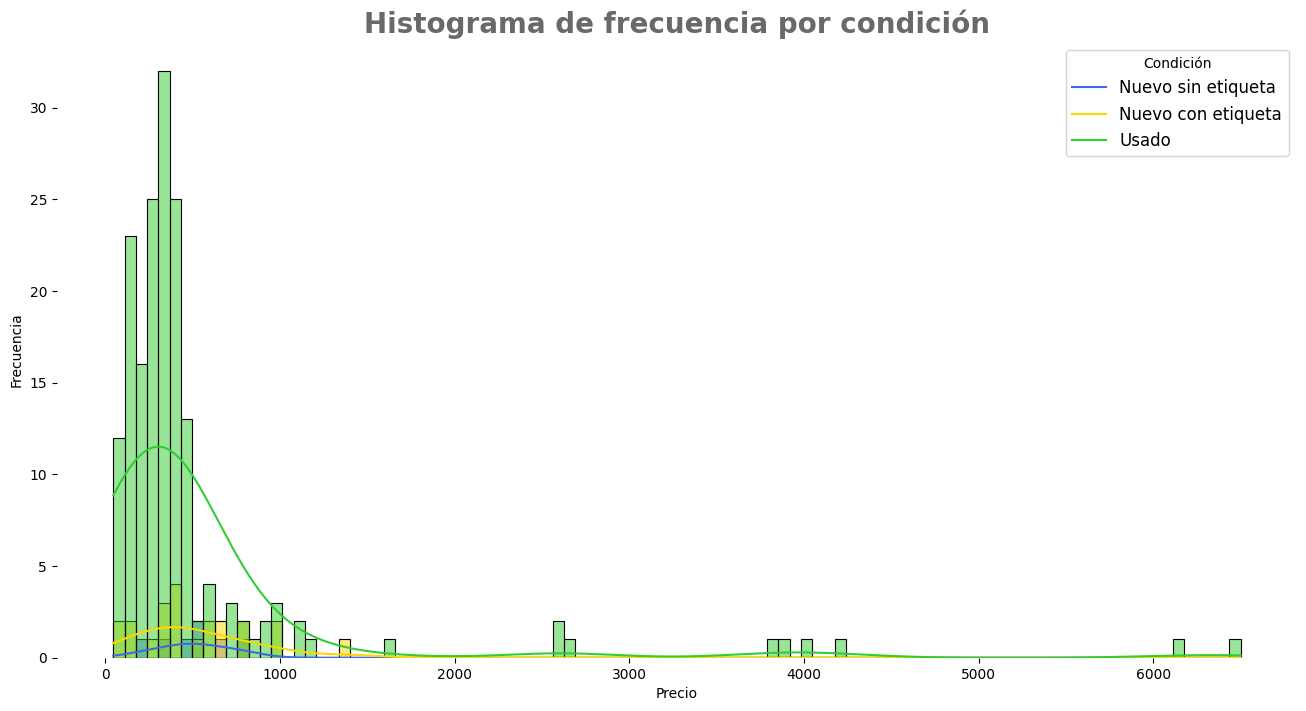


En los gráficos boxplot observamos las distribuciones de los precios de los productos de moda
según su condición. El la caja verde que representa la concentración de los Usados, se observan
outliers desde los R$ 800 Reales hasta superar los 6K Reales, pero al igual que los productos
Nuevos sin etiqueta (caja azúl), su mediana es cercana al promedio, lo que sugieren una
distribución simetrica, con tendencia a una distribución Normal, en especial la caja azúl.
Además los promedios de las tres condicones son apenas superiores a R$ 500.



<Figure size 640x480 with 0 Axes>

In [27]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar el DataFrame para cada condición
df_usado = df_productos[df_productos['condicion'] == 'Usado']
df_nuevo = df_productos[df_productos['condicion'] == 'Nuevo con etiqueta']
df_etiqueta = df_productos[df_productos['condicion'] == 'Nuevo sin etiqueta']

# Crear los boxplots
plt.subplots(figsize=(14, 10), facecolor='none')
sns.boxplot(data=df_usado, x='condicion', y='precio', color='limegreen')
sns.boxplot(data=df_nuevo, x='condicion', y='precio', color='gold')
sns.boxplot(data=df_etiqueta, x='condicion', y='precio', color='royalblue')

# Calcular medianas y medias
median_usado = np.median(df_usado['precio'])
median_nuevo = np.median(df_nuevo['precio'])
median_etiqueta = np.median(df_etiqueta['precio'])

mean_usado = np.mean(df_usado['precio'])
mean_nuevo = np.mean(df_nuevo['precio'])
mean_etiqueta = np.mean(df_etiqueta['precio'])

# Mostrar valores en la gráfica
plt.text(0, median_usado, f'Mediana: {median_usado:.2f}', ha='center', va='top', color='crimson', fontsize=12)
plt.text(1, median_nuevo, f'Mediana: {median_nuevo:.2f}', ha='center', va='top', color='crimson', fontsize=12)
plt.text(2, median_etiqueta, f'Mediana: {median_etiqueta:.2f}', ha='center', va='top', color='crimson', fontsize=12)

plt.text(0, mean_usado, f'Media: {mean_usado:.2f}', ha='center', va='bottom', color='crimson', fontsize=12)
plt.text(1, mean_nuevo, f'Media: {mean_nuevo:.2f}', ha='center', va='bottom', color='crimson', fontsize=12)
plt.text(2, mean_etiqueta, f'Media: {mean_etiqueta:.2f}', ha='center', va='bottom', color='crimson', fontsize=12)

text_boxplot_3 = '''
En los gráficos boxplot observamos las distribuciones de los precios de los productos de moda
según su condición. El la caja verde que representa la concentración de los Usados, se observan
outliers desde los R$ 800 Reales hasta superar los 6K Reales, pero al igual que los productos
Nuevos sin etiqueta (caja azúl), su mediana es cercana al promedio, lo que sugieren una
distribución simetrica, con tendencia a una distribución Normal, en especial la caja azúl.
Además los promedios de las tres condicones son apenas superiores a R$ 500.
'''
# plt.annotate(text_boxplot_3, xy=(0.6, 0.6), xycoords='axes fraction', ha='center', va='bottom',
#              bbox=dict(boxstyle='round,pad=.5', fc='azure', ec='gray', lw=.8), fontsize=12, color='dimgray')

plt.title('Boxplot de precio según su condición', fontsize=20, color='dimgray', fontweight='bold')
plt.xlabel('')
plt.ylabel('Precio')
plt.box(None)
plt.savefig('/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/graf/003_boxplot_x3.png', dpi=300, bbox_inches='tight')
plt.show()
# Histograma de frecuencias
plt.figure(figsize=(16, 8), facecolor='none')
sns.histplot(df_productos, x='precio', hue='condicion', bins=100, kde=True, palette=['limegreen','gold','royalblue'], legend=True)
plt.title('Histograma de frecuencia por condición', fontsize=20, color='dimgray', fontweight='bold')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
legend_labels = ['Nuevo sin etiqueta', 'Nuevo con etiqueta', 'Usado']
plt.legend(labels=legend_labels, title='Condición', fontsize=12, fancybox=True, frameon=True)
plt.box(None)
plt.show()
print(text_boxplot_3)
plt.savefig('/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/graf/003_histograma_x3.png', dpi=300, bbox_inches='tight')


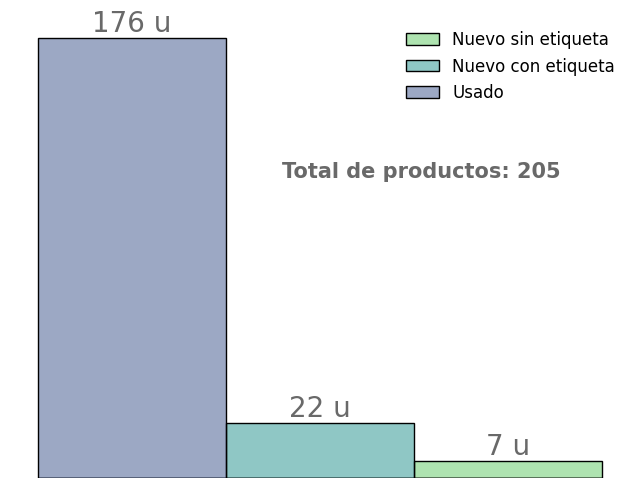

In [28]:
# Histograma de frecuencia vs condición:
plt.subplots(figsize=(8, 6), facecolor='none')
ax = sns.histplot(data=df_productos, x='condicion', stat='count', discrete=True, palette='viridis', edgecolor='black',hue='condicion')
# plt.title('Histograma de frecuencia según su condición',fontsize=20, color='dimgray', fontweight='bold',pad=30)
plt.xlabel('')
plt.ylabel('')
plt.yticks([])
plt.xticks([])
plt.grid(None)
plt.box(None)
count_product=0
for p in ax.patches:
    if p.get_height() != 0:  # Solo agrega el texto si la altura de la barra es diferente de cero
        count_product+=p.get_height()
        ax.annotate(f'{p.get_height()} u', (p.get_x() + p.get_width() / 2., 3 + p.get_height()),
                    ha='center', va='center', fontsize=20, color='dimgray', xytext=(0, 5),
                    textcoords='offset points')
plt.annotate(f'Total de productos: {count_product}',(.8,120), fontsize=15, color='dimgray',fontweight= 'bold')
legend_labels = ['Nuevo sin etiqueta', 'Nuevo con etiqueta', 'Usado']
plt.legend(labels=legend_labels, title='', fontsize=12, fancybox=False, frameon=False)
plt.savefig('/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/graf/004_histograma_x3_condicion.png', dpi=300, bbox_inches='tight')

plt.show()


In [29]:
# Unir df_itens_pedidos con df_pedidos
df_merged = pd.merge(df_itens_pedidos, df_productos, on='producto_id', how='inner')
df_merged_sorted_count=df_merged.sort_values(by='cantidad',ascending=False)
df_merged_sorted_count['ganancia_neta']=(df_merged_sorted_count['valor_total']-df_merged_sorted_count['costo_envio']).astype(int)
df_merged_sorted_count.head()

id_recibo  producto_id  pedido_id  cantidad  valor_unitario  \
19297      21001        97039     128307         6             320   
15687       5050        73038     130584         6              90   
5008       19099        83795     113150         6             310   
15746      16210        73038      70909         6              90   
20823      19858        88368      61653         6             250   

       valor_total ciudad  costo_envio               producto  precio  \
19297         1920  BR-DF        384.0      Calca Jeans Ilhos   320.0   
15687          540  BR-ES        108.0    Blusa Veludo Flores    90.0   
5008          1860  BR-MA        372.0  Vestido Estampa Color   310.0   
15746          540  BR-PE        108.0    Blusa Veludo Flores    90.0   
20823         1500  BR-MT        300.0       Blusa Malha Azul   250.0   

                marca       sku condicion  ganancia_neta  
19297          Colcci  947042.0     Usado           1536  
15687  Isa Kulikovski  248238.0     Usado            432  
5008           Cantão  309928.0     Usado           1488  
15746  Isa Kulikovski  248238.0     Usado            432  
20823        Talie Nk  254726.0     Usado           1200

In [53]:
df_mixed=df_merged_sorted_count[df_merged_sorted_count['marca']=='Mixed']
len(df_mixed.producto.unique())

14

In [56]:
df_marca_count=df_merged_sorted_count.groupby('marca')['producto'].unique().reset_index()
df_marca_count['count'] = df_marca_count['producto'].apply(len)

df_marca_count.sort_values(by='count')
df=df_marca_count['count'].value_counts()
df=pd.DataFrame(df)
# df.reset_index(drop=False,inplace=True)
df.rename(columns={'count':'Marcas'},inplace=True)
# df.rename(columns={'count':'brand_quantity'},inplace=True)
df.reset_index(inplace=True)
# df.rename(columns={'count':'product_quantity'},inplace=True)
df.rename(columns={'count':'Productos'},inplace=True)
df[['Productos',	'Marcas']]
#/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/tablas

# fig, ax = plt.subplots(figsize=(3, 6), dpi=100)

# # Ocultar los ejes
# ax.axis('off')

# # Crear la tabla
# table = ax.table(cellText=df.values, colLabels=df.columns, loc='center')

# # Guardar la figura como imagen
# plt.savefig('/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/tablas/tabla.png', bbox_inches='tight', pad_inches=0.05)

# # Mostrar la figura (opcional)
# plt.show()

Productos  Marcas
0          1      86
1          2      18
2          3       6
3          4       2
4          9       1
5          5       1
6          6       1
7         14       1
8         22       1

In [57]:
print('Canticad de Marcas: ',len(df_merged_sorted_count.marca.unique()))
print('Canticad de productos: ',len(df_merged_sorted_count.producto.unique()))

Canticad de Marcas:  117
Canticad de productos:  201


In [58]:
df_product_count=df_merged_sorted_count.groupby(['producto','precio'])[['ganancia_neta','cantidad']].sum().reset_index().sort_values(by='ganancia_neta', ascending=False)
# df_product_count['total_neto']=df_product_count.precio*df_product_count.cantidad*.8
df_product_count.head(10)

producto  precio  ganancia_neta  cantidad
40          Bolsa Classica Roxa  6500.0        2288000       440
42   Bolsa Intrecciato Caramelo  6175.0        1773460       359
145           Sapato Cetim Pink  3900.0        1457040       467
181         Vestido Longo Preto  4200.0        1451520       432
122           Saia Couro Tijolo  3800.0        1401440       461
41             Bolsa Coral Saco  4000.0        1148800       359
147        Scarpin Bege Textura  2590.0         953120       460
110       Oculos Redondo Purple  2600.0         898560       432
157      Sneaker Monograma Bege  2630.0         879472       418
96          Clutch Preta Pregas  1600.0         492800       385

In [59]:
df_merged_sorted_count.groupby('producto')['ganancia_neta'].sum().reset_index().sort_values(by='ganancia_neta', ascending=False)

producto  ganancia_neta
40          Bolsa Classica Roxa        2288000
42   Bolsa Intrecciato Caramelo        1773460
142           Sapato Cetim Pink        1457040
178         Vestido Longo Preto        1451520
120           Saia Couro Tijolo        1401440
..                          ...            ...
148       Shorts Estampa Floral          28512
153               Shorts Poa Pb          28480
157       Top Cropped Coqueiros          25152
103      Macaquinho Tricot Bege          16520
167        Vestido Estampa Laco          14904

[201 rows x 2 columns]

###**Top 10 marca:**

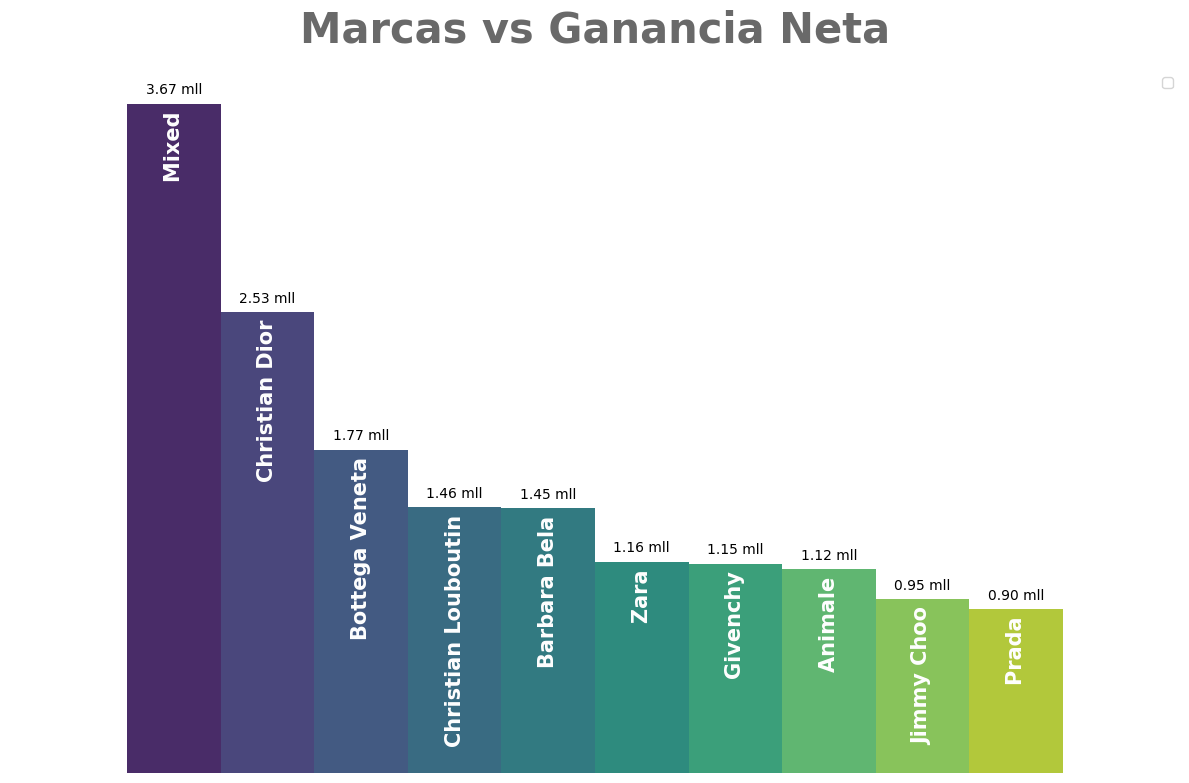

In [60]:
df=df_merged_sorted_count.copy()
top_10_marcas = df.groupby('marca')['ganancia_neta'].sum().nlargest(10)
df_top_10_marcas=top_10_marcas.reset_index()
plt.figure(figsize=(12, 8),facecolor='none')#101A24
ax = sns.barplot(hue=df_top_10_marcas.marca, y=df_top_10_marcas.ganancia_neta,palette='viridis')

for p in ax.patches:
    if p.get_height() !=0:
      ax.annotate(f'{p.get_height()/1e6:.2f} mll',
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')

for marca, p in zip(df_top_10_marcas.marca, ax.patches):
    ax.text(p.get_x() + p.get_width() / 2, p.get_height(), f'{marca} ',
            color='white', ha="center", va='top', rotation=90, fontsize=15, fontweight='bold')

plt.title('Marcas vs Ganancia Neta',fontsize=30, color='dimgray', fontweight='bold',pad=20)
# plt.title('Top 10 de Marcas por Ganancia Neta',fontsize=20, color='dimgray', fontweight='bold',pad=20)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.box(None)
plt.legend('')
plt.savefig('/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/graf/005_ganancia_vs_marca.png', dpi=300, bbox_inches='tight')
plt.show()

<ipython-input-61-b5246cacead4>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=df_top_10_marcas.ganancia_neta, y=df_top_10_marcas.marca, palette='viridis')


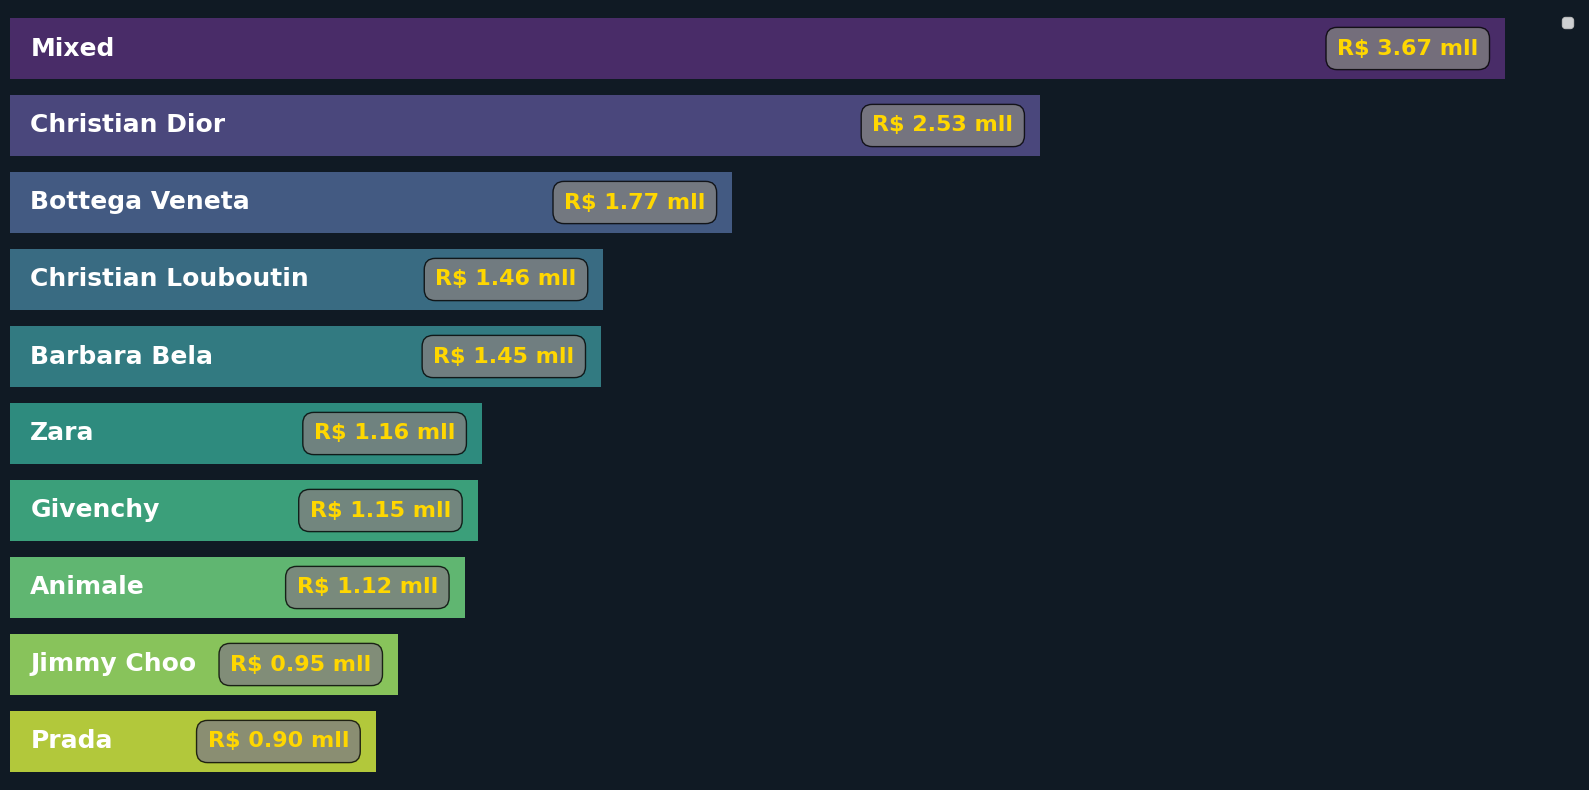

In [61]:
df=df_merged_sorted_count.copy()
top_10_marcas = df.groupby('marca')['ganancia_neta'].sum().nlargest(10)
df_top_10_marcas=top_10_marcas.reset_index()
plt.figure(figsize=(16, 8),facecolor='#101A24')

# Cambiar la orientación a horizontal y ajustar los datos
ax = sns.barplot(x=df_top_10_marcas.ganancia_neta, y=df_top_10_marcas.marca, palette='viridis')

for p in ax.patches:
    if p.get_width() != 0:  # Solo agrega el texto si el ancho de la barra es diferente de cero
        ax.annotate(f'R$ {p.get_width()/1e6:.2f} mll',
                    (p.get_width()-1e5, p.get_y() + p.get_height() / 2),
                    ha='right', va='center', xytext=(10, 0),
                    textcoords='offset points', fontsize=16, color='gold',fontweight='bold',
        bbox=dict(facecolor='gray',alpha=.8, edgecolor='black', boxstyle='round,pad=0.5'))

# Colocar el nombre de la marca al final de cada barra
for marca, p in zip(df_top_10_marcas.marca, ax.patches):
    ax.text(5e4, p.get_y() + p.get_height() / 2, f'{marca}',
            color='white', ha='left', va='center', fontsize=18, fontweight='bold')

# plt.title('Marcas vs Ganancia Neta', fontsize=30, color='dimgray', fontweight='bold', pad=20)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.box(None)
plt.legend('')
plt.savefig('/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/graf/005_ganancia_vs_marca_001.png', dpi=300, bbox_inches='tight')
plt.show()


###**Top 10 productos:**

<ipython-input-62-b8d5cd0df761>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=df_ver['producto'], y=df_ver['ganancia_neta'],palette='viridis',legend=False)


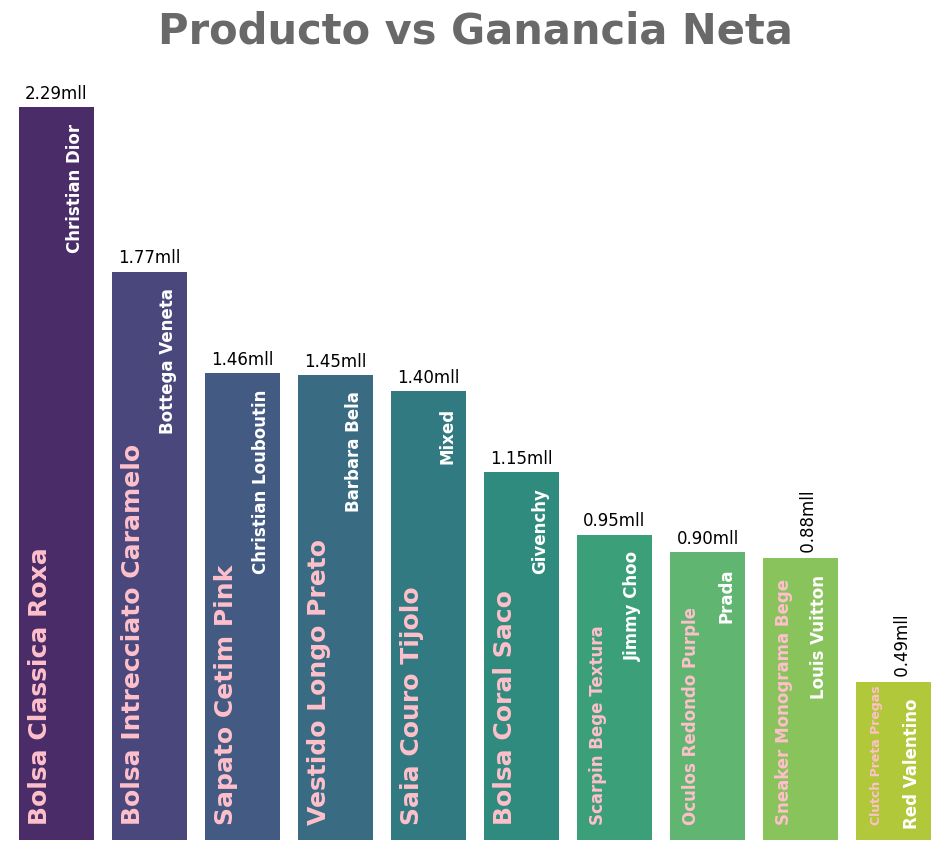

In [62]:
df=df_merged_sorted_count.copy()

top_10_producto_con_marca = df.groupby(['marca','producto'])['ganancia_neta'].sum().nlargest(10)

df_ver=pd.DataFrame(top_10_producto_con_marca)
df_ver.reset_index(drop=False,inplace=True)

plt.figure(figsize=(12, 10),facecolor='none')
ax = sns.barplot(x=df_ver['producto'], y=df_ver['ganancia_neta'],palette='viridis',legend=False)

# Agregar etiquetas con el nombre de la marca al inicio de cada barra
for index, row in df_ver.iterrows():
    ax.text(row.name+.2, row['ganancia_neta']-5e4, row['marca'],
            color='white', ha="center", va='top', rotation=90,fontsize=12,fontweight='bold')
    if row.name in [0, 1, 2, 3, 4, 5]:
      ax.text(row.name - 0.18, 5e4, row['producto'],
              color='pink', ha="center", va='bottom', rotation=90, fontsize=18, fontweight='bold')
    if row.name in [6,7,8]:
      ax.text(row.name - 0.18, 5e4, row['producto'],
              color='pink', ha="center", va='bottom', rotation=90, fontsize=12, fontweight='bold')
    if row.name in [9]:
      ax.text(row.name - 0.18, 5e4, row['producto'],
              color='pink', ha="center", va='bottom', rotation=90, fontsize=9, fontweight='bold')

# Agregar valores al final de las barras
for p in ax.patches:
  if p.get_height()>8.9e5:
    ax.annotate(f'{p.get_height()/1e6:.2f}mll',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points',fontsize=12)
  else:
    ax.annotate(f'         {p.get_height()/1e6:.2f}mll',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'left', va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points',fontsize=12,rotation=90)

plt.title('Producto vs Ganancia Neta',fontsize=30, color='dimgray', fontweight='bold',pad=20)
# plt.title('Top 10 de producto por Ganancia Neta',fontsize=20, color='dimgray', fontweight='bold',pad=30)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.box(None)
plt.savefig('/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/graf/005_ganancia_vs_productos.png', dpi=300, bbox_inches='tight')
plt.show()

In [63]:
print(100-(177*100/229))
print(100-(146*100/229))

22.707423580786028
36.24454148471616


In [64]:
df_product_count=df_merged_sorted_count.groupby(['producto','precio'])[['ganancia_neta','cantidad']].sum().reset_index().sort_values(by='ganancia_neta', ascending=False)


In [65]:
df=df_merged_sorted_count
top_10_producto_con_marca = df.groupby(['marca', 'producto','condicion'])[['ganancia_neta','cantidad']].sum().reset_index().sort_values(by='ganancia_neta', ascending=False)
top_10_producto_con_marca.head(10)

marca                    producto condicion  ganancia_neta  \
42        Christian Dior         Bolsa Classica Roxa     Usado        2288000   
31        Bottega Veneta  Bolsa Intrecciato Caramelo     Usado        1773460   
44   Christian Louboutin           Sapato Cetim Pink     Usado        1457040   
26          Barbara Bela         Vestido Longo Preto     Usado        1451520   
135                Mixed           Saia Couro Tijolo     Usado        1401440   
80              Givenchy            Bolsa Coral Saco     Usado        1148800   
93            Jimmy Choo        Scarpin Bege Textura     Usado         953120   
146                Prada       Oculos Redondo Purple     Usado         898560   
115        Louis Vuitton      Sneaker Monograma Bege     Usado         879472   
150        Red Valentino         Clutch Preta Pregas     Usado         492800   

     cantidad  
42        440  
31        359  
44        467  
26        432  
135       461  
80        359  
93        460  
146       432  
115       418  
150       385

<ipython-input-66-03041b5a5397>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=df_ver['producto'], x=df_ver['ganancia_neta'], palette='viridis', orient='h')


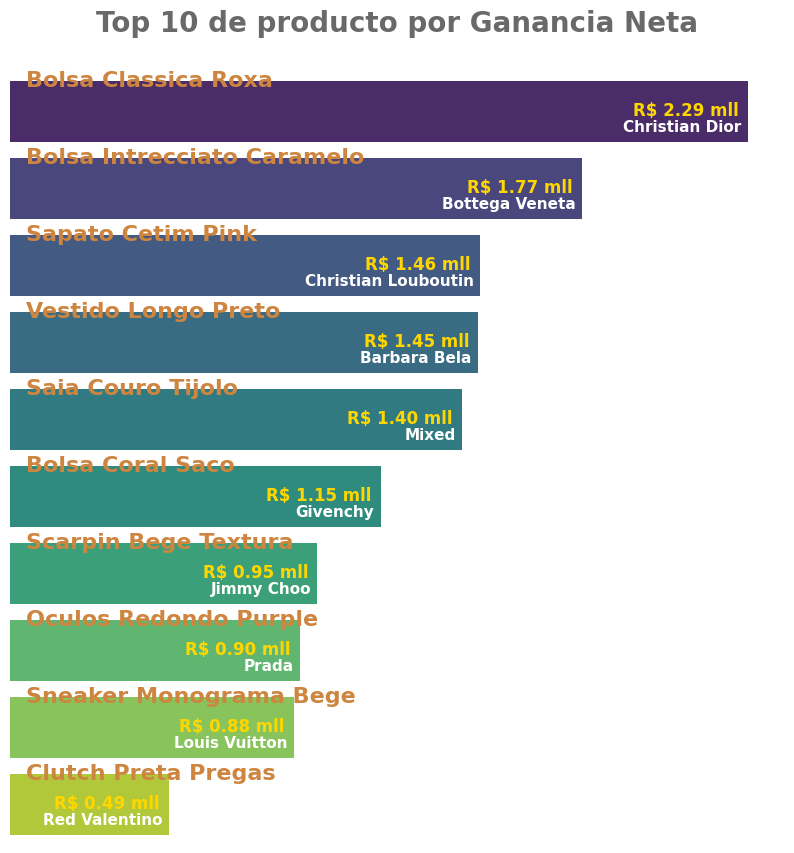

In [66]:
df = df_merged_sorted_count.copy()
top_10_producto_con_marca = df.groupby(['marca', 'producto'])['ganancia_neta'].sum().nlargest(10)
# top_10_producto_con_marca = df.groupby(['marca', 'producto','condicion'])[['ganancia_neta','cantidad']].sum().reset_index().sort_values(by='ganancia_neta', ascending=False).head(10)

# Convertir a DataFrame
df_ver = pd.DataFrame(top_10_producto_con_marca)
df_ver.reset_index(drop=False, inplace=True)

# Crear el gráfico
plt.figure(figsize=(10, 10),facecolor='none') ##101A24
ax = sns.barplot(y=df_ver['producto'], x=df_ver['ganancia_neta'], palette='viridis', orient='h')

# Agregar etiquetas con el nombre de la marca al inicio de cada barra
for index, row in df_ver.iterrows():
    ax.text(row['ganancia_neta']-2e4, row.name+.2, row['marca'],
            color='white', ha="right", va='center', fontsize=11, fontweight='bold')
    ax.text(5e4, row.name+-.4, row['producto'],
            color='peru', ha="left", va='center', fontsize=16, fontweight='bold')

# Agregar valores al final de las barras
for p in ax.patches:
     ax.annotate(f'R$ {p.get_width()/1e6:.2f} mll    ',
                    (p.get_width(), p.get_y() + p.get_height() / 2 ),
                    va='center', ha='right',
                    xytext=(10, 1),
                    textcoords='offset points', fontsize=12, color='gold',fontweight='bold')

plt.title('Top 10 de producto por Ganancia Neta', fontsize=20, color='dimgray', fontweight='bold', pad=30)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.box(None)
plt.savefig('/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/graf/006_ganancia_vs_productos.png', dpi=300, bbox_inches='tight')
plt.show()


<ipython-input-67-00f7a6674a43>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=df_ver['producto'], x=df_ver['ganancia_neta'], palette='viridis', orient='h')


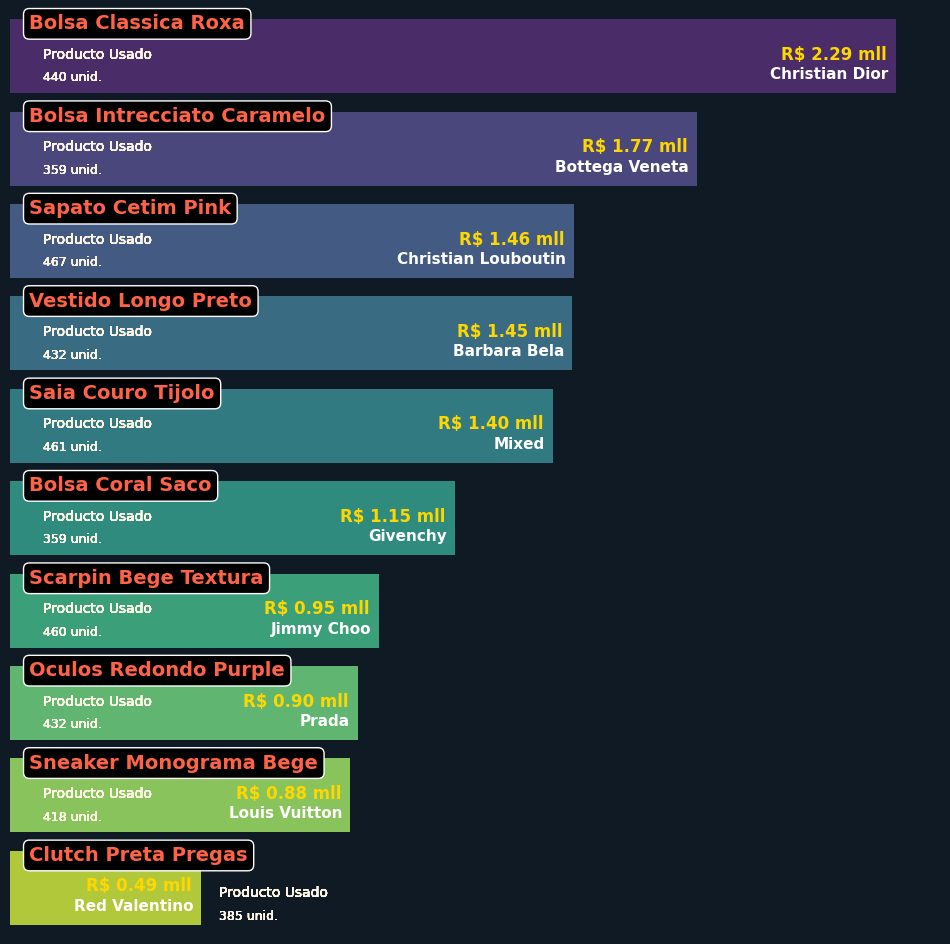

In [67]:
df = df_merged_sorted_count.copy()
# top_10_producto_con_marca = df.groupby(['marca', 'producto','condicion'])['ganancia_neta'].sum().nlargest(10)
top_10_producto_con_marca = df.groupby(['marca', 'producto','condicion'])[['ganancia_neta','cantidad']].sum().reset_index().sort_values(by='ganancia_neta', ascending=False).head(10)

df_ver = top_10_producto_con_marca.copy()
df_ver.reset_index(drop=False, inplace=True)

# Crear el gráfico
plt.figure(figsize=(12, 12),facecolor='#101A24') #
ax = sns.barplot(y=df_ver['producto'], x=df_ver['ganancia_neta'], palette='viridis', orient='h')

# Agregar etiquetas con el nombre de la marca al inicio de cada barra
for index, row in df_ver.iterrows():
    ax.text(row['ganancia_neta']-2e4, row.name+.2, row['marca'],
            color='white', ha="right", va='center', fontsize=11, fontweight='bold')
    ax.text(5e4, row.name+-.35, row['producto'],
            color='tomato', ha="left", va='center', fontsize=14, fontweight='bold',
            bbox=dict(facecolor='black', edgecolor='w', boxstyle='round,pad=0.3'))

# Agregar valores al final de las barras
for p in ax.patches:
    ax.annotate(f'R$ {p.get_width()/1e6:.2f} mll    ',
                    (p.get_width(), p.get_y() + p.get_height() / 2 ),
                    va='center', ha='right',
                    xytext=(10, 1),
                    textcoords='offset points', fontsize=12, color='gold',fontweight='bold')
    for index, row in df_ver.iterrows():
        if p.get_width() > 8e5:
            ax.annotate(f'Producto {row["condicion"]}',
                        (5e4, p.get_y() + p.get_height() / 2),
                        va='center', ha='left',
                        xytext=(10, 1),
                        textcoords='offset points', fontsize=10, color='oldlace')
        else:
            ax.annotate(f'Producto {row["condicion"]}',
                        (p.get_width()+1e4, p.get_y() + p.get_height() / 2),
                        va='top', ha='left',
                        xytext=(10, 1),
                        textcoords='offset points', fontsize=10, color='oldlace')

    for  p,(index, row) in zip(ax.patches,df_ver.iterrows()):
        if p.get_width() > 8e5:
            ax.annotate(f'{row["cantidad"]} unid.',
                        (5e4, p.get_y() + p.get_height() / 2+.25),
                        va='center', ha='left',
                        xytext=(10, 1),
                        textcoords='offset points', fontsize=9, color='oldlace')
        else:
            ax.annotate(f'{row["cantidad"]} unid.',
                        (p.get_width()+1e4, p.get_y() + p.get_height() / 2+.25),
                        va='top', ha='left',
                        xytext=(10, 1),
                        textcoords='offset points', fontsize=9, color='oldlace')

# plt.title('Top 10 de producto por Ganancia Neta', fontsize=20, color='dimgray', fontweight='bold', pad=30)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.box(None)
plt.savefig('/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/graf/006_ganancia_vs_productos_01.png', dpi=300, bbox_inches='tight')
plt.show()


In [68]:
# Agrupar por producto y encontrar el precio máximo
productos_mayor_precio = df_productos.groupby('producto')['precio'].max()

df_productos_mayor_precio=pd.DataFrame(productos_mayor_precio)
df_productos_mayor_precio.reset_index(inplace=True)
df_productos_mayor_precio=df_productos_mayor_precio.sort_values(by='precio',ascending=False).head(10)
df_productos_mayor_precio.reset_index(drop=True,inplace=True)
df_productos_mayor_precio

producto  precio
0         Bolsa Classica Roxa  6500.0
1  Bolsa Intrecciato Caramelo  6175.0
2         Vestido Longo Preto  4200.0
3            Bolsa Coral Saco  4000.0
4           Sapato Cetim Pink  3900.0
5           Saia Couro Tijolo  3800.0
6      Sneaker Monograma Bege  2630.0
7       Oculos Redondo Purple  2600.0
8        Scarpin Bege Textura  2590.0
9         Clutch Preta Pregas  1600.0

<ipython-input-69-3cf5eabbee8b>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=df['producto'], y=df['precio'],palette='viridis',legend=False)


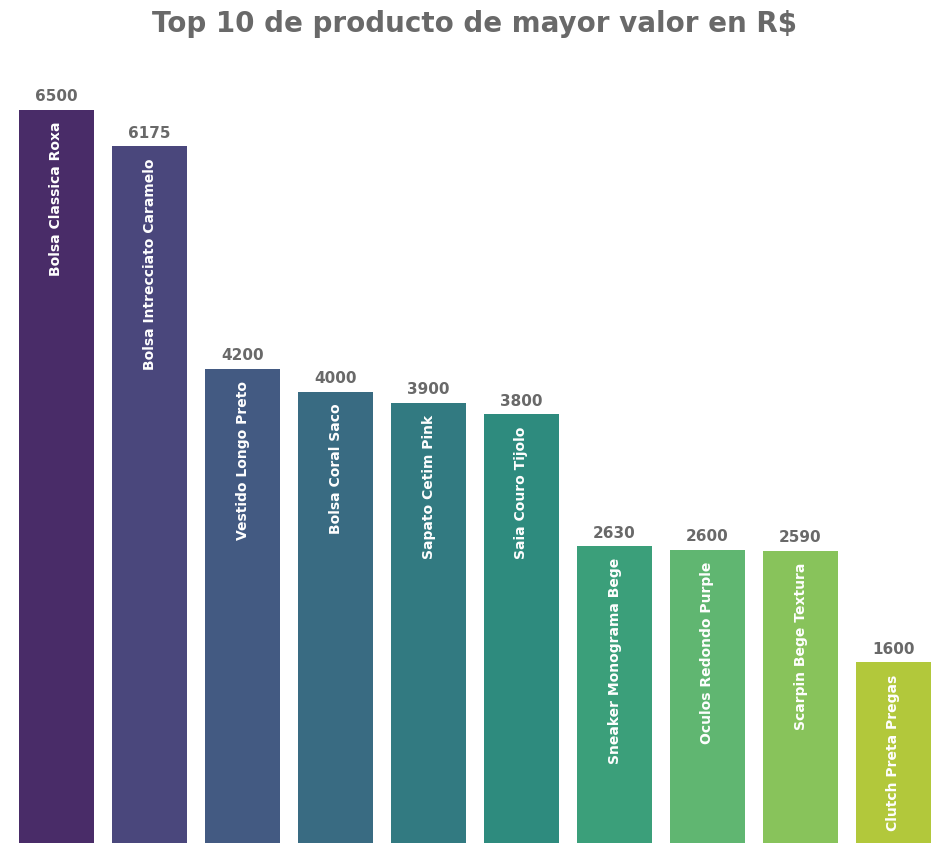

In [69]:
df=df_productos_mayor_precio.copy()

plt.figure(figsize=(12, 10))
ax = sns.barplot(x=df['producto'], y=df['precio'],palette='viridis',legend=False)

# Agregar etiquetas con el nombre del product en la barra:
for index, row in df.iterrows():
    # print(row)
    ax.text(row.name, row['precio']-100, row.producto,
            color='white', ha="center", va='top', rotation=90,fontsize=10,fontweight='bold')

# Agregar valores al final de las barras
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points',fontsize=11,color='dimgray',fontweight='bold')


plt.title('Top 10 de producto de mayor valor en R$',fontsize=20, color='dimgray', fontweight='bold',pad=30)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
# plt.tight_layout()
plt.box(None)
plt.show()

###**Limpieza de codigo de Estado:**

In [70]:
df_itens_pedidos['ganancia_neta']=df_itens_pedidos.valor_total-df_itens_pedidos.costo_envio
df=df_itens_pedidos.copy()
top_ciudad = df.groupby('ciudad')['ganancia_neta'].sum()
# top_10_ciudad = df.groupby('ciudad')['ganancia_neta'].sum().nlargest(50)
df_ciudades_ganancias_netas=pd.DataFrame(top_ciudad)
df_ciudades_ganancias_netas.reset_index(inplace=True)
df_ciudades_ganancias_netas['cod_ciudad_brasil']= [ciudad.replace('BR-', '') for ciudad in df_ciudades_ganancias_netas.ciudad]
df_ciudades_ganancias_netas.drop(columns='ciudad',axis=1,inplace=True)
df_ciudades_ganancias_netas.head()

ganancia_neta cod_ciudad_brasil
0      1128520.0                AC
1      1522016.0                AL
2      1244092.8                AM
3      1475737.6                AP
4      1322517.6                BA

###**Obtener datos demográficos:**

http://www.geo-ref.net/sp/bra.htm

In [71]:
url = "http://www.geo-ref.net/sp/bra.htm"
tables = pd.read_html(url)
if tables:
    primera_tabla = tables[1]
else:
    print("No se encontraron tablas en la página")
primera_tabla.to_csv('/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/DDBB/data_population.csv', index=False)

In [72]:
df_population=pd.read_csv('/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/DDBB/data_population.csv')
indice_inicio_eliminar = 27
df_population = df_population.drop(df_population.index[indice_inicio_eliminar:])
df_population['Population'] = df_population['Population'].str.replace(' ', '')
df_population['Population'] = pd.to_numeric(df_population['Population'])
df_population

Estado ISO 3166-2         Capital Area (km²)  Population  \
0                  Acre      BR-AC      Rio Branco    153 150      830026   
1               Alagoas      BR-AL          Maceió     27 933     3127511   
2                 Amapá      BR-AP          Macapá    143 454      733508   
3              Amazonas      BR-AM          Manaus  1 577 820     3941175   
4                 Bahia      BR-BA        Salvador    567 295    14136417   
5                 Ceará      BR-CE       Fortaleza    146 348     8791688   
6      Distrito Federal      BR-DF        Brasília      5 822     2817068   
7        Espírito Santo      BR-ES         Vitória     46 184     3833486   
8                 Goiás      BR-GO         Goiânia    341 290     7055228   
9              Maranhão      BR-MA        São Luís    333 366     6775152   
10          Mato Grosso      BR-MT          Cuiabá    906 807     3658813   
11   Mato Grosso do Sul      BR-MS    Campo Grande    358 159     2756700   
12         Minas Gerais      BR-MG  Belo Horizonte    588 384    20538718   
13                 Pará      BR-PA           Belém  1 253 165     8116132   
14              Paraíba      BR-PB     João Pessoa     56 585     3974495   
15               Paraná      BR-PR        Curitiba    199 709    11443208   
16           Pernambuco      BR-PE          Recife     98 938     9058155   
17                Piauí      BR-PI        Teresina    252 378     3269200   
18       Rio de Janeiro      BR-RJ  Rio de Janeiro     43 910    16054524   
19  Rio Grande do Norte      BR-RN           Natal     53 307     3302406   
20    Rio Grande do Sul      BR-RS    Porto Alegre    282 062    10880506   
21             Rondônia      BR-RO     Porto Velho    238 513     1581016   
22              Roraima      BR-RR       Boa Vista    225 116      636303   
23       Santa Catarina      BR-SC   Florianópolis     95 443     7609601   
24            São Paulo      BR-SP       São Paulo    248 809    44420459   
25              Sergipe      BR-SE         Aracaju     22 050     2209558   
26            Tocantins      BR-TO          Palmas    278 421     1511459   

   Density (pers/km²)  
0                 542  
1               11196  
2                 511  
3                 250  
4                2492  
5                6007  
6               48387  
7                8300  
8                2067  
9                2032  
10                403  
11                770  
12               3491  
13                648  
14               7024  
15               5730  
16               9155  
17               1295  
18              36562  
19               6195  
20               3857  
21                663  
22                283  
23               7973  
24              17853  
25              10021  
26                543

###**Agregar los nombres de Estados apartir del Código de Estado:**

In [73]:
# Diccionario de correspondencias entre siglas y nombres de ciudades
ciudades = {
    'AC': 'Acre',
    'AL': 'Alagoas',
    'AM': 'Amazonas',
    'AP': 'Amapá',
    'BA': 'Bahía',
    'CE': 'Ceará',
    'DF': 'Distrito Federal',
    'ES': 'Espírito Santo',
    'GO': 'Goiás',
    'MA': 'Maranhão',
    'MG': 'Minas Gerais',
    'MS': 'Mato Grosso do Sul',
    'MT': 'Mato Grosso',
    'PA': 'Pará',
    'PB': 'Paraíba',
    'PE': 'Pernambuco',
    'PI': 'Piauí',
    'PR': 'Paraná',
    'RJ': 'Río de Janeiro',
    'RN': 'Río Grande del Norte',
    'RO': 'Rondônia',
    'RR': 'Roraima',
    'RS': 'Río Grande del Sur',
    'SC': 'Santa Catarina',
    'SE': 'Sergipe',
    'SP': 'São Paulo',
    'TO': 'Tocantins'
}

In [74]:
# Reemplazar las siglas por los nombres de las ciudades en el dataframe
df_ciudades_ganancias_netas['ciudad'] = df_ciudades_ganancias_netas['cod_ciudad_brasil'].map(ciudades)
df_ciudades_ganancias_netas=df_ciudades_ganancias_netas[['cod_ciudad_brasil','ciudad','ganancia_neta']]
df_ciudades_ganancias_netas

cod_ciudad_brasil                ciudad  ganancia_neta
0                 AC                  Acre      1128520.0
1                 AL               Alagoas      1522016.0
2                 AM              Amazonas      1244092.8
3                 AP                 Amapá      1475737.6
4                 BA                 Bahía      1322517.6
5                 CE                 Ceará      1468080.8
6                 DF      Distrito Federal      1327094.4
7                 ES        Espírito Santo      1275874.4
8                 GO                 Goiás      1418205.6
9                 MA              Maranhão      1453059.2
10                MG          Minas Gerais      1314788.8
11                MS    Mato Grosso do Sul      1221190.4
12                MT           Mato Grosso      1363611.2
13                PA                  Pará      1345199.2
14                PB               Paraíba      1423834.4
15                PE            Pernambuco      1509197.6
16                PI                 Piauí      1358606.4
17                PR                Paraná      1308105.6
18                RJ        Río de Janeiro      1334395.2
19                RN  Río Grande del Norte      1335573.6
20                RO              Rondônia      1317495.2
21                RR               Roraima      1349770.4
22                RS    Río Grande del Sur      1320528.8
23                SC        Santa Catarina      1476962.4
24                SE               Sergipe      1339291.2
25                SP             São Paulo      1404412.0
26                TO             Tocantins      1284983.2

In [75]:
import geopandas as gpd
import geobr
df=df_ciudades_ganancias_netas

br_uf = geobr.read_state()
br_uf = br_uf.rename(columns={'abbrev_state': 'cod_ciudad_brasil'})
br_uf_d = br_uf.merge(df, on='cod_ciudad_brasil')
br_uf_d = br_uf_d[['geometry','cod_ciudad_brasil', 'ganancia_neta']]
br_uf_d.head()

geometry cod_ciudad_brasil  \
0  MULTIPOLYGON (((-63.32721 -7.97672, -62.86662 ...                RO   
1  MULTIPOLYGON (((-73.18253 -7.33550, -72.58477 ...                AC   
2  MULTIPOLYGON (((-67.32609 2.02971, -67.31682 2...                AM   
3  MULTIPOLYGON (((-60.20051 5.26434, -60.19273 5...                RR   
4  MULTIPOLYGON (((-54.95431 2.58369, -54.93542 2...                PA   

   ganancia_neta  
0      1317495.2  
1      1128520.0  
2      1244092.8  
3      1349770.4  
4      1345199.2

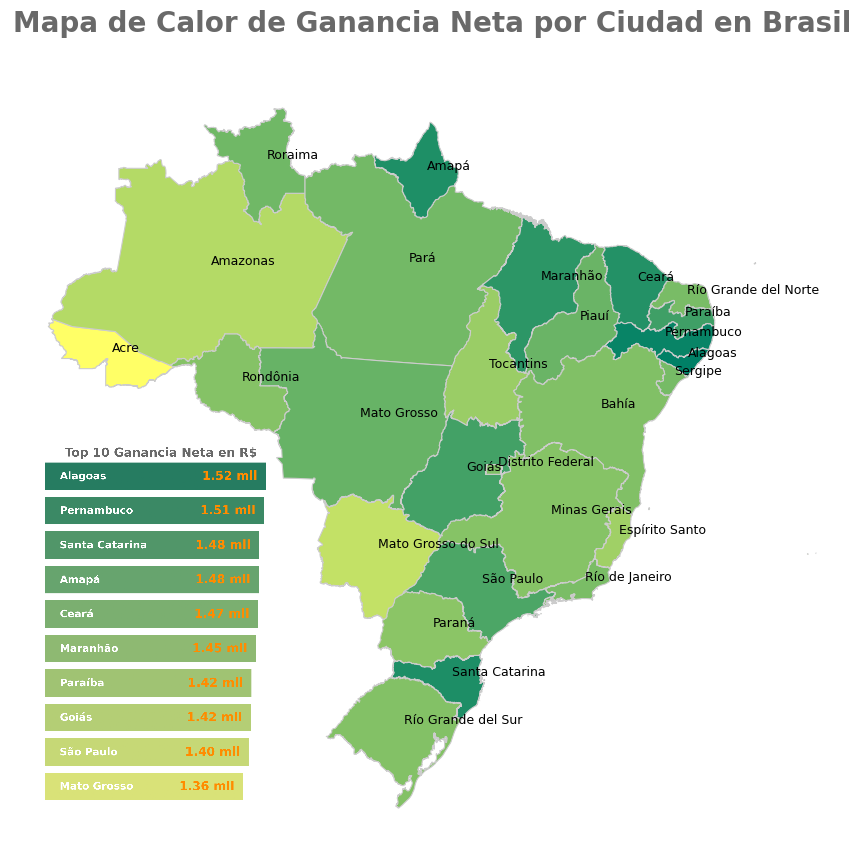

In [76]:
br_uf_d['state'] = br_uf_d['cod_ciudad_brasil'].map(ciudades)
br_uf_d_projected = br_uf_d.to_crs('EPSG:3857')

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
br_uf_d_projected.plot(column='ganancia_neta', cmap='summer_r', linewidth=0.8, ax=ax, edgecolor='0.8', legend=False)

# Agregar el nombre de la ciudad en cada lugar
for x, y, label in zip(br_uf_d_projected.geometry.centroid.x, br_uf_d_projected.geometry.centroid.y, br_uf_d_projected.state):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize=9, color='black')

plt.title('Mapa de Calor de Ganancia Neta por Ciudad en Brasil', fontsize=20, color='dimgray', fontweight='bold', pad=30)
plt.axis('off')

# Ajustar la posición de la imagen
graf = '/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/graf/top10_state_ganancia.png'
graf_gan = OffsetImage(plt.imread(graf), zoom=0.15)
ab_graf = AnnotationBbox(graf_gan, (-7.5e6, -2.8e6), frameon=False, xycoords='data', boxcoords='data', pad=0, zorder=100)
# ab_graf = AnnotationBbox(graf_gan, (br_uf_d_projected.total_bounds[0], br_uf_d_projected.total_bounds[1]), frameon=True, xycoords='data', boxcoords='data', pad=0, zorder=100)
# print(br_uf_d_projected.total_bounds[0], br_uf_d_projected.total_bounds[1])
plt.gca().add_artist(ab_graf)

plt.show()


###**Top 10 de ciudades por ganancia neta en R$:**

In [77]:
df=df_itens_pedidos.copy()
top_10_ciudad = df.groupby('ciudad')['ganancia_neta'].sum().nlargest(10)
df_top_10_ciudad=pd.DataFrame(top_10_ciudad)
df_top_10_ciudad.reset_index(drop=False,inplace=True)
df_top_10_ciudad['cod_ciudad_brasil']=[ciudad.replace('BR-', '') for ciudad in df_top_10_ciudad.ciudad]
df_top_10_ciudad['ciudad'] = df_top_10_ciudad['cod_ciudad_brasil'].map(ciudades)
df_top_10_ciudad

ciudad  ganancia_neta cod_ciudad_brasil
0         Alagoas      1522016.0                AL
1      Pernambuco      1509197.6                PE
2  Santa Catarina      1476962.4                SC
3           Amapá      1475737.6                AP
4           Ceará      1468080.8                CE
5        Maranhão      1453059.2                MA
6         Paraíba      1423834.4                PB
7           Goiás      1418205.6                GO
8       São Paulo      1404412.0                SP
9     Mato Grosso      1363611.2                MT

In [78]:
# df=df_itens_pedidos.copy()
# citys = df.groupby('ciudad')['ganancia_neta'].sum().astype(int)
# df_ciudad_ganancia
# df_ciudad_ganancia=pd.DataFrame(citys)
# df_ciudad_ganancia.reset_index(drop=False,inplace=True)
# df_ciudad_ganancia['cod_ciudad_brasil']=[ciudad.replace('BR-', '') for ciudad in df_ciudad_ganancia.ciudad]
# df_ciudad_ganancia['ciudad'] = df_ciudad_ganancia['cod_ciudad_brasil'].map(ciudades)
# df_ciudad_ganancia=df_ciudad_ganancia.sort_values(by='ganancia_neta',ascending=False)
# df_ciudad_ganancia

In [79]:
# plt.figure(figsize=(4, 8),facecolor='none')
# ax = sns.barplot(y=df_ciudad_ganancia.ciudad, x=df_ciudad_ganancia.ganancia_neta, palette='summer')

# for p in ax.patches:
#     ax.annotate(f'{p.get_width()/1e6:.2f} mll',
#                 (p.get_width(), p.get_y() + p.get_height() / 2.),
#                 ha='left', va='center',
#                 xytext=(10, 0),
#                 textcoords='offset points',color='dimgray',fontsize=10, fontweight='bold')

# for index, row in df_ciudad_ganancia.reset_index(drop=True).reset_index(drop=True).iterrows():
#     ax.text(1e5, index, row['ciudad'],
#             color='white', ha='left', va='center', fontsize=10, fontweight='bold')

# plt.title('Top Ganancia Neta en R$', fontsize=18, color='dimgray', fontweight='bold', pad=30)
# plt.xlabel('')
# plt.ylabel('')
# plt.xticks([])
# plt.yticks([])
# plt.tight_layout()
# plt.box(None)
# plt.show()


In [80]:
# plt.figure(figsize=(12, 6))
# ax = sns.barplot(x=df_top_10_ciudad.ciudad, y=df_top_10_ciudad.ganancia_neta,palette='summer')

# for p in ax.patches:
#     ax.annotate(f'{p.get_height()/1e6:.2f} mll',
#                 (p.get_x() + p.get_width() / 2., p.get_height()),
#                 ha = 'center', va = 'center',
#                 xytext = (0, 10),
#                 textcoords = 'offset points')

# for index, row in df_top_10_ciudad.iterrows():
#     ax.text(row.name, row['ganancia_neta']-.5e5, row['ciudad'],
#             color='white', ha="center", va='top', rotation=90,fontsize=18,fontweight='bold')

# plt.title('Top 10 de ciudades de Brasil por Ganancia Neta  en R$',fontsize=20, color='dimgray', fontweight='bold',pad=30)
# plt.xlabel('')
# plt.ylabel('')
# plt.xticks([])
# plt.yticks([])
# plt.tight_layout()
# plt.box(None)
# plt.show()

<ipython-input-81-3934e6c1fcf9>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=df.ciudad, x=df.ganancia_neta, palette='summer')


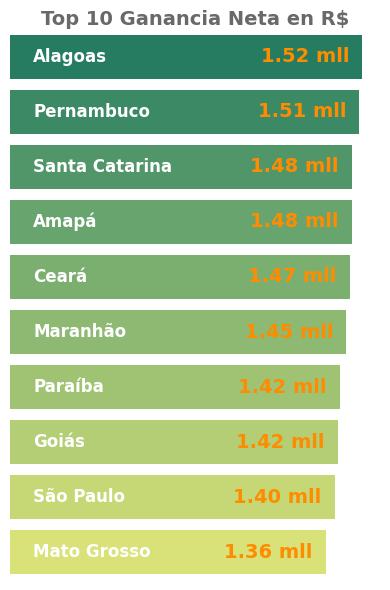

In [81]:
df=df_top_10_ciudad.copy()
plt.figure(figsize=(4, 6),facecolor='none')
ax = sns.barplot(y=df.ciudad, x=df.ganancia_neta, palette='summer')

for p in ax.patches:
    ax.annotate(f'{p.get_width()/1e6:.2f} mll',
                (p.get_width()-5e5, p.get_y() + p.get_height() / 2.),
                ha='left', va='center',
                xytext=(10, 0),
                textcoords='offset points',color='darkorange',fontsize=14, fontweight='bold')

for index, row in df.reset_index(drop=True).reset_index(drop=True).iterrows():
    ax.text(1e5, index, row['ciudad'],
            color='white', ha='left', va='center', fontsize=12, fontweight='bold')

plt.title('Top 10 Ganancia Neta en R$', fontsize=14, color='dimgray', fontweight='bold', pad=0)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.box(None)
plt.savefig('/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/graf/top10_state_ganancia.png', dpi=300, bbox_inches='tight')
plt.show()


#**3. Preguntas y respuestas**


---




##**3.1 Creando el banco de datos**

In [82]:
#@title
def crear_conexion():
    global df_itens_pedidos, df_pedidos, df_productos, df_vendedores, database
    # Crea el engine de SQLite
    # database = 'mi_base_de_datos.db'
    database = create_engine(f'sqlite:///:memory', echo=False)

    # Adiciona los dataframes a las tablas SQL
    df_itens_pedidos.to_sql('itens_pedidos', database, if_exists='replace', index=False)
    df_pedidos.to_sql('pedidos', database, if_exists='replace', index=False)
    df_productos.to_sql('productos', database, if_exists='replace', index=False)
    df_vendedores.to_sql('vendedores', database, if_exists='replace', index=False)

    print("¡Conexión creada y datos guardados en la base de datos!")

# Llama a la función para crear la conexión y guardar los datos
crear_conexion()

¡Conexión creada y datos guardados en la base de datos!


In [83]:
from sqlalchemy import inspect
# engine = create_engine(f'sqlite:///{database}', echo=False)

# Crear el objeto Inspector
inspector = inspect(database)

# Imprimir las tablas en la base de datos
print('Tablas: ', inspector.get_table_names(), '\n')

# Imprimir las columnas de la tabla "pedidos"
print('Columnas de Tabla Pedidos:')
for column in inspector.get_columns('pedidos'):
    print(column['name'])


Tablas:  ['itens_pedidos', 'pedidos', 'productos', 'vendedores'] 

Columnas de Tabla Pedidos:
pedido_id
producto_id
vendedor_id
fecha_compra
total


In [84]:
crear_conexion()
inspector = inspect(database)
print('Tablas: ', inspector.get_table_names(), '\n')
print('Columnas de Tabla Pedidos:')
print('----------------------------------------------')
for column in inspector.get_columns('itens_pedidos'):
    print('Columnas de Tabla itens_pedidos:')
    print(column)
print('----------------------------------------------')
for column in inspector.get_columns('pedidos'):
    print('Columnas de Tabla Pedidos:')
    print(column)
print('----------------------------------------------')
for column in inspector.get_columns('productos'):
    print('Columnas de Tabla productos:')
    print(column)
print('----------------------------------------------')
for column in inspector.get_columns('vendedores'):
    print('Columnas de Tabla vendedores:')
    print(column)
database.dispose()

¡Conexión creada y datos guardados en la base de datos!
Tablas:  ['itens_pedidos', 'pedidos', 'productos', 'vendedores'] 

Columnas de Tabla Pedidos:
----------------------------------------------
Columnas de Tabla itens_pedidos:
{'name': 'id_recibo', 'type': BIGINT(), 'nullable': True, 'default': None, 'primary_key': 0}
Columnas de Tabla itens_pedidos:
{'name': 'producto_id', 'type': BIGINT(), 'nullable': True, 'default': None, 'primary_key': 0}
Columnas de Tabla itens_pedidos:
{'name': 'pedido_id', 'type': BIGINT(), 'nullable': True, 'default': None, 'primary_key': 0}
Columnas de Tabla itens_pedidos:
{'name': 'cantidad', 'type': BIGINT(), 'nullable': True, 'default': None, 'primary_key': 0}
Columnas de Tabla itens_pedidos:
{'name': 'valor_unitario', 'type': BIGINT(), 'nullable': True, 'default': None, 'primary_key': 0}
Columnas de Tabla itens_pedidos:
{'name': 'valor_total', 'type': BIGINT(), 'nullable': True, 'default': None, 'primary_key': 0}
Columnas de Tabla itens_pedidos:
{'name

###**Ver DDBB**

In [85]:
Tablas:  ['itens_pedidos', 'pedidos', 'productos', 'vendedores']
query='''
SELECT * FROM itens_pedidos
'''
df_query = pd.read_sql_query(query, database)
df_query.columns

Index(['id_recibo', 'producto_id', 'pedido_id', 'cantidad', 'valor_unitario',
       'valor_total', 'ciudad', 'costo_envio', 'ganancia_neta'],
      dtype='object')

##**Pregunta 1: ¿Cual es el Top 5 productos más vendidos históricamente?**

In [86]:
query_1 = """
SELECT
    productos.producto_id,
    productos.producto,
    productos.condicion,
    productos.marca,
    productos.precio * SUM(itens_pedidos.cantidad) AS total_vendido,
    SUM(itens_pedidos.cantidad) AS cantidad_vendida
FROM
    productos
JOIN
    itens_pedidos ON productos.producto_id = itens_pedidos.producto_id
GROUP BY
    productos.producto_id
ORDER BY
    cantidad_vendida DESC
LIMIT 5;
"""

df_query_1 = pd.read_sql_query(query_1, database)
database.dispose()
df_query_1['total_vendido_K']=(df_query_1['total_vendido']/1000).astype(int)
df_query_1

producto_id             producto           condicion                marca  \
0        32126      Saia Midi Cinto  Nuevo sin etiqueta  Limone By Jade Seba   
1        13814    Vestido Nude Reta  Nuevo sin etiqueta                Ellus   
2        47405  Blusa Manga Estampa               Usado              Animale   
3        33976   Camisa Xadrez Azul               Usado            Hollister   
4        53941  Cropped Escritas Pb               Usado      Linda de Morrer   

   total_vendido  cantidad_vendida  total_vendido_K  
0       115290.0               549              115  
1       300850.0               547              300  
2       166160.0               536              166  
3        61320.0               511               61  
4       142240.0               508              142

##**1.2 Visualización:**

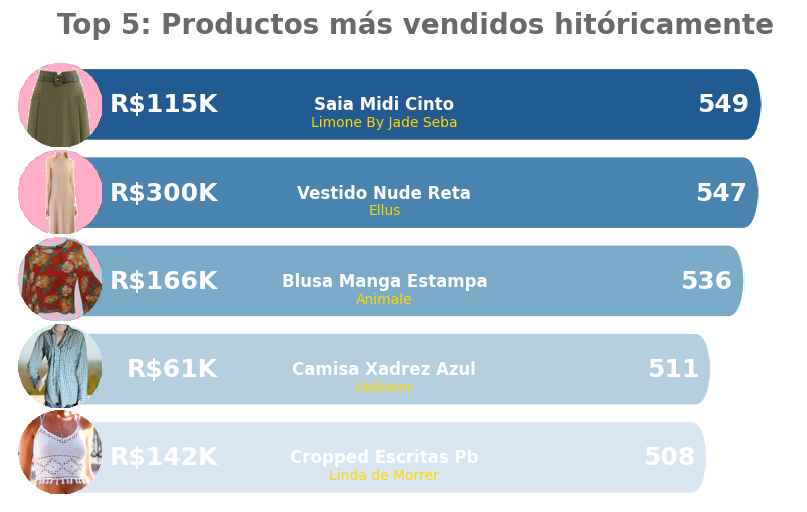

In [87]:
df=df_query_1.copy()

sns.set(style="whitegrid")
sns.set_palette("Blues_r")

plt.subplots(figsize=(10, 6),facecolor='none')#101A24
ax = sns.barplot(x='cantidad_vendida', y='producto', data=df, errorbar=None, hue='producto',palette='Blues_r')

for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', (p.get_width()-10, p.get_y() + p.get_height() / 2), ha='right', va='center', xytext=(1, 0), textcoords='offset points',color='white',fontweight='bold',fontsize=18)

for index, value in enumerate(df['total_vendido_K']):
    ax.text(140, index, f'R${value}K', va='center', ha='right', color='white',fontweight='bold', fontsize=18)

medio=(df.cantidad_vendida.mean())/2
for index, value in enumerate(df['producto']):
    ax.text(medio, index, value, va='center', ha='center', color='white',fontweight='bold')

medio=(df.cantidad_vendida.mean())/2
for index, value in enumerate(df['marca']):
    ax.text(medio, index+.2, value, va='center', ha='center', color='gold',fontsize=10)


plt.title('Top 5: Productos más vendidos hitóricamente', color='dimgray',fontsize=20,fontweight='bold',pad=20)

#Redondeo de barras:
new_patches = []
for patch in reversed(ax.patches):
    bb = patch.get_bbox()
    color = patch.get_facecolor()
    p_bbox = FancyBboxPatch((bb.xmin, bb.ymin),
                            abs(bb.width), abs(bb.height),
                            boxstyle="round,pad=-0.0040,rounding_size=12",
                            ec="none", fc=color,
                            mutation_aspect=0.05
                            )
    patch.remove()
    new_patches.append(p_bbox)

for patch in new_patches:
    ax.add_patch(patch)


img_path_01 = '/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/img/falda_midi_cinto_r.png'
img_path_02 = '/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/img/Vestido_recto_nude_r.png'
img_path_03 = '/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/img/blusa_mangas_estampadas_r.png'
img_path_04 = '/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/img/camisa_xadrez_azul_r.png'
img_path_05 = '/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/img/cropped_escritas_r.png'
img_list=[img_path_05,img_path_04,img_path_03,img_path_02,img_path_01]
#Colocar img:
for i, patch in enumerate(ax.patches):
    img = OffsetImage(plt.imread(img_list[i]), zoom=.6)
    ab = AnnotationBbox(img, (patch.get_x()+10, patch.get_y()+.01 + patch.get_height() / 2), frameon=False, xycoords='data', boxcoords="offset points", pad=0.5)
    ax.add_artist(ab)

sns.despine(left=True, bottom=True)
ax.tick_params(axis=u'both', which=u'both', length=0)
plt.tight_layout()
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.box(None)
plt.savefig('/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/graf/productos_mas_vendidos_008.png', dpi=300, bbox_inches='tight')
plt.show()

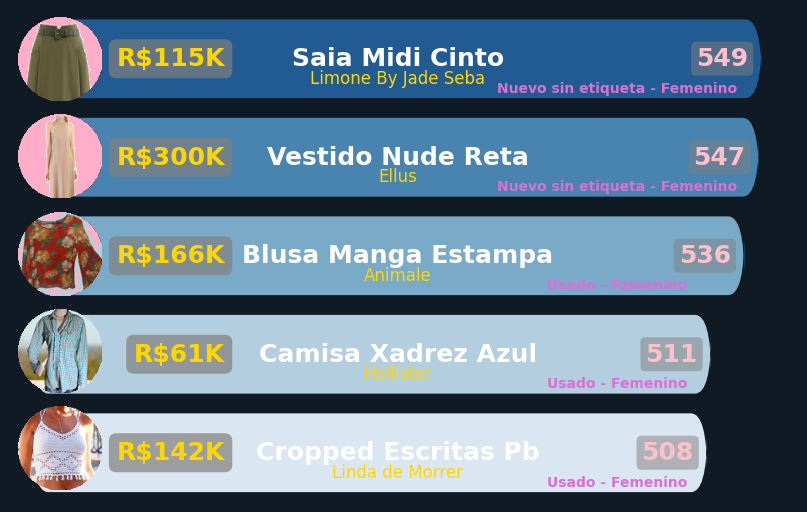

In [88]:
df=df_query_1.copy()

sns.set(style="whitegrid")
sns.set_palette("Blues_r")

plt.subplots(figsize=(10, 6),facecolor='#101A24')#101A24
ax = sns.barplot(x='cantidad_vendida', y='producto', data=df, errorbar=None, hue='producto',palette='Blues_r')

for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', (p.get_width()-11, p.get_y() + p.get_height() / 2), ha='right', va='center', xytext=(1, 0), textcoords='offset points',color='pink',fontweight='bold',fontsize=18,
                        bbox=dict(facecolor='gray',alpha=.5, edgecolor='none', boxstyle='round,pad=0.2'))

for index, value in enumerate(df['total_vendido_K']):
    ax.text(145, index, f'R${value}K', va='center', ha='right', color='gold',fontweight='bold', fontsize=18,
        bbox=dict(facecolor='gray',alpha=.7, edgecolor='none', boxstyle='round,pad=0.3'))

medio=(df.cantidad_vendida.mean())/2
for index, value in enumerate(df['producto']):
    ax.text(medio+10, index, value, va='center', ha='center', color='white',fontweight='bold',fontsize=18)

medio=(df.cantidad_vendida.mean())/2
for index, value in enumerate(df['marca']):
    ax.text(medio+10, index+.2, value, va='center', ha='center', color='gold',fontsize=12)

for index, value in enumerate(df['condicion']):
    ax.text(medio+175, index+.3, f"{value} - Femenino", va='center', ha='center', color='orchid',fontsize=10,fontweight='bold')


# plt.title('Top 5: Productos más vendidos hitóricamente', color='dimgray',fontsize=20,fontweight='bold',pad=20)

#Redondeo de barras:
new_patches = []
for patch in reversed(ax.patches):
    bb = patch.get_bbox()
    color = patch.get_facecolor()
    p_bbox = FancyBboxPatch((bb.xmin, bb.ymin),
                            abs(bb.width), abs(bb.height),
                            boxstyle="round,pad=-0.0040,rounding_size=12",
                            ec="none", fc=color,
                            mutation_aspect=0.05
                            )
    patch.remove()
    new_patches.append(p_bbox)

for patch in new_patches:
    ax.add_patch(patch)

img_path_01 = '/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/img/falda_midi_cinto_r.png'
img_path_02 = '/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/img/Vestido_recto_nude_r.png'
img_path_03 = '/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/img/blusa_mangas_estampadas_r.png'
img_path_04 = '/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/img/camisa_xadrez_azul_r.png'
img_path_05 = '/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/img/cropped_escritas_r.png'
img_list=[img_path_05,img_path_04,img_path_03,img_path_02,img_path_01]
#Colocar img:
for i, patch in enumerate(ax.patches):
    img = OffsetImage(plt.imread(img_list[i]), zoom=.6)
    ab = AnnotationBbox(img, (patch.get_x()+10, patch.get_y()+.01 + patch.get_height() / 2), frameon=False, xycoords='data', boxcoords="offset points", pad=0.5)
    ax.add_artist(ab)

sns.despine(left=True, bottom=True)
ax.tick_params(axis=u'both', which=u'both', length=0)
plt.tight_layout()
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.box(None)
plt.savefig('/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/graf/productos_mas_vendidos_008_bg101A24.png', dpi=300, bbox_inches='tight')
plt.show()

###**Observamos en la gráfica que la marca Limone By jade Seba, con su Saia Midi Cinto tiene el mayor número de productos vendidos con un ingreso de R$ 115K, pero la Marca Ellus, con su Vestido Nude Reta lidera en ingresos con 300 mil Reales. Todos los productos son femeninos.**

##**Pregunta 2: ¿Cual es la evolución histórica de las ingresos netos?**

In [89]:
query_2='''
SELECT
    pedidos.fecha_compra,
    SUM(pedidos.total - itens_pedidos.costo_envio) AS total_ventas
FROM
    pedidos
JOIN
    itens_pedidos itens_pedidos ON pedidos.pedido_id = itens_pedidos.pedido_id
GROUP BY
    pedidos.fecha_compra;
'''
df_query_2 = pd.read_sql_query(query_2, database)
database.dispose()
df_query_2.head()

fecha_compra  total_ventas
0  2019-01-05 00:00:00.000000       32460.8
1  2019-01-06 00:00:00.000000        1728.0
2  2019-01-07 00:00:00.000000        1560.0
3  2019-01-08 00:00:00.000000        1024.0
4  2019-01-09 00:00:00.000000         400.0

In [90]:
query_2_11='''
SELECT
    pedidos.*,
    itens_pedidos.*,
    productos.*
FROM
    pedidos
JOIN
    itens_pedidos ON pedidos.pedido_id = itens_pedidos.pedido_id
JOIN
    productos ON itens_pedidos.producto_id = productos.producto_id
GROUP BY
    pedidos.pedido_id;
'''
df_query_2_11 = pd.read_sql_query(query_2_11, database)
database.dispose()
df_query_2_11.drop_duplicates(inplace=True)
df_query_2_11.head()

pedido_id  producto_id  vendedor_id                fecha_compra  total  \
0          1         5292            2  2020-02-16 00:00:00.000000   3456   
1          3        29650            3  2020-02-01 00:00:00.000000    720   
2          9        18751            5  2021-02-04 00:00:00.000000   5940   
3         11         7871            3  2019-12-01 00:00:00.000000   2520   
4         21         2706            3  2020-01-03 00:00:00.000000   2950   

   id_recibo  producto_id  pedido_id  cantidad  valor_unitario  valor_total  \
0      10062         5292          1         6             576         3456   
1       9453        29650          3         6             120          720   
2      24512        18751          9         6             990         5940   
3       7184         7871         11         6             420         2520   
4       8221         2706         21         5             590         2950   

  ciudad  costo_envio  ganancia_neta  producto_id               producto  \
0  BR-PE        691.2         2764.8         5292      Saia Jeans Forest   
1  BR-CE        144.0          576.0        29650     Vestido Estampa Pb   
2  BR-SC       1188.0         4752.0        18751  Vestido Couro Franjas   
3  BR-DF        504.0         2016.0         7871    Vestido Ziper Fendi   
4  BR-MT        590.0         2360.0         2706            Blusa Cinza   

   precio     marca       sku           condicion  
0   576.0     Mixed  222683.0  Nuevo con etiqueta  
1   120.0       H&m  285576.0               Usado  
2   990.0  Spezzato  304187.0  Nuevo con etiqueta  
3   420.0   Thelure  318544.0               Usado  
4   590.0     Mixed  297627.0               Usado

In [91]:
###  SELECCION DE CANTIDAD DE COMPRAS POR AAAA-MM  ####
query_2_112='''
SELECT
    strftime('%Y-%m', pedidos.fecha_compra) AS año_mes,
    SUM(itens_pedidos.cantidad) AS cantidad_vendida,
    SUM(pedidos.total) AS total_por_mes
FROM
    pedidos
JOIN
    itens_pedidos ON pedidos.pedido_id = itens_pedidos.pedido_id
GROUP BY
    año_mes
ORDER BY
    año_mes;
'''
df_query_2_112 = pd.read_sql_query(query_2_112, database)
database.dispose()
df_query_2_112.drop_duplicates(inplace=True)
df_query_2_112.head()

año_mes  cantidad_vendida  total_por_mes
0  2019-01               517         260616
1  2019-02              1181         548144
2  2019-03              1769         883559
3  2019-04              1584         904471
4  2019-05              2288        1202017

In [92]:
###  SELECCION DE CANTIDAD DE COMPRAS POR AAAA  ####

query_2_1121='''
SELECT
    strftime('%Y', pedidos.fecha_compra) AS año_mes,
    SUM(itens_pedidos.cantidad) AS cantidad_vendida,
    SUM(pedidos.total) AS total_por_mes
FROM
    pedidos
JOIN
    itens_pedidos ON pedidos.pedido_id = itens_pedidos.pedido_id
GROUP BY
    año_mes
ORDER BY
    año_mes;
'''
df_query_2_1121 = pd.read_sql_query(query_2_1121, database)
database.dispose()
df_query_2_1121.drop_duplicates(inplace=True)
df_query_2_1121

año_mes  cantidad_vendida  total_por_mes
0    2019             28588       15287366
1    2020             50736       27227201
2    2021              6450        3289363

In [93]:
###  SELECCION DE CANTIDAD DE COMPRAS POR AAAA-MM   ####

query_2_1122='''
SELECT
    strftime('%Y-%m', pedidos.fecha_compra) AS year_mount,
    CASE
        WHEN productos.condicion = 'Nuevo con etiqueta' THEN 'Nuevo'
        WHEN productos.condicion = 'Nuevo sin etiqueta' THEN 'NuevoSE'
        ELSE productos.condicion
    END AS condicion,    SUM(itens_pedidos.cantidad) AS cantidad_vendida,
    SUM(pedidos.total) AS total_por_mes
FROM
    pedidos
JOIN
    itens_pedidos ON pedidos.pedido_id = itens_pedidos.pedido_id
JOIN
    productos ON itens_pedidos.producto_id = productos.producto_id
GROUP BY
    year_mount, productos.condicion
ORDER BY
    year_mount, productos.condicion;

'''
df_query_2_1122 = pd.read_sql_query(query_2_1122, database)
database.dispose()
df_query_2_1122.drop_duplicates(inplace=True)
df_query_2_1122.head()

year_mount condicion  cantidad_vendida  total_por_mes
0    2019-01     Nuevo                50          19541
1    2019-01   NuevoSE                23          13610
2    2019-01     Usado               444         227465
3    2019-02     Nuevo                81          47489
4    2019-02   NuevoSE                44          17860

In [94]:
# Seleccionar las fechas menores a 2021
df_query_2_1122['year_mount'] = pd.to_datetime(df_query_2_1122['year_mount'])
fechas_menores_2021 = df_query_2_1122[df_query_2_1122['year_mount'] < '2021']
fechas_menores_2021 = fechas_menores_2021.copy()
fechas_menores_2021['year_mount'] = fechas_menores_2021['year_mount'].dt.strftime('%Y-%m')
fechas_menores_2021.head()

year_mount condicion  cantidad_vendida  total_por_mes
0    2019-01     Nuevo                50          19541
1    2019-01   NuevoSE                23          13610
2    2019-01     Usado               444         227465
3    2019-02     Nuevo                81          47489
4    2019-02   NuevoSE                44          17860

###**Gráfica de totales de ventas por meses y por condición:**

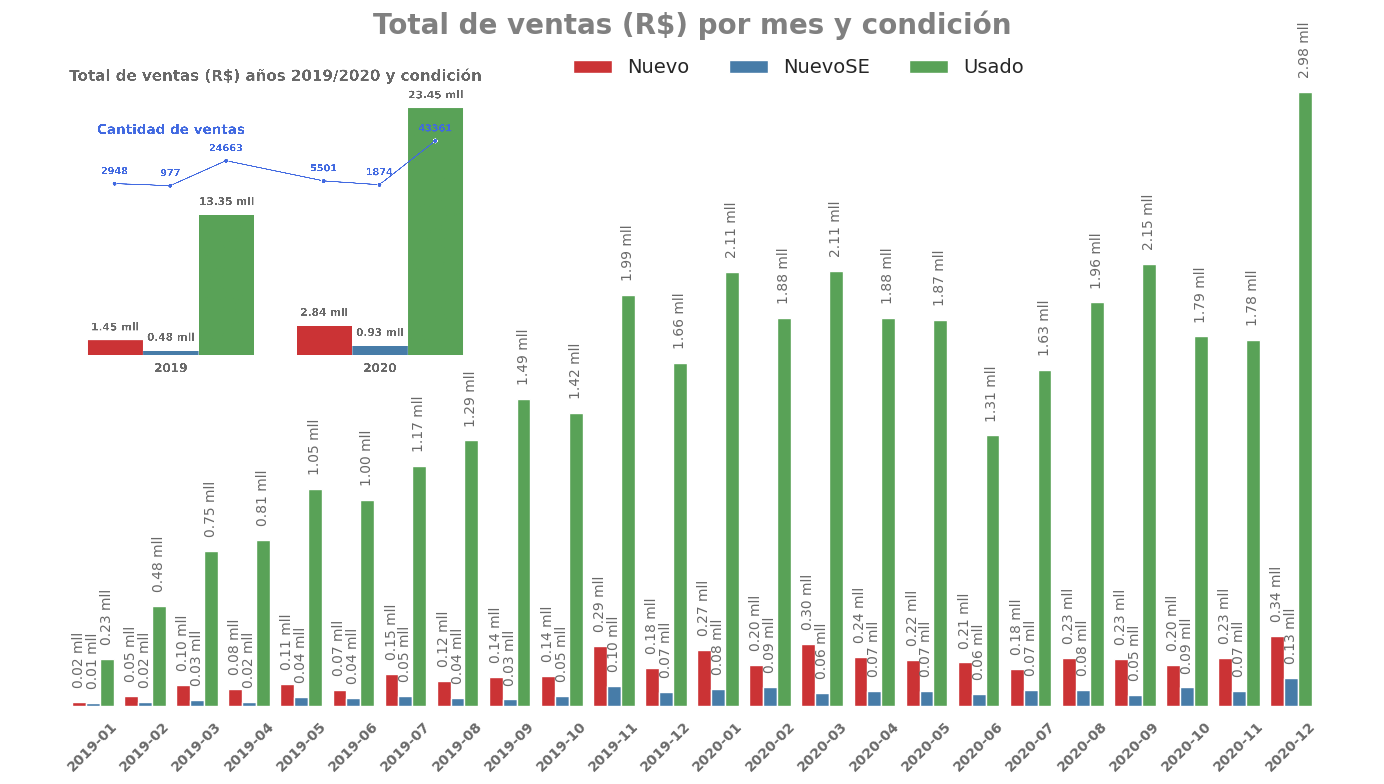

In [95]:
df=fechas_menores_2021.copy()
plt.figure(figsize=(14, 8))

ax=sns.barplot(data=df, x='year_mount', y='total_por_mes', hue='condicion',palette='Set1')
plt.title('Total de ventas (R$) por mes y condición',fontweight='bold', fontsize=20, color='gray',pad=20)
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=45,fontweight='bold', fontsize=10,color='dimgray')
x_pos=[]

for p,amount in zip(ax.patches,df.cantidad_vendida):
    x_pos.append(p.get_x())
    ax.annotate(f'{p.get_height()/1e6:.2f} mll', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', xytext=(0, 10), textcoords='offset points', fontsize=10,color='dimgray',rotation=90)

x_values1 = []
y_values1 = []
lista1=[]
for i in range(0, len(df)+1, 3):
    lista1.append(i)
for index, row in df.iterrows():
    if index in lista1:
      x_values1.append(row['year_mount'])
      y_values1.append(row['total_por_mes'])

legend_x = 0.4
legend_y = 0.99
plt.legend(title='', loc='center left', bbox_to_anchor=(legend_x, legend_y), frameon=False, fontsize=14, ncol=3)

plt.plot()
plt.box(None)
plt.yticks([])
# plt.ylim(0,3e7)
plt.tight_layout()
# Añadir la imagen graf pie (% cumulado)
img='/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/graf/graf_ventas_years2019_2020_condicion.png'
img_ventas = OffsetImage(plt.imread(img), zoom=.13)  # Ajusta el zoom según sea necesario
ab_ventas = AnnotationBbox(img_ventas, (3.5, 2.35e6), frameon=False, xycoords='data', boxcoords='data', pad=0, zorder=100)  # Ajusta las coordenadas según sea necesario
ax.add_artist(ab_ventas)

plt.show()

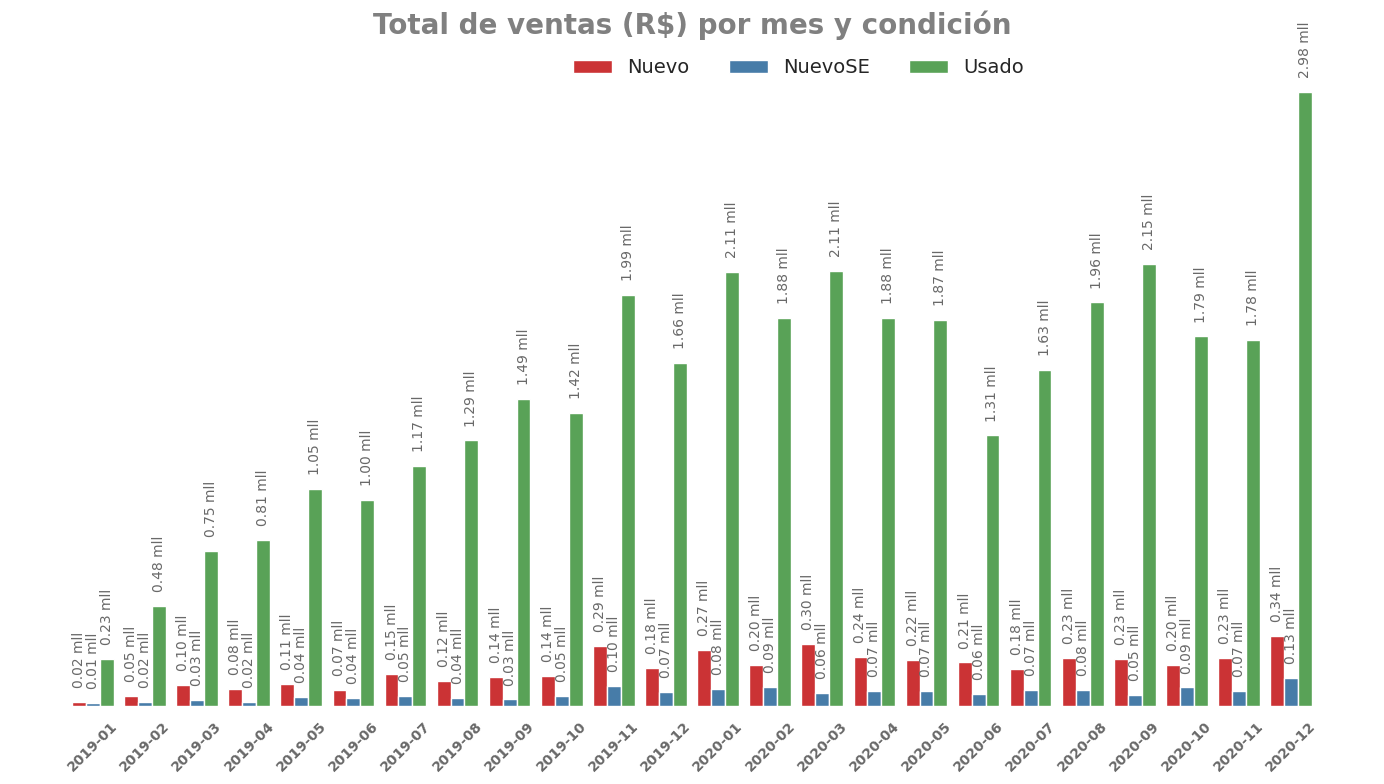

In [96]:
df=fechas_menores_2021.copy()
plt.figure(figsize=(14, 8),facecolor='none')

ax=sns.barplot(data=df, x='year_mount', y='total_por_mes', hue='condicion',palette='Set1')
plt.title('Total de ventas (R$) por mes y condición',fontweight='bold', fontsize=20, color='gray',pad=20)
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=45,fontweight='bold', fontsize=10,color='dimgray')
x_pos=[]

for p,amount in zip(ax.patches,df.cantidad_vendida):
    x_pos.append(p.get_x())
    ax.annotate(f'{p.get_height()/1e6:.2f} mll', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', xytext=(0, 10), textcoords='offset points', fontsize=10,color='dimgray',rotation=90)

x_values1 = []
y_values1 = []
lista1=[]
for i in range(0, len(df)+1, 3):
    lista1.append(i)
for index, row in df.iterrows():
    if index in lista1:
      x_values1.append(row['year_mount'])
      y_values1.append(row['total_por_mes'])

legend_x = 0.4
legend_y = 0.99
plt.legend(title='', loc='center left', bbox_to_anchor=(legend_x, legend_y), frameon=False, fontsize=14, ncol=3)

plt.plot()
plt.box(None)
plt.yticks([])
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/graf/ventas_condicion_mes_009.png', dpi=300, bbox_inches='tight')
plt.show()

###**En el año 2019 se observa un crecimiento continuo especialmente un gran volumnen de los productos usados, luego continúa un crecimiento con vaivenes, pero se desta en el gráfico por años, que en 2020 se produce un gran volumen de ingresos. No representamos el año 2021, porque sólo tenemos los tres primeros meses, y con ganancias decrecientes, no acordes a los datos del mercado general de Brasil (referencia: https://www.mordorintelligence.ar/industry-reports/brazil-ecommerce-market)**

In [97]:
###  SELECCION DE CANTIDAD DE COMPRAS POR AAAA-MM   ####

query_2_1122Y='''
SELECT
    strftime('%Y', pedidos.fecha_compra) AS year,
    CASE
        WHEN productos.condicion = 'Nuevo con etiqueta' THEN 'Nuevo'
        WHEN productos.condicion = 'Nuevo sin etiqueta' THEN 'NuevoSE'
        ELSE productos.condicion
    END AS condicion,    SUM(itens_pedidos.cantidad) AS cantidad_vendida,
    SUM(pedidos.total) AS total_por_mes
FROM
    pedidos
JOIN
    itens_pedidos ON pedidos.pedido_id = itens_pedidos.pedido_id
JOIN
    productos ON itens_pedidos.producto_id = productos.producto_id
GROUP BY
    year, productos.condicion
ORDER BY
    year, productos.condicion;

'''
df_query_2_1122Y = pd.read_sql_query(query_2_1122Y, database)
database.dispose()
df_query_2_1122Y.drop_duplicates(inplace=True)
df_query_2_1122Y

year condicion  cantidad_vendida  total_por_mes
0  2019     Nuevo              2948        1454385
1  2019   NuevoSE               977         484744
2  2019     Usado             24663       13348237
3  2020     Nuevo              5501        2841848
4  2020   NuevoSE              1874         931129
5  2020     Usado             43361       23454224
6  2021     Nuevo               791         428759
7  2021   NuevoSE               271         133987
8  2021     Usado              5388        2726617

###**Gráfica auxiliar de total de ventas por año y por condición:**

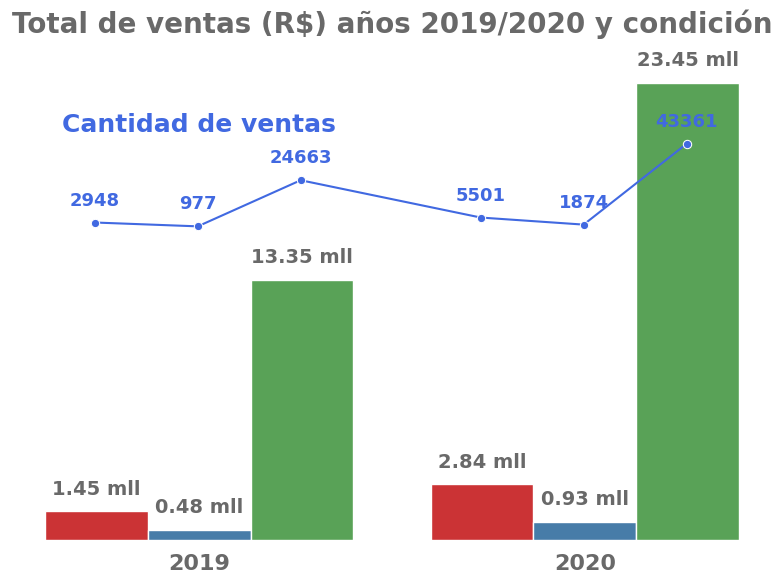

In [98]:
df=df_query_2_1122Y.head(6).copy()
# df=df.año_mes.astype(str)
plt.figure(figsize=(8, 6),facecolor='none')
ax=sns.barplot(data=df, x='year', y='total_por_mes', hue='condicion',palette='Set1')
plt.title('Total de ventas (R$) años 2019/2020 y condición',fontweight='bold', fontsize=20, color='dimgray',pad=20)
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=0,fontweight='bold', fontsize=16,color='dimgray')
x_pos=[]

for p,amount in zip(ax.patches,df.cantidad_vendida):
    x_pos.append(p.get_x())
    ax.annotate(f'{p.get_height()/1e6:.2f} mll', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', xytext=(0, 10), textcoords='offset points', fontsize=14,color='dimgray',rotation=0,fontweight='bold')

x_pos_order=sorted(x_pos)
x_values = []
y_values = []

# Cantidad de ventas
for amount, order in zip(df.cantidad_vendida, x_pos_order):
    ax.annotate(amount, (order+.13, amount * 100 + 16e6), ha='center', va='bottom', xytext=(0, 10), textcoords='offset points', fontweight='bold', fontsize=13, color='royalblue', rotation=0)
    x_values.append(order+.13)
    y_values.append(amount * 100 + 16e6)

# Trazar las líneas de cantidad de ventas
sns.lineplot(x=x_values, y=y_values, marker='o', markersize=6, linewidth=1.5, color='royalblue')
ax.annotate('Cantidad de ventas', (0, 20e6), ha='center', va='bottom', xytext=(0, 10), textcoords='offset points',fontweight='bold', fontsize=18,color='royalblue',rotation=0)
legend_x = .2
legend_y = 0.99
plt.legend(title='', loc='center left', bbox_to_anchor=(legend_x, legend_y), frameon=False, fontsize=12, ncol=3)
plt.legend([],frameon=False)
plt.plot()
plt.box(None)
plt.yticks([])
# plt.ylim(0,3e7)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/graf/graf_ventas_years2019_2020_condicion.png', dpi=300, bbox_inches='tight')
plt.show()

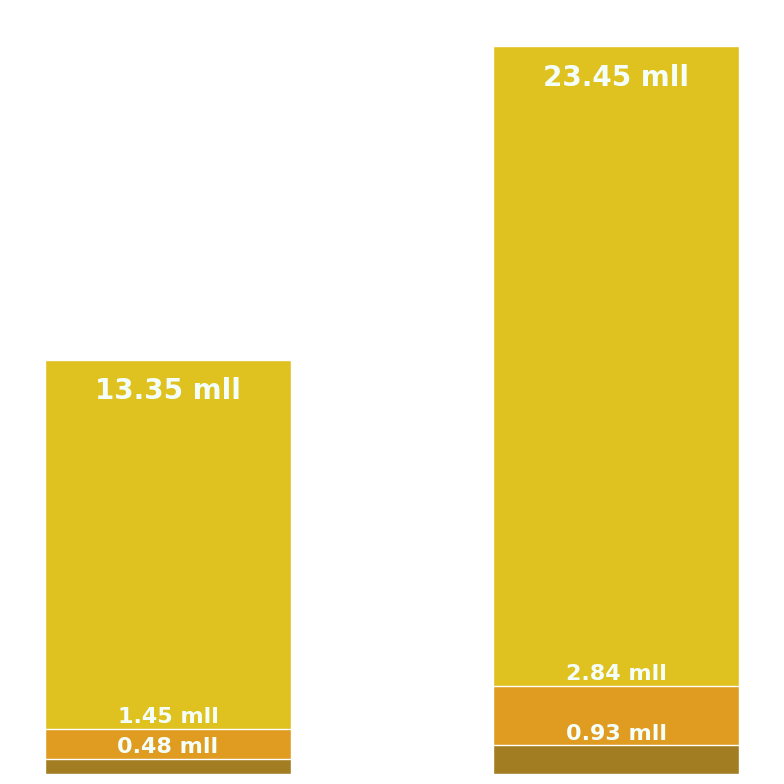

In [99]:
df=df_query_2_1122Y.head(6).copy()

# Pivotar los datos para tener barras apiladas por año
df = df.pivot(index='year', columns='condicion', values='total_por_mes').reset_index()

# Graficar las barras apiladas
plt.figure(figsize=(8, 8), facecolor='none')
ax = sns.barplot(data=df, x='year', y='Usado', color='gold', dodge=True,label='Usado', alpha=1, width=0.55)
ax = sns.barplot(data=df, x='year', y='Nuevo', color='orange', dodge=True,label='Nuevo', alpha=1, width=0.55)
ax = sns.barplot(data=df, x='year', y='NuevoSE', color='darkgoldenrod', dodge=True,label='NuevoSE', alpha=1, width=0.55)

# Anotar los valores de las barras
for p in ax.patches:
  if p.get_height()>10e6:
    ax.annotate(f'{p.get_height()/1e6:.2f} mll', (p.get_x() + p.get_width() / 2., p.get_height()-1e6),
                ha='center', va='top', xytext=(0, 10), textcoords='offset points', fontsize=20, color='mintcream',fontweight='bold')#khaki)
  else:
    ax.annotate(f'{p.get_height()/1e6:.2f} mll', (p.get_x() + p.get_width() / 2., p.get_height()-4e5),
                ha='center', va='bottom', xytext=(0, 10), textcoords='offset points', fontsize=16, color='mintcream',fontweight='bold')#khaki)

# Configurar título y ejes
# plt.title('Total de ventas (R$) años 2019/2020 y condición', fontweight='bold', fontsize=20, color='dimgray', pad=20)
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=0, fontweight='bold', fontsize=16, color='dimgray')
# plt.legend(frameon=False, ncol=3, loc='upper center')
plt.legend([],frameon=False)
plt.yticks([])
plt.xticks([])
plt.tight_layout()

# Guardar el gráfico como imagen
plt.savefig('graf_ventas_years2019_2020_condicion_01.png', dpi=300, bbox_inches='tight')

plt.plot()
plt.box(None)
plt.yticks([])
plt.show()


###**Fecha de transaccón de mayor ganancia**

In [100]:
df_query_2_11.fecha_compra.max()

'2021-03-10 00:00:00.000000'

In [101]:
fila_maxima = df_query_2.loc[df_query_2['total_ventas'].idxmax()]
fila_maxima

fecha_compra    2019-11-24 00:00:00.000000
total_ventas                      289960.8
Name: 323, dtype: object

###**Obtención de datos para graficar pie de fecha de mayor ganancia:**

In [102]:
# 2019-11-24 00:00:00.000000
df_time_max_value=df_query_2_11[df_query_2_11.fecha_compra=='2019-11-24 00:00:00.000000']

marca_ganancias_max_time=df_time_max_value.groupby('marca')['ganancia_neta'].sum()
df_marca_ganancias_max_time=pd.DataFrame(marca_ganancias_max_time)
df_marca_ganancias_max_time.sort_values(by='ganancia_neta',inplace=True,ascending=False)
df_marca_ganancias_max_time.head()

ganancia_neta
marca                      
Barbara Bela        20160.0
Givenchy            19200.0
Mixed               18683.2
Tory Burch          13904.0
Jimmy Choo          12432.0

<ipython-input-103-34e4f1f84ee5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.loc['Otros'] = otros


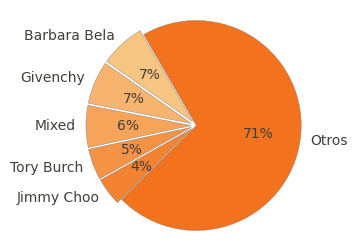

In [103]:
df=df_marca_ganancias_max_time.copy()

# Obtener las marcas que superan el 4% y sumar los porcentajes del resto
df_filtered = df[df['ganancia_neta'] > df['ganancia_neta'].sum() * 0.04]
otros = df[df['ganancia_neta'] <= df['ganancia_neta'].sum() * 0.04]['ganancia_neta'].sum()
df_filtered.loc['Otros'] = otros

# Crear el gráfico de pastel
plt.figure(figsize=(3, 3),facecolor='none')
# plt.title('Distribución de ganancias por marca')

# Utilizar colores predeterminados de Seaborn
colors = sns.color_palette("blend:#F7C582,#F2721D", len(df_filtered))
explode = [0.05,.05,.05,.05,.05,0]
wedgeprops = {'edgecolor': 'gray', 'linewidth': .3}
text_props = {'color': '#423E39', 'fontsize': 10}
plt.pie(df_filtered['ganancia_neta'],explode=explode, labels=df_filtered.index, colors=colors, autopct='%1.0f%%', startangle=120,textprops=text_props,wedgeprops=wedgeprops)

# Mostrar el gráfico
plt.axis('equal')  # Asegurar que el gráfico de pastel sea circular
plt.savefig('/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/graf/grafica_metrics_unique.png', dpi=100, bbox_inches='tight')

plt.show()


<ipython-input-281-c8a17530bc9d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.loc['Otros'] = otros


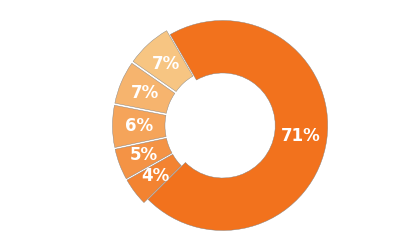

In [281]:
df=df_marca_ganancias_max_time.copy()

# Obtener las marcas que superan el 4% y sumar los porcentajes del resto
df_filtered = df[df['ganancia_neta'] > df['ganancia_neta'].sum() * 0.04]
otros = df[df['ganancia_neta'] <= df['ganancia_neta'].sum() * 0.04]['ganancia_neta'].sum()
df_filtered.loc['Otros'] = otros

# Crear el gráfico de pastel
plt.figure(figsize=(3, 3),facecolor='none')
# plt.title('Distribución de ganancias por marca')

# Utilizar colores predeterminados de Seaborn
colors = sns.color_palette("blend:#F7C582,#F2721D", len(df_filtered))
explode = [0.05,.05,.05,.05,.05,0]
wedgeprops = {'edgecolor': 'gray', 'linewidth': .3, 'width':.5}
text_props = {'color': 'white', 'fontsize': 12,'fontweight':'bold'}
plt.pie(df_filtered['ganancia_neta'],explode=explode, labels=df_filtered.index, colors=colors, autopct='%1.0f%%', startangle=120,textprops=text_props,wedgeprops=wedgeprops,pctdistance=0.75)
# Mostrar el gráfico
plt.axis('equal')  # Asegurar que el gráfico de pastel sea circular
plt.savefig('/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/graf/grafica_metrics_unique_white.png', dpi=100, bbox_inches='tight')

plt.show()


In [105]:
df = df_query_2.copy()
df['fecha_compra'] = pd.to_datetime(df['fecha_compra'])
df['año_mes'] = df['fecha_compra'].dt.to_period('M')
df['year'] = df['fecha_compra'].dt.to_period('Y')
mmm=df.groupby('year')['total_ventas'].sum()
# mmm=df.groupby('year')['total_ventas'].sum().reset_index()
df_mmm=pd.DataFrame(mmm)
df_mmm

total_ventas
year              
2019    12229892.8
2020    21781760.8
2021     2631490.4

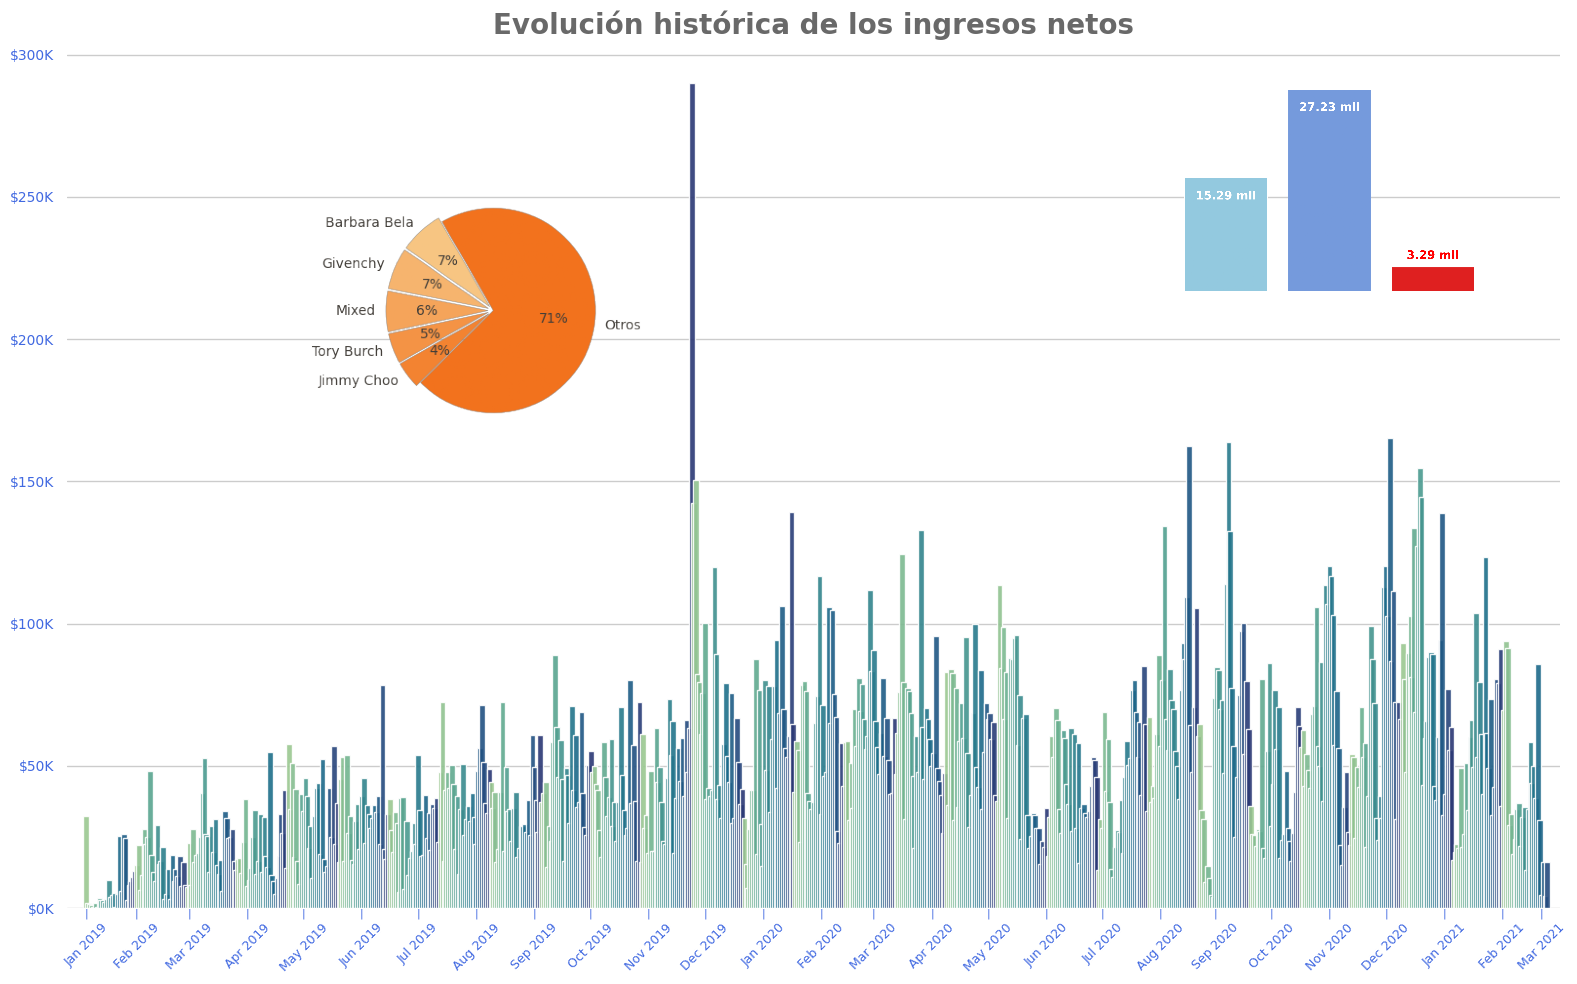

In [106]:
df = df_query_2.copy()

# Convertir la columna de fecha a tipo datetime
df['fecha_compra'] = pd.to_datetime(df['fecha_compra'])

# Obtener la columna de año y mes como una cadena de texto
df['año_mes'] = df['fecha_compra'].dt.strftime('%b %Y')

plt.figure(figsize=(16, 10),facecolor='none')
ax = plt.gca()  # Obtener el objeto de ejes

# Obtener las etiquetas únicas de año-mes
unique_labels = df['año_mes'].unique()
index = list(range(len(df)))

# Obtener los índices enteros para las etiquetas únicas de año-mes
index_labels = [df[df['año_mes'] == label].index.min() for label in unique_labels]

# Especificar la paleta de colores
palette = sns.color_palette("crest", len(unique_labels))
bar_width=3
plt.bar(index, df['total_ventas'], bar_width, color=palette, alpha=0.9)

# Definir la posición y las etiquetas del eje x
plt.xticks(index_labels, unique_labels, rotation=45, ha='center', fontsize=9, color='royalblue')

# Agregar | a los xticks:
for i, label in enumerate(unique_labels[:-1]):
    # print(index_labels[i])
    plt.annotate('|', xy=(index_labels[i], 0), xytext=(index_labels[i+1], 0), ha='center', va='top', fontsize=8, color='royalblue')
plt.annotate('|', xy=(0, 0), xytext=(0, 0), ha='center', va='top', fontsize=8, color='royalblue')

plt.xlabel('')
plt.ylabel('')
plt.title('Evolución histórica de los ingresos netos',fontsize=20,fontweight='bold', color='dimgray')
plt.grid(axis='x')
plt.tight_layout()
plt.xlim(index_labels[0]-10, index_labels[-1]+10)

# Dar formato a las etiquetas del eje y
formatter = FuncFormatter(lambda x, _: f'${int(x/1000)}K')
plt.gca().yaxis.set_major_formatter(formatter)
plt.yticks(fontsize=10,color='royalblue')
plt.box(None)

# Añadir la imagen graf pie (% cumulado)
img_pie='/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/graf/grafica_metrics_unique.png'
img_ventas = OffsetImage(plt.imread(img_pie), zoom=.7)  # Ajusta el zoom según sea necesario
ab_ventas = AnnotationBbox(img_ventas, (index_labels[7], 210000), frameon=False, xycoords='data', boxcoords='data', pad=0, zorder=100)  # Ajusta las coordenadas según sea necesario
ax.add_artist(ab_ventas)

# Añadir la imagen graf pie (% cumulado)
img_barra='/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/graf/graf_ventas_years2019_2020_total.png'
img_ventas_years = OffsetImage(plt.imread(img_barra), zoom=.1)  # Ajusta el zoom según sea necesario
ab_ventas = AnnotationBbox(img_ventas_years, (index_labels[22], 250000), frameon=False, xycoords='data', boxcoords='data', pad=0, zorder=100)  # Ajusta las coordenadas según sea necesario
ax.add_artist(ab_ventas)
plt.savefig('/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/graf/evolucion_ingresoso_010.png', dpi=300, bbox_inches='tight')

plt.show()


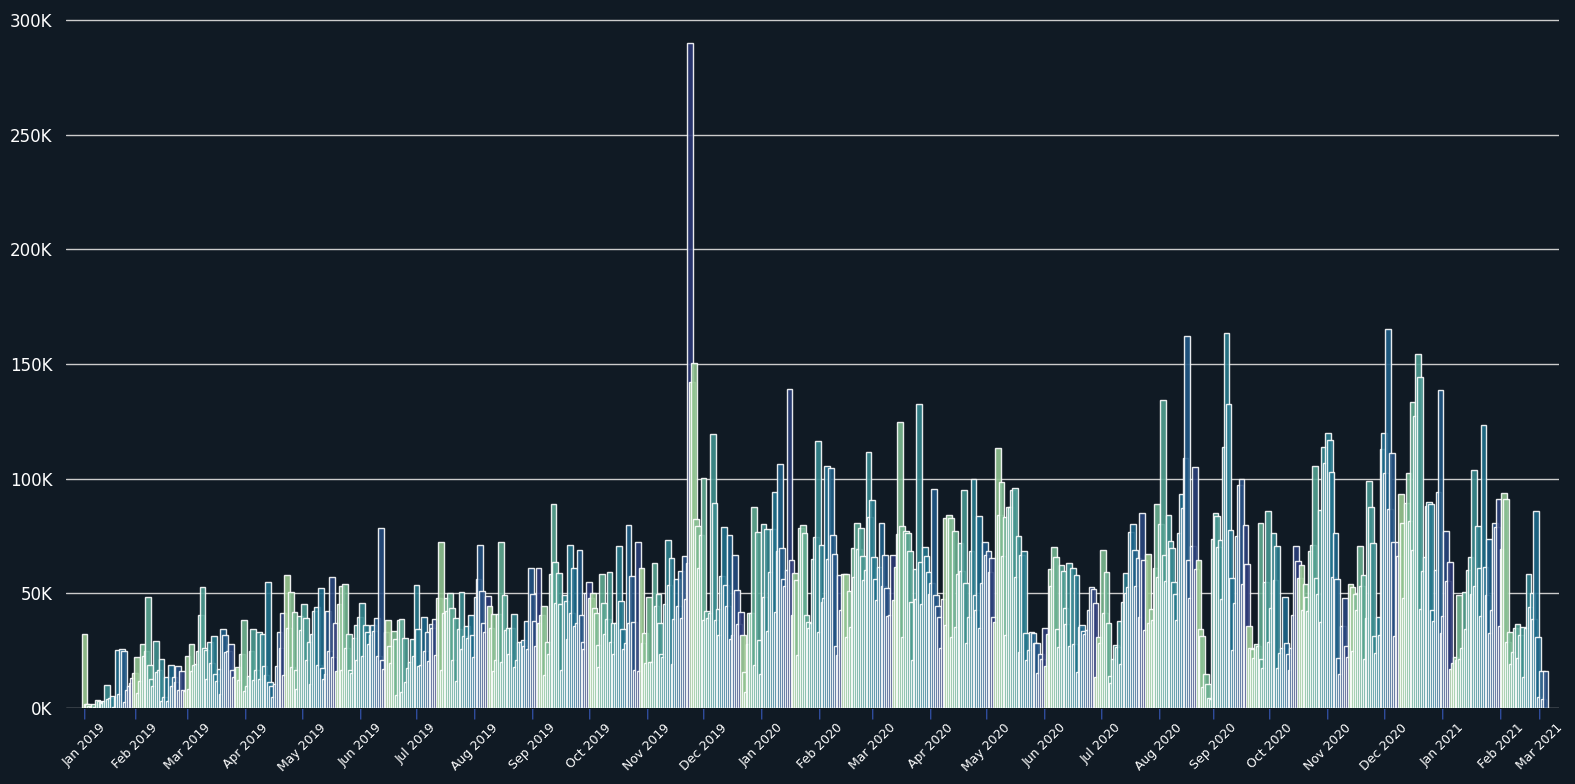

In [107]:
df = df_query_2.copy()

# Convertir la columna de fecha a tipo datetime
df['fecha_compra'] = pd.to_datetime(df['fecha_compra'])

# Obtener la columna de año y mes como una cadena de texto
df['año_mes'] = df['fecha_compra'].dt.strftime('%b %Y')

plt.figure(figsize=(16, 8),facecolor='#101a24')
ax = plt.gca()  # Obtener el objeto de ejes

# Obtener las etiquetas únicas de año-mes
unique_labels = df['año_mes'].unique()
index = list(range(len(df)))

# Obtener los índices enteros para las etiquetas únicas de año-mes
index_labels = [df[df['año_mes'] == label].index.min() for label in unique_labels]

# Especificar la paleta de colores
palette = sns.color_palette("crest", len(unique_labels))
bar_width=3
plt.bar(index, df['total_ventas'], bar_width, color=palette, alpha=0.9)

# Definir la posición y las etiquetas del eje x
plt.xticks(index_labels, unique_labels, rotation=45, ha='center', fontsize=9, color='white')

# Agregar | a los xticks:
for i, label in enumerate(unique_labels[:-1]):
    # print(index_labels[i])
    plt.annotate('|', xy=(index_labels[i], 0), xytext=(index_labels[i+1], 0), ha='center', va='top', fontsize=8, color='royalblue')
plt.annotate('|', xy=(0, 0), xytext=(0, 0), ha='center', va='top', fontsize=8, color='royalblue')

plt.xlabel('')
plt.ylabel('')
# plt.title('Evolución histórica de los ingresos netos',fontsize=20,fontweight='bold', color='dimgray')
plt.grid(axis='x')
plt.tight_layout()
plt.xlim(index_labels[0]-10, index_labels[-1]+10)

# Dar formato a las etiquetas del eje y
formatter = FuncFormatter(lambda x, _: f'{int(x/1000)}K')
plt.gca().yaxis.set_major_formatter(formatter)
plt.yticks(fontsize=12,color='white')
plt.box(None)

# Añadir la imagen graf pie (% cumulado)
# img_pie='/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/graf/grafica_metrics_unique.png'
# img_ventas = OffsetImage(plt.imread(img_pie), zoom=.95)  # Ajusta el zoom según sea necesario
# ab_ventas = AnnotationBbox(img_ventas, (index_labels[6], 230000), frameon=False, xycoords='data', boxcoords='data', pad=0, zorder=100)  # Ajusta las coordenadas según sea necesario
# ax.add_artist(ab_ventas)

# Añadir la imagen graf pie (% cumulado)
# img_barra='/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/graf/graf_ventas_years2019_2020_total.png'
# img_ventas_years = OffsetImage(plt.imread(img_barra), zoom=.15)  # Ajusta el zoom según sea necesario
# ab_ventas = AnnotationBbox(img_ventas_years, (index_labels[22], 240000), frameon=False, xycoords='data', boxcoords='data', pad=0, zorder=100)  # Ajusta las coordenadas según sea necesario
# ax.add_artist(ab_ventas)
plt.savefig('/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/graf/evolucion_ingresoso_010_bg101a24.png', dpi=300, bbox_inches='tight')

plt.show()


###**La evolución histórica de los ingresos muestra un crecimiento desde el inicio de año 2019 hasta el 2020. Se observa un máximo el día 24/nov/2019, en dondo la grafica circular representa el % de distribución de ingresos según la marca. Además observamos en la gráfica de ingresos totales por año como es el crecimiento desde el 2019 al 2020, pero en el 2021 se nota un descenso en los ingresos, pero al analizar los datos concluimos que los datos están sesgados y hay un decrecimiento desde enero a marzo, lo cúal es contradictorio a los datos del mercado (referencia: https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fwww.mordorintelligence.ar%2Findustry-reports%2Fbrazil-ecommerce-market)**

In [108]:
df_query_2_1122Y

year condicion  cantidad_vendida  total_por_mes
0  2019     Nuevo              2948        1454385
1  2019   NuevoSE               977         484744
2  2019     Usado             24663       13348237
3  2020     Nuevo              5501        2841848
4  2020   NuevoSE              1874         931129
5  2020     Usado             43361       23454224
6  2021     Nuevo               791         428759
7  2021   NuevoSE               271         133987
8  2021     Usado              5388        2726617

In [109]:
df_ganancias_totales_years=df_query_2_1122Y.groupby('year')['total_por_mes'].sum().reset_index()
df_ganancias_totales_years=df_ganancias_totales_years.rename(columns={'total_por_mes':'total'})
df_ganancias_totales_years

year     total
0  2019  15287366
1  2020  27227201
2  2021   3289363

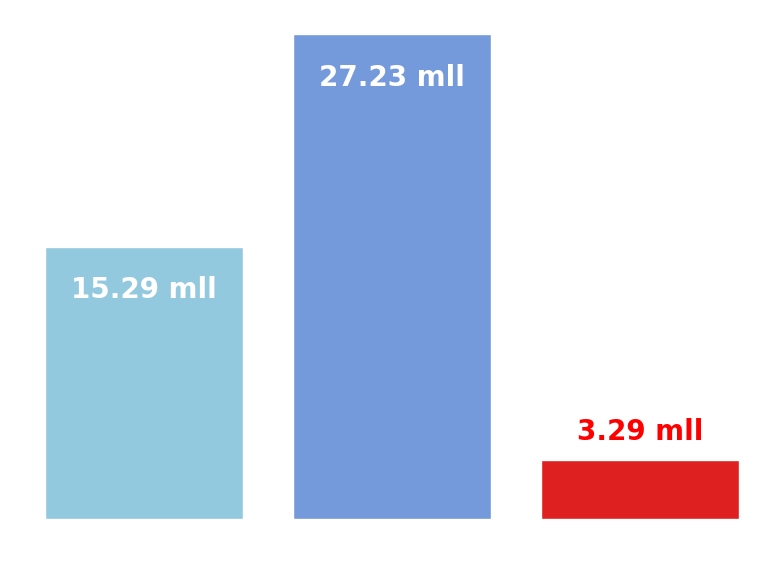

In [110]:
df=df_ganancias_totales_years.copy()

plt.figure(figsize=(8, 6),facecolor='none')
ax=sns.barplot(data=df, x='year', y='total', hue='total',palette=['red', 'skyblue','cornflowerblue'])
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=0,fontweight='bold', fontsize=30,color='white')
x_pos=[]

for p,amount in zip(ax.patches,df.total):
    if p.get_height()>10e6:
      ax.annotate(f'{p.get_height()/1e6:.2f} mll', (p.get_x() + p.get_width() / 2., p.get_height()-4e6), ha='center', va='bottom', xytext=(0, 10), textcoords='offset points', fontsize=20,color='white',rotation=0,fontweight='bold')
    else:
      ax.annotate(f'{p.get_height()/1e6:.2f} mll', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', xytext=(0, 10), textcoords='offset points', fontsize=20,color='red',rotation=0,fontweight='bold')

plt.legend([],frameon=False)
plt.plot()
plt.box(None)
plt.yticks([])
# plt.ylim(0,3e7)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/graf/graf_ventas_years2019_2020_total.png', dpi=300, bbox_inches='tight')
plt.show()

##**Pregunta 3: ¿Cuáles son los ingresos netos por vendedor por año?**

In [111]:
query_3='''
SELECT
    v.nombre_vendedor,
    SUM(CASE WHEN strftime('%Y', p.fecha_compra) = '2019' THEN p.total - ip.costo_envio ELSE 0 END) AS "Año 2019",
    SUM(CASE WHEN strftime('%Y', p.fecha_compra) = '2020' THEN p.total - ip.costo_envio ELSE 0 END) AS "Año 2020",
    SUM(CASE WHEN strftime('%Y', p.fecha_compra) = '2021' THEN p.total - ip.costo_envio ELSE 0 END) AS "Año 2021"
FROM
    pedidos p
JOIN
    vendedores v ON p.vendedor_id = v.vendedor_id
JOIN
    itens_pedidos ip ON p.pedido_id = ip.pedido_id
GROUP BY
    v.nombre_vendedor;
'''
df_query_3 = pd.read_sql_query(query_3, database)
database.dispose()
df_query_3

nombre_vendedor   Año 2019   Año 2020  Año 2021
0       Ana Duarte  2154261.6  5054009.6  547470.4
1  Daniel Siqueira  2020503.2  5266932.8  419702.4
2  Millena Pereira  2054682.4  3804385.6  398896.0
3   Nadia Oliveira  2296986.4  4046902.4  810020.0
4    Paulo Calanca  3702835.2  3609530.4  455401.6

In [112]:
df_query_3.nombre_vendedor.unique()

array(['Ana Duarte', 'Daniel Siqueira', 'Millena Pereira',
       'Nadia Oliveira', 'Paulo Calanca'], dtype=object)

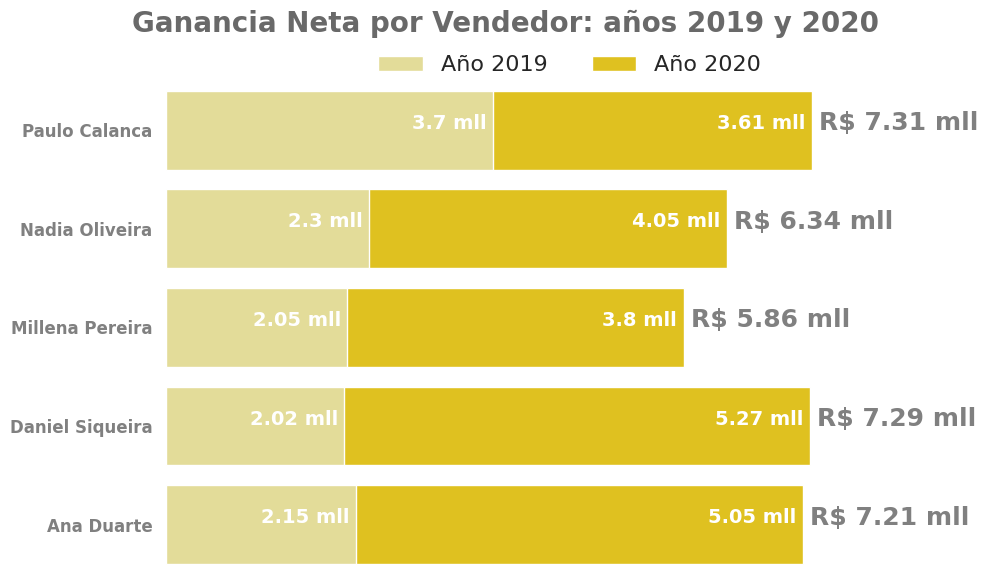

In [113]:
df = df_query_3.copy()
df['Total'] = df['Año 2019'] + df['Año 2020']

plt.subplots(figsize=(10, 6),facecolor='none')

ax = sns.barplot(data=df, y='nombre_vendedor', x='Total', errorbar=None, dodge=False,label='Año 2020',color='gold')
ax1 = sns.barplot(data=df, y='nombre_vendedor', x='Año 2019', errorbar=None, dodge=False,label='Año 2019',color='khaki')

plt.xlabel('')
plt.ylabel('')
plt.title('Ganancia Neta por Vendedor: años 2019 y 2020', fontsize=20, color='dimgray', fontweight='bold', pad=35)
plt.gca().invert_yaxis()

# Mostrar los valores en las barras para el año 2019
for p in ax1.patches:
    if p.get_width() <4e6:
        ax1.annotate(f'{str(round(p.get_width()/1e6, 2))} mll  ', (p.get_width(), p.get_y() + p.get_height() / 2), xytext=(5, 5), textcoords='offset points', ha='right', va='center', color='white', fontsize=14, fontweight='bold')
    if p.get_width() >5.5e6:
        ax1.annotate(f'R$ {str(round(p.get_width()/1e6, 2))} mll', (p.get_width(), p.get_y() + p.get_height() / 2), xytext=(5, 5), textcoords='offset points', ha='left', va='center', color='grey', fontsize=18, fontweight='bold')

for p,valor_2020 in zip(ax1.patches,df['Año 2020']):
    # if (p.get_width() >4e6) & (p.get_width() <5.5e6) :
        ax1.annotate(f'{str(round(valor_2020/1e6, 2))} mll  ', (p.get_width(), p.get_y() + p.get_height() / 2), xytext=(5, 5), textcoords='offset points', ha='right', va='center', color='white', fontsize=14, fontweight='bold')

plt.xticks([])
plt.yticks(color='gray', fontsize=12, fontweight='bold')
plt.grid(False)
plt.box(False)

handles, labels = ax.get_legend_handles_labels()
handles.reverse()
labels.reverse()
ax.legend(title='',handles=handles,labels=labels, bbox_to_anchor=(0.3, 1.07), loc='upper left', borderaxespad=0., ncol=3, frameon=False,fontsize=16)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/graf/vendedor_ganancia_2019and2020.png', dpi=300)
plt.show()


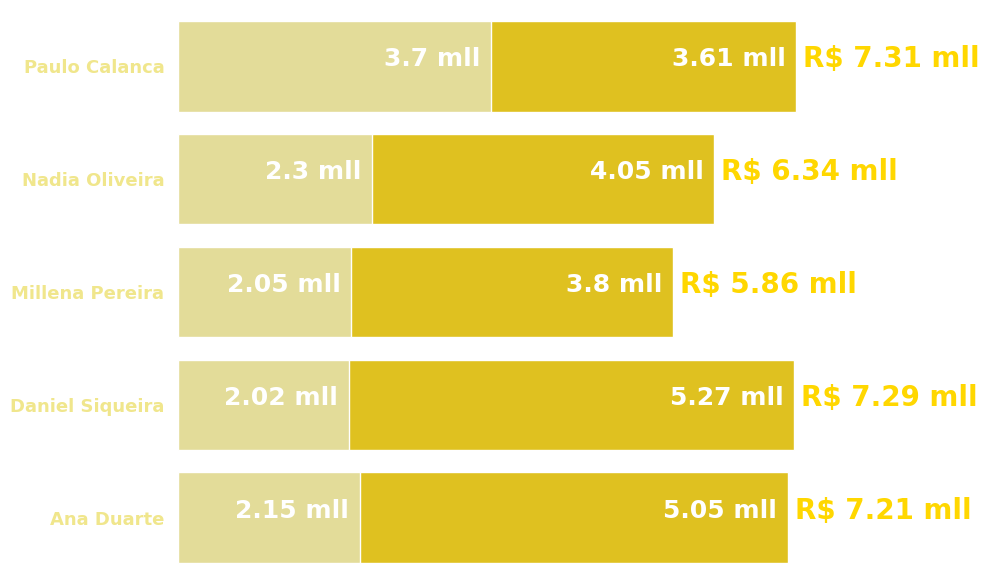

In [114]:
df = df_query_3.copy()
df['Total'] = df['Año 2019'] + df['Año 2020']

plt.subplots(figsize=(10, 6),facecolor='none')

ax = sns.barplot(data=df, y='nombre_vendedor', x='Total', errorbar=None, dodge=False,label='Año 2020',color='gold')
ax1 = sns.barplot(data=df, y='nombre_vendedor', x='Año 2019', errorbar=None, dodge=False,label='Año 2019',color='khaki')

plt.xlabel('')
plt.ylabel('')
# plt.title('Ganancia Neta por Vendedor: años 2019 y 2020', fontsize=20, color='dimgray', fontweight='bold', pad=35)
plt.gca().invert_yaxis()

# Mostrar los valores en las barras para el año 2019
for p in ax1.patches:
    if p.get_width() <4e6:
        ax1.annotate(f'{str(round(p.get_width()/1e6, 2))} mll  ', (p.get_width(), p.get_y() + p.get_height() / 2), xytext=(5, 5), textcoords='offset points', ha='right', va='center', color='white', fontsize=18, fontweight='bold')
    if p.get_width() >5.5e6:
        ax1.annotate(f'R$ {str(round(p.get_width()/1e6, 2))} mll', (p.get_width(), p.get_y() + p.get_height() / 2), xytext=(5, 5), textcoords='offset points', ha='left', va='center', color='gold', fontsize=20, fontweight='bold')

for p,valor_2020 in zip(ax1.patches,df['Año 2020']):
    # if (p.get_width() >4e6) & (p.get_width() <5.5e6) :
        ax1.annotate(f'{str(round(valor_2020/1e6, 2))} mll  ', (p.get_width(), p.get_y() + p.get_height() / 2), xytext=(5, 5), textcoords='offset points', ha='right', va='center', color='white', fontsize=18, fontweight='bold')

plt.xticks([])
plt.yticks(color='khaki', fontsize=13, fontweight='bold')
plt.grid(False)
plt.box(False)

handles, labels = ax.get_legend_handles_labels()
handles.reverse()
labels.reverse()
# ax.legend(title='',handles=handles,labels=labels, bbox_to_anchor=(0.3, 1.07), loc='upper left', borderaxespad=0., ncol=3, frameon=False,fontsize=16)
ax.legend([],frameon=False)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/graf/vendedor_ganancia_2019and2020_bg101a24.png', dpi=300)
plt.show()


###**En la gráfica podemos destacar al vendedor Calanca que generó mayores ganancias netas en el período en cuestión: años 2019 y 2020, pero por otra parte es el que menos ganacias generó en en 2020, lo cual sugiere una disminución de su esfuerzo. En 2020 se destaca Siqueira con 5.27 mll, casi todos duplicaron las ventas en 2020 a excepción de Calanca.**
###**El año 2021 fue excluido por razones anteiormente consideras, ya que no aportaría para una mejor interpretación de los datos.**

##**Pregunta 4: ¿Cuáles son las ciudades que proporcionan mayores ingresos netos?**

In [115]:
query_4='''
SELECT
    ip.ciudad,
    REPLACE(ip.ciudad, 'BR-', '') AS abbrev_state,
    SUM(p.total - ip.costo_envio) AS ingresos_netos
FROM
    pedidos p
JOIN
    itens_pedidos ip ON p.pedido_id = ip.pedido_id
GROUP BY
    ip.ciudad;
'''
df_query_4 = pd.read_sql_query(query_4, database)
database.dispose()
df_query_4.sort_values(by='ingresos_netos',inplace=True,ascending=False)
df_query_4['ciudad'] = df_query_4['abbrev_state'].map(ciudades)
df_query_4.head()

ciudad abbrev_state  ingresos_netos
1          Alagoas           AL       1522016.0
15      Pernambuco           PE       1509197.6
23  Santa Catarina           SC       1476962.4
3            Amapá           AP       1475737.6
5            Ceará           CE       1468080.8

In [116]:
df_population.head(1)

Estado ISO 3166-2     Capital Area (km²)  Population Density (pers/km²)
0   Acre      BR-AC  Rio Branco    153 150      830026                542

###**Obtener dataframe de población y agregar columna de cod abreviado:**

In [117]:
df_population['abbrev_state']= [ciudad.replace('BR-', '') for ciudad in df_population['ISO 3166-2']]
df_population.head(1)

Estado ISO 3166-2     Capital Area (km²)  Population Density (pers/km²)  \
0   Acre      BR-AC  Rio Branco    153 150      830026                542   

  abbrev_state  
0           AC

###**PBI per Cápita**

In [118]:
url = "https://es.wikipedia.org/wiki/Anexo:Estados_de_Brasil_por_PIB_per_c%C3%A1pita_(nominal)"

tablas = pd.read_html(url)
tabla = tablas[0]
df_data_brasil=pd.DataFrame(tabla)
df_data_brasil.head(5)

N.º            Unidad        Región PIB per cápita                        \
  N.º            Unidad        Región            BRL    USD    PPA       %   
0   1  Distrito Federal  Centro-Oeste         119649  23181  46304  245.04   
1   2         São Paulo       Sudeste          72647  14075  28114  148.78   
2   —           Sudeste       Sudeste          61828  11979  23927  126.62   
3   —      Centro-Oeste  Centro-Oeste          60454  11713  23396  123.81   
4   3    Santa Catarina           Sur          59872  11600  23170  122.62   

  PIB (BRL) Población (2022) Comparable (USD) Comparable (PPA)  
  PIB (BRL) Población (2022) Comparable (USD) Comparable (PPA)  
0    337060          2817068             Omán         Lituania  
1   3227031         44420459            Chile          Uruguay  
2   5245944         84847187       Kazajistán           México  
3    984671         16287809       Kazajistán           México  
4    455600          7609601       Kazajistán           México

In [119]:
region=df_data_brasil['Región']
estado=df_data_brasil['Unidad']
PBI=df_data_brasil['PIB per cápita']
poblacion=df_data_brasil['Población (2022)']
df_data_brasil_pbi_pop_state = pd.concat([region,estado,PBI,poblacion],axis=1)
df_data_brasil_pbi_pop_state.head(5)

Región            Unidad     BRL    USD    PPA       %  \
0  Centro-Oeste  Distrito Federal  119649  23181  46304  245.04   
1       Sudeste         São Paulo   72647  14075  28114  148.78   
2       Sudeste           Sudeste   61828  11979  23927  126.62   
3  Centro-Oeste      Centro-Oeste   60454  11713  23396  123.81   
4           Sur    Santa Catarina   59872  11600  23170  122.62   

   Población (2022)  
0           2817068  
1          44420459  
2          84847187  
3          16287809  
4           7609601

In [120]:
df_regiones_bpi=df_data_brasil_pbi_pop_state.groupby('Región')[['USD','Población (2022)']].sum().reset_index()
df_regiones_bpi = df_regiones_bpi.drop(df_regiones_bpi.index[3])
df_regiones_bpi['Población_2022_mll']=(df_regiones_bpi['Población (2022)']/1e6).round(2)
df_regiones_bpi['USD_K']=(df_regiones_bpi['USD']/1e3).round(2)
df_regiones_bpi.drop(columns=['Población (2022)','USD'],axis=1,inplace=True)
df_regiones_bpi['Región'] = df_regiones_bpi['Región'].replace({'Centro-Oeste': 'Centro Oeste', 'Sur': 'Sul'})
df_regiones_bpi.rename(columns={'USD_K':'PBI_USD_K'},inplace=True)
df_regiones_bpi

Región  Población_2022_mll  PBI_USD_K
0  Centro Oeste               32.58      64.68
1      Nordeste              106.16      48.38
2         Norte               34.70      52.88
4       Sudeste              169.69      54.84
5           Sul               59.87      44.13

In [121]:
# df_query_5.to_csv('/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/DDBB/df_all_ddbb.csv',index=False)

In [122]:
df_all_ddbb=pd.read_csv('/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/DDBB/df_all_ddbb.csv')
df_all_ddbb.head(1)

pedido_id  producto_id  vendedor_id fecha_compra  total  id_recibo  \
0          1         5292            2   2020-02-16   3456      10062   

   cantidad  valor_unitario  valor_total ciudad  costo_envio  ganancia_neta  \
0         6             576         3456  BR-PE        691.2         2764.8   

            producto  precio  marca       sku           condicion  \
0  Saia Jeans Forest   576.0  Mixed  222683.0  Nuevo con etiqueta   

   nombre_vendedor abbrev_state  code_state  name_state  code_region  \
0  Daniel Siqueira           PE        26.0  Pernambuco          2.0   

  name_region                                           geometry  
0    Nordeste  MULTIPOLYGON (((-32.397046285111486 -3.8329364...

In [123]:
df_region_ganancia=df_all_ddbb.groupby('name_region')['ganancia_neta'].sum().reset_index()
df_region_ganancia['Región']= df_region_ganancia['name_region']
df_region_ganancia['ganancia_neta_mll']= (df_region_ganancia['ganancia_neta']/1e6).round(2)
df_region_ganancia

name_region  ganancia_neta        Región  ganancia_neta_mll
0  Centro Oeste      5330101.6  Centro Oeste               5.33
1      Nordeste     12731552.8      Nordeste              12.73
2         Norte      9145798.4         Norte               9.15
3       Sudeste      5329470.4       Sudeste               5.33
4           Sul      4105596.8           Sul               4.11

In [124]:
df_region_ganancia_pbi_pop = df_regiones_bpi.merge(df_region_ganancia, on='Región')
df_region_ganancia_pbi_pop.sort_values(by='Población_2022_mll',ascending=False,inplace=True)
df_region_ganancia_pbi_pop

Región  Población_2022_mll  PBI_USD_K   name_region  ganancia_neta  \
3       Sudeste              169.69      54.84       Sudeste      5329470.4   
1      Nordeste              106.16      48.38      Nordeste     12731552.8   
4           Sul               59.87      44.13           Sul      4105596.8   
2         Norte               34.70      52.88         Norte      9145798.4   
0  Centro Oeste               32.58      64.68  Centro Oeste      5330101.6   

   ganancia_neta_mll  
3               5.33  
1              12.73  
4               4.11  
2               9.15  
0               5.33

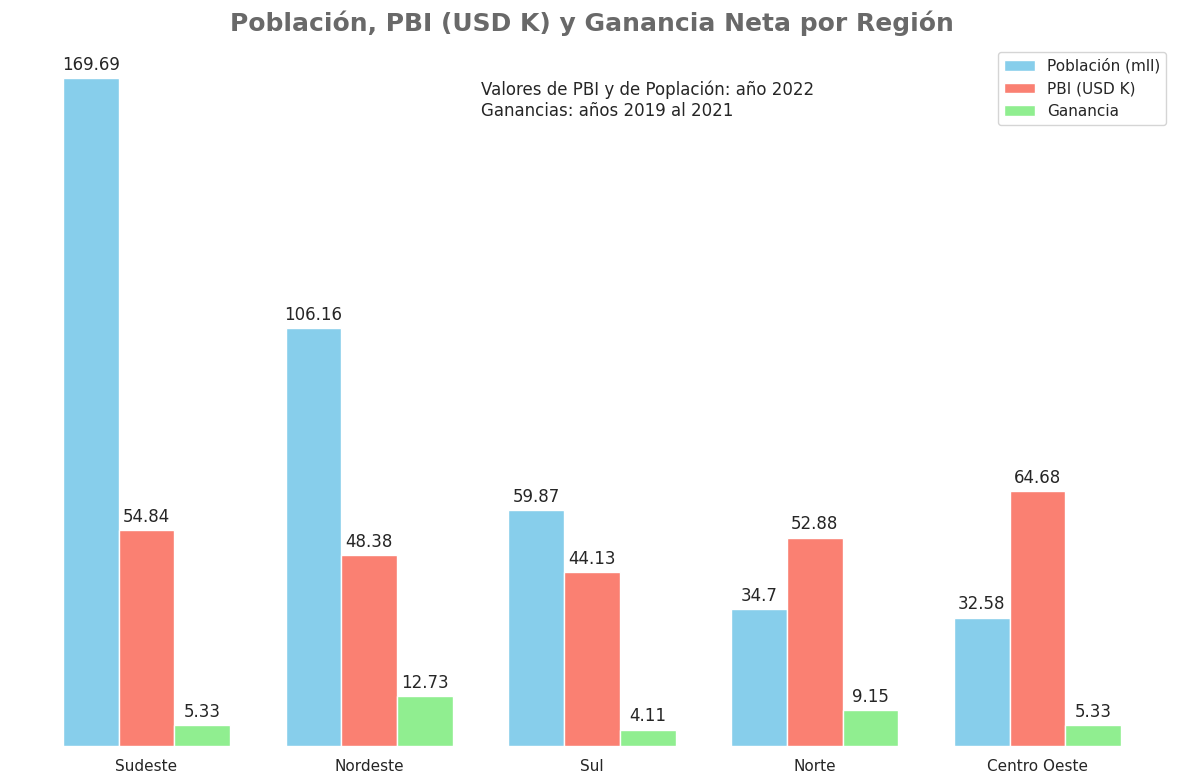

In [125]:
df = df_region_ganancia_pbi_pop.copy()

# Extraer los datos necesarios
regiones = df['Región']
poblacion = df['Población_2022_mll']
usd_k = df['PBI_USD_K']
ganancia = df['ganancia_neta_mll']

# Definir el ancho de las barras
bar_width = 0.25

# Generar las posiciones para las barras
x = np.arange(len(regiones))

# Crear el gráfico de barras
fig, ax = plt.subplots(figsize=(12, 8),facecolor='none')

bar1 = ax.bar(x - bar_width, poblacion, bar_width, label='Población (mll)', color='skyblue')
bar2 = ax.bar(x, usd_k, bar_width, label='PBI (USD K)', color='salmon')
bar3 = ax.bar(x + bar_width, ganancia, bar_width, label='Ganancia', color='lightgreen')

# Agregar valores en la parte superior de las barras
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # Desplazamiento vertical de la etiqueta
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bar1)
autolabel(bar2)
autolabel(bar3)

# Configurar las etiquetas de los ejes y el título
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Población, PBI (USD K) y Ganancia Neta por Región',fontsize=18,color='dimgray',fontweight='bold',pad=10)
ax.set_xticks(x)
ax.set_yticks([])
ax.set_xticklabels(regiones, rotation=0)
ax.annotate(f'Valores de PBI y de Poplación: año 2022\nGanancias: años 2019 al 2021',xy=(1.5, 160))
ax.legend()

plt.grid(False)
plt.box(False)
plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/graf/pop_pbi_ganancia.png', dpi=300)
plt.show()


In [126]:
df_population_reg=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/poblacion_por_region_brasil_2022.csv')
df_population_reg.head()

Region  Population
0      N    17355778
1    C-O    16289538
2    N-E    54657621
3    S-E    84840113
4      S    29937706

###**Unir dataframe de  query 4 con df_population:**

In [127]:
df_query_4 = df_query_4.merge(df_population, on='abbrev_state')
df_query_4.head(1)

ciudad abbrev_state  ingresos_netos   Estado ISO 3166-2 Capital  \
0  Alagoas           AL       1522016.0  Alagoas      BR-AL  Maceió   

  Area (km²)  Population Density (pers/km²)  
0     27 933     3127511              11196

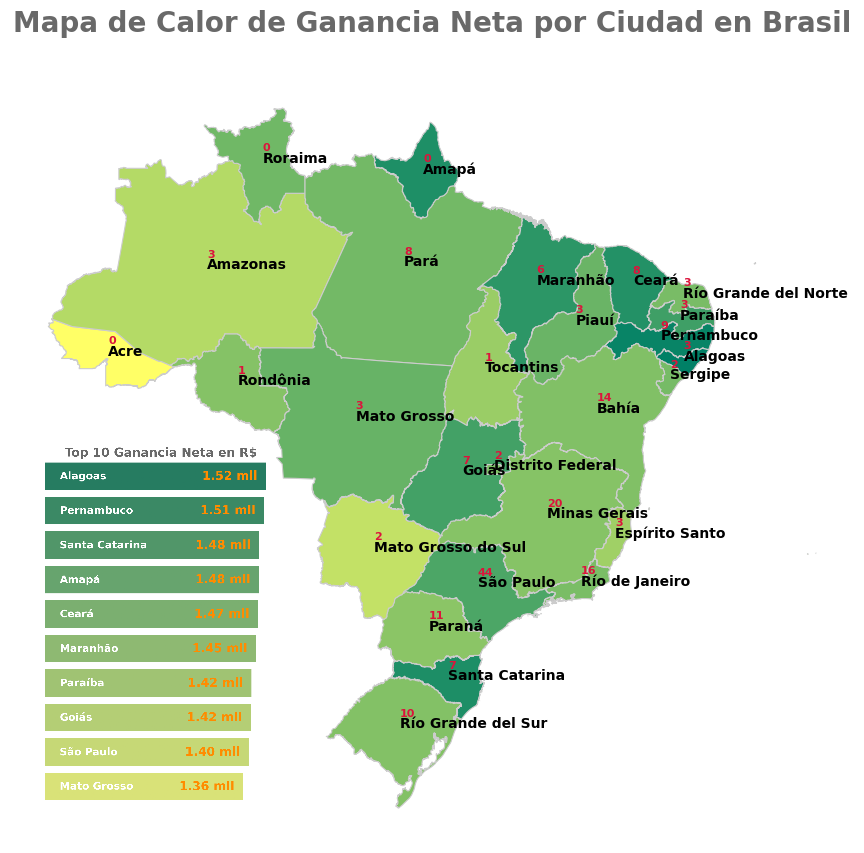

In [128]:
df=df_query_4.copy()

br_uf = geobr.read_state()
br_uf_d = br_uf.merge(df_query_4, on='abbrev_state')
br_uf_d = br_uf_d[['geometry','abbrev_state', 'ingresos_netos','Population']]
br_uf_d['state'] = br_uf_d['abbrev_state'].map(ciudades)
br_uf_d_projected = br_uf_d.to_crs('EPSG:3857')

fig, ax = plt.subplots(1, 1, figsize=(15, 10),facecolor='none')
br_uf_d_projected.plot(column='ingresos_netos', cmap='summer_r', linewidth=0.8, ax=ax, edgecolor='0.8', legend=False)

# Agregar el nombre de la ciudad en cada lugar
# for x, y, label, pop in zip(br_uf_d_projected.geometry.centroid.x, br_uf_d_projected.geometry.centroid.y, br_uf_d_projected.state,br_uf_d_projected.Population):
#     ax.annotate(f'{label}\n', xy=(x, y), xytext=(20, 15), textcoords="offset points", fontsize=10, color='black', fontweight='bold')
#     ax.annotate(f' {(pop/1e6):.1f}mll hab', xy=(x, y), xytext=(20, 18), textcoords="offset points", fontsize=9, color='crimson')

for x, y, label, pop in zip(br_uf_d_projected.geometry.centroid.x, br_uf_d_projected.geometry.centroid.y, br_uf_d_projected.state, br_uf_d_projected.Population):
    ax.annotate(f'{int(pop/1e6)}\n', xy=(x, y), xytext=(0, 0), textcoords="offset points", fontsize=8, color='crimson',fontweight='bold')
    ax.annotate(f'{label}', xy=(x, y), xytext=(0, 0), textcoords="offset points", fontsize=10, color='black', fontweight='bold')
    # ax.annotate(f'{" "*len(label)*2}{(pop/1e6):.0f}', xy=(x, y), xytext=(0, 0), textcoords="offset points", fontsize=9, color='crimson')


plt.title('Mapa de Calor de Ganancia Neta por Ciudad en Brasil', fontsize=20, color='dimgray', fontweight='bold', pad=30)
plt.axis('off')

# Ajustar la posición de la imagen
graf = '/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/graf/top10_state_ganancia.png'
graf_gan = OffsetImage(plt.imread(graf), zoom=0.15)
ab_graf = AnnotationBbox(graf_gan, (-7.5e6, -2.8e6), frameon=False, xycoords='data', boxcoords='data', pad=0, zorder=100)
plt.gca().add_artist(ab_graf)
plt.savefig('/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/graf/mapa_BR_ganancia.png', dpi=300)
plt.show()

###**Obervamos en este gráfico, como es la distribucíón geográfica según las ganancias netas por Estados, mostrando el top 10 comenzando por Alagoas. Podemos destacar La región NortEste con cierta concentración de estados con más ganancias: y al Sur el Estado de Santa Catarina.**

# INSIGHT

In [129]:
list_ddbb=['pedidos','itens_pedidos','productos','vendedores']
def ver_ddbb():
  for ddbb in list_ddbb:
    query=f'''
    SELECT * FROM {ddbb}
    '''
    df=pd.read_sql_query(query,database)
    print(df.columns.values)
    print('------------')
ver_ddbb()

['pedido_id' 'producto_id' 'vendedor_id' 'fecha_compra' 'total']
------------
['id_recibo' 'producto_id' 'pedido_id' 'cantidad' 'valor_unitario'
 'valor_total' 'ciudad' 'costo_envio' 'ganancia_neta']
------------
['producto_id' 'producto' 'precio' 'marca' 'sku' 'condicion']
------------
['vendedor_id' 'nombre_vendedor']
------------


In [130]:
query_5='''
SELECT
    pedidos.*,
    itens_pedidos.id_recibo,
    itens_pedidos.cantidad,
    itens_pedidos.valor_unitario,
    itens_pedidos.valor_total,
    itens_pedidos.ciudad,
    itens_pedidos.costo_envio,
    itens_pedidos.ganancia_neta,
    productos.producto,
    productos.precio,
    productos.marca,
    productos.sku,
    productos.condicion,
    vendedores.nombre_vendedor
FROM
    pedidos
JOIN
    itens_pedidos ON pedidos.pedido_id = itens_pedidos.pedido_id
JOIN
    productos ON itens_pedidos.producto_id = productos.producto_id
JOIN
    vendedores ON pedidos.vendedor_id = vendedores.vendedor_id
GROUP BY
    pedidos.pedido_id;
'''
df_query_5 = pd.read_sql_query(query_5, database)
database.dispose()
df_query_5.head(1)

pedido_id  producto_id  vendedor_id                fecha_compra  total  \
0          1         5292            2  2020-02-16 00:00:00.000000   3456   

   id_recibo  cantidad  valor_unitario  valor_total ciudad  costo_envio  \
0      10062         6             576         3456  BR-PE        691.2   

   ganancia_neta           producto  precio  marca       sku  \
0         2764.8  Saia Jeans Forest   576.0  Mixed  222683.0   

            condicion  nombre_vendedor  
0  Nuevo con etiqueta  Daniel Siqueira

###**Agregar columna de nombres de Estados y geolocalización:**

In [131]:
df_query_5['abbrev_state']= [ciudad.replace('BR-', '') for ciudad in df_query_5.ciudad]
df_query_5['fecha_compra'] = pd.to_datetime(df_query_5['fecha_compra']).dt.strftime('%Y-%m-%d')
df_query_5 = df_query_5.merge(br_uf, on='abbrev_state')
df_query_5.head()

pedido_id  producto_id  vendedor_id fecha_compra  total  id_recibo  \
0          1         5292            2   2020-02-16   3456      10062   
1        107        41189            2   2020-01-17    800       8839   
2        210        10086            1   2020-02-25   4500      10466   
3        356        56571            1   2019-12-25    420       8015   
4        434        40082            4   2019-12-11   1260       7600   

   cantidad  valor_unitario  valor_total ciudad  costo_envio  ganancia_neta  \
0         6             576         3456  BR-PE        691.2         2764.8   
1         5             160          800  BR-PE        160.0          640.0   
2         6             750         4500  BR-PE        900.0         3600.0   
3         1             420          420  BR-PE         84.0          336.0   
4         4             315         1260  BR-PE        252.0         1008.0   

                producto  precio           marca       sku  \
0      Saia Jeans Forest   576.0           Mixed  222683.0   
1  Calca Acetinada Preta   160.0            Zara  176893.0   
2           Oculos Metal   750.0  Christian Dior  319314.0   
3    Vestido Seda Floral   420.0         Animale  178553.0   
4   Vestido Malha Vitral   315.0           Forum  324684.0   

            condicion  nombre_vendedor abbrev_state  code_state  name_state  \
0  Nuevo con etiqueta  Daniel Siqueira           PE        26.0  Pernambuco   
1               Usado  Daniel Siqueira           PE        26.0  Pernambuco   
2               Usado       Ana Duarte           PE        26.0  Pernambuco   
3               Usado       Ana Duarte           PE        26.0  Pernambuco   
4               Usado  Millena Pereira           PE        26.0  Pernambuco   

   code_region name_region                                           geometry  
0          2.0    Nordeste  MULTIPOLYGON (((-32.39705 -3.83294, -32.39774 ...  
1          2.0    Nordeste  MULTIPOLYGON (((-32.39705 -3.83294, -32.39774 ...  
2          2.0    Nordeste  MULTIPOLYGON (((-32.39705 -3.83294, -32.39774 ...  
3          2.0    Nordeste  MULTIPOLYGON (((-32.39705 -3.83294, -32.39774 ...  
4          2.0    Nordeste  MULTIPOLYGON (((-32.39705 -3.83294, -32.39774 ...

###**Creando dataframe para graficar el costo de envío en función de la ganancia neta:**

In [132]:
datos = df_query_2_11.copy()
# Calcular el total de costos de envío por ciudad
total_costos_por_ciudad = datos.groupby('ciudad')['costo_envio'].sum().reset_index()
# Calcular el total de ventas por ciudad
total_ganancia_neta_por_ciudad = datos.groupby('ciudad')['ganancia_neta'].sum().reset_index()
# Combinar los datos de costos de envío y ventas por ciudad
datos_combinados_envio_ganancia = pd.merge(total_costos_por_ciudad, total_ganancia_neta_por_ciudad, on='ciudad')
# Calcular el total de ventas por ciudad
total_ventas_por_ciudad = datos.groupby('ciudad')['total'].sum().reset_index()
# Combinar los datos de costos de envío y ventas por ciudad
datos_combinados_final = pd.merge(datos_combinados_envio_ganancia, total_ventas_por_ciudad, on='ciudad')
# Ordenar los datos por el total de costos de envío de forma descendente
datos_combinados_final = datos_combinados_final.sort_values(by='costo_envio', ascending=False)
datos_combinados_final['cod_ciudad']= [ciudad.replace('BR-', '') for ciudad in datos_combinados_final.ciudad]
datos_combinados_final['ciudad'] = datos_combinados_final['cod_ciudad'].map(ciudades)
datos_combinados_final=datos_combinados_final[['ciudad',	'costo_envio',	'ganancia_neta',	'total']]
datos_combinados_final['percent'] = datos_combinados_final['costo_envio'] * 100 / datos_combinados_final['total']
datos_combinados_final.head()

ciudad  costo_envio  ganancia_neta    total  percent
1          Alagoas     380504.0      1522016.0  1902520     20.0
15      Pernambuco     377299.4      1509197.6  1886497     20.0
23  Santa Catarina     369240.6      1476962.4  1846203     20.0
3            Amapá     368934.4      1475737.6  1844672     20.0
5            Ceará     367020.2      1468080.8  1835101     20.0

###**DESTACAR QUE EL COSTO DE ENVÍO REPRESENTA EN 20% DEL VALOR TOTAL OBTENIDO POR VENTAS!!!**

In [133]:
from IPython.display import display, HTML
html_code = '<div style="background-color: crimson; color: white; padding: 10px; font-size: 50px; text-align: center;"><div>El costo de envío representa un</div><div style="font-size:80px"> 20%</div> del valor Total de la transacción</div>'
display(HTML(html_code))

###**Gráfica del costo de envío con ganancia neta y valor total por Estados:**

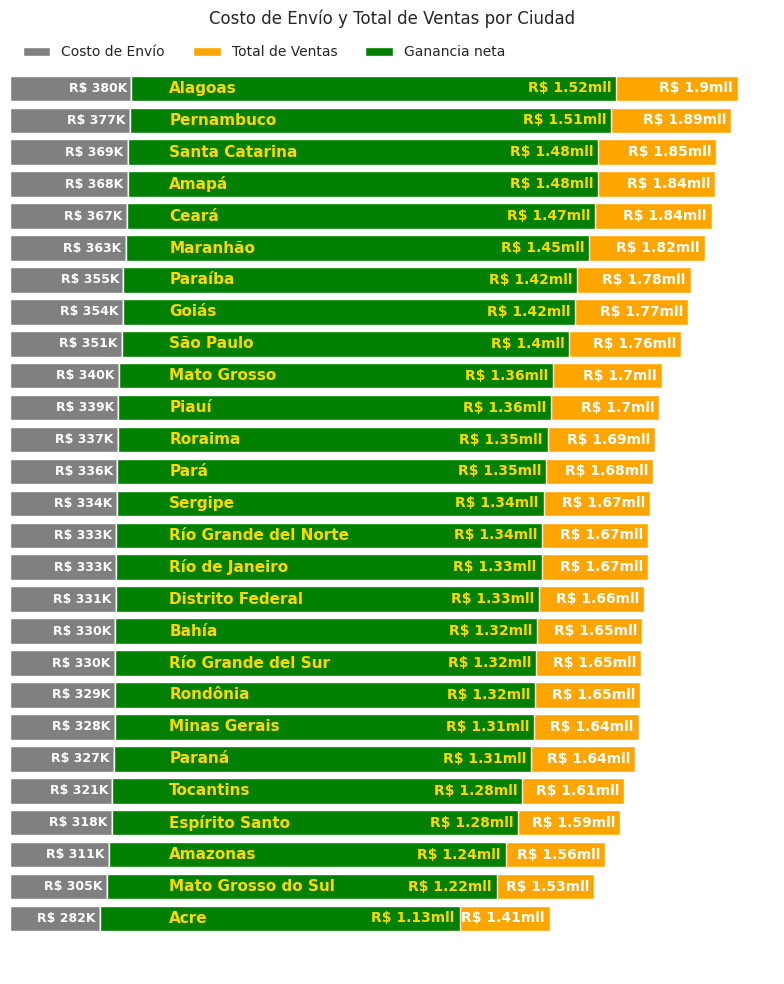

In [134]:
df = datos_combinados_final.sort_values(by='costo_envio').copy()

plt.figure(figsize=(8, 10),facecolor='none')

bar1 = plt.barh(df['ciudad'], df['costo_envio'], color='gray', label='Costo de Envío')
bar2 = plt.barh(df['ciudad'], df['total'], color='orange', left=df['costo_envio'], label='Total de Ventas')
bar3 = plt.barh(df['ciudad'], df['ganancia_neta'], color='green', left=df['costo_envio'], label='Ganancia neta')

plt.title('Costo de Envío y Total de Ventas por Ciudad')
plt.legend()
plt.xlabel('')
plt.ylabel('')
plt.box(None)
plt.grid(None)
plt.xticks([])
plt.yticks([])

# Agregar valores al final de las barras de ciudad
for bar, state in zip(bar3, df.ciudad):
    xval = bar.get_width()
    plt.text(5e5, bar.get_y() + bar.get_height()/2, state, va='center', ha='left', rotation=0, color='gold', fontsize='11', fontweight='bold')


# Agregar valores al final de las barras de costo_envio
for bar in bar1:
    xval = bar.get_width()
    plt.text(xval, bar.get_y() + bar.get_height()/2, f'R$ {int(xval/1000)}K ', va='center', ha='right', color='white', fontsize=9, fontweight='bold')

# Agregar valores al final de las barras de  total
for bar in bar2:
    xval = bar.get_width()
    plt.text(xval + bar.get_x(), bar.get_y() + bar.get_height()/2, f'R$ {round(xval/1e6,2)}mll ', va='center', ha='right', color='white', fontsize=10, fontweight='bold')

# Agregar valores al final de las barras de ganancia
for bar in bar3:
    xval = bar.get_width()
    plt.text(xval + bar.get_x(), bar.get_y() + bar.get_height()/2, f'R$ {round(xval/1e6,2)}mll ', va='center', ha='right', color='gold', fontsize=10, fontweight='bold')

plt.legend(title='', loc='upper left', frameon=False, fontsize=10, ncol=3)
plt.tight_layout()

plt.savefig('/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/graf/costo_envio.png', dpi=300)
plt.show()


In [135]:
df_top_10_costo_envio = datos_combinados_final.sort_values(by='costo_envio', ascending=False).head(10).copy()
df_top_10_costo_envio

ciudad  costo_envio  ganancia_neta    total  percent
1          Alagoas     380504.0      1522016.0  1902520     20.0
15      Pernambuco     377299.4      1509197.6  1886497     20.0
23  Santa Catarina     369240.6      1476962.4  1846203     20.0
3            Amapá     368934.4      1475737.6  1844672     20.0
5            Ceará     367020.2      1468080.8  1835101     20.0
9         Maranhão     363264.8      1453059.2  1816324     20.0
14         Paraíba     355958.6      1423834.4  1779793     20.0
8            Goiás     354551.4      1418205.6  1772757     20.0
25       São Paulo     351103.0      1404412.0  1755515     20.0
12     Mato Grosso     340902.8      1363611.2  1704514     20.0

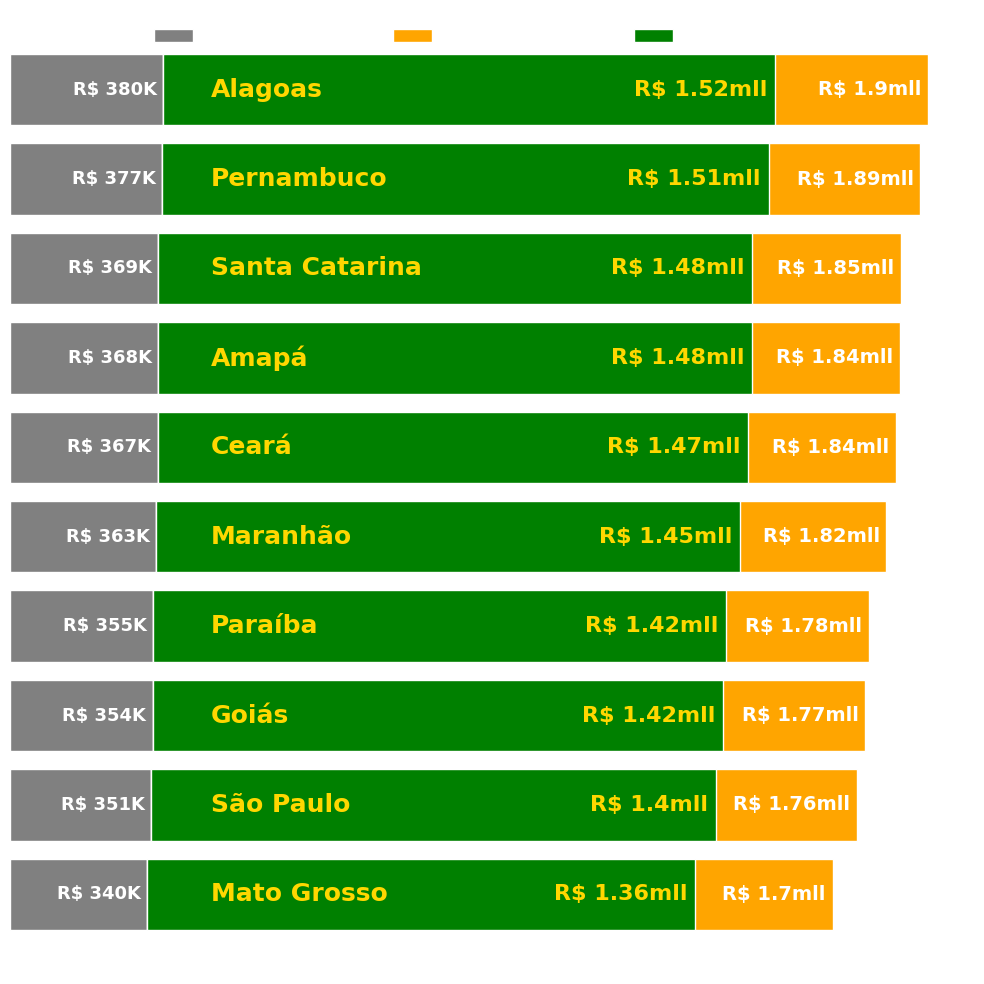

In [136]:
####  TOP 10: Estados vs Costos de envíos    ####

df_top_10_costo_envio = datos_combinados_final.sort_values(by='costo_envio', ascending=False).head(10).copy()
df=df_top_10_costo_envio.sort_values(by='costo_envio', ascending=True)
plt.figure(figsize=(10, 10),facecolor='none')

bar1 = plt.barh(df['ciudad'], df['costo_envio'], color='gray', label='Costo de Envío')
bar2 = plt.barh(df['ciudad'], df['total'], color='orange', left=df['costo_envio'], label='Total de Ventas')
bar3 = plt.barh(df['ciudad'], df['ganancia_neta'], color='green', left=df['costo_envio'], label='Ganancia neta')

# plt.title('Costo de Envío y Total de Ventas por Ciudad')
plt.legend()
plt.xlabel('')
plt.ylabel('')
plt.box(None)
plt.grid(None)
plt.xticks([])
plt.yticks([])

# Agregar valores al final de las barras de ciudad
for bar, state in zip(bar3, df.ciudad):
    xval = bar.get_width()
    plt.text(5e5, bar.get_y() + bar.get_height()/2, state, va='center', ha='left', rotation=0, color='gold', fontsize='18', fontweight='bold')


# Agregar valores al final de las barras de costo_envio
for bar in bar1:
    xval = bar.get_width()
    plt.text(xval, bar.get_y() + bar.get_height()/2, f'R$ {int(xval/1000)}K ', va='center', ha='right', color='white', fontsize=13, fontweight='bold')

# Agregar valores al final de las barras de  total
for bar in bar2:
    xval = bar.get_width()
    plt.text(xval + bar.get_x(), bar.get_y() + bar.get_height()/2, f'R$ {round(xval/1e6,2)}mll ', va='center', ha='right', color='white', fontsize=14, fontweight='bold')

# Agregar valores al final de las barras de ganancia
for bar in bar3:
    xval = bar.get_width()
    plt.text(xval + bar.get_x(), bar.get_y() + bar.get_height()/2, f'R$ {round(xval/1e6,2)}mll ', va='center', ha='right', color='gold', fontsize=16, fontweight='bold')

plt.legend(title='', loc='upper center', frameon=False, fontsize=14, ncol=3, labelcolor='white')
plt.tight_layout()

plt.savefig('/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/graf/costo_envio_top10.png', dpi=300)
plt.show()


###**Observamos nuevamente al Estado de Alagoas en el Top de ganancias. Tener presente que el costo de envío representa el 20% del total.**

###**Buscar Costos de envíos por meses:**

In [137]:
df = df_query_2_11.copy()
df['fecha_compra'] = pd.to_datetime(df['fecha_compra'])

# Obtener la columna de año y mes como una cadena de texto
costos_por_año_mes = df.groupby('fecha_compra')['costo_envio'].sum()
df_costos_por_año_mes=pd.DataFrame(costos_por_año_mes)
df_costos_por_año_mes.reset_index(inplace=True)
df_costos_por_año_mes['year_month'] = df_costos_por_año_mes['fecha_compra'].dt.strftime('%b %Y')
df_costos_por_año_mes[['costo_envio','year_month']]
total_costos_por_año_mes=df_costos_por_año_mes.groupby('year_month')['costo_envio'].sum()
df_total_costos_por_año_mes=pd.DataFrame(total_costos_por_año_mes).reset_index()
df_total_costos_por_año_mes['year_month'] = pd.to_datetime(df_total_costos_por_año_mes['year_month'])
df_total_costos_por_año_mes.sort_values('year_month',inplace=True)
df_total_costos_por_año_mes['year_month'] = df_total_costos_por_año_mes['year_month'].dt.strftime('%b %Y')
df_total_costos_por_año_mes.reset_index(drop=True,inplace=True)
df_total_costos_por_año_mes.head()

<ipython-input-137-d2df8516ba6d>:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_total_costos_por_año_mes['year_month'] = pd.to_datetime(df_total_costos_por_año_mes['year_month'])


year_month  costo_envio
0   Jan 2019      52123.2
1   Feb 2019     109628.8
2   Mar 2019     176711.8
3   Apr 2019     180894.2
4   May 2019     240403.4

<ipython-input-138-d9ef341b47c2>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='year_month', y='costo_envio', palette='inferno_r')


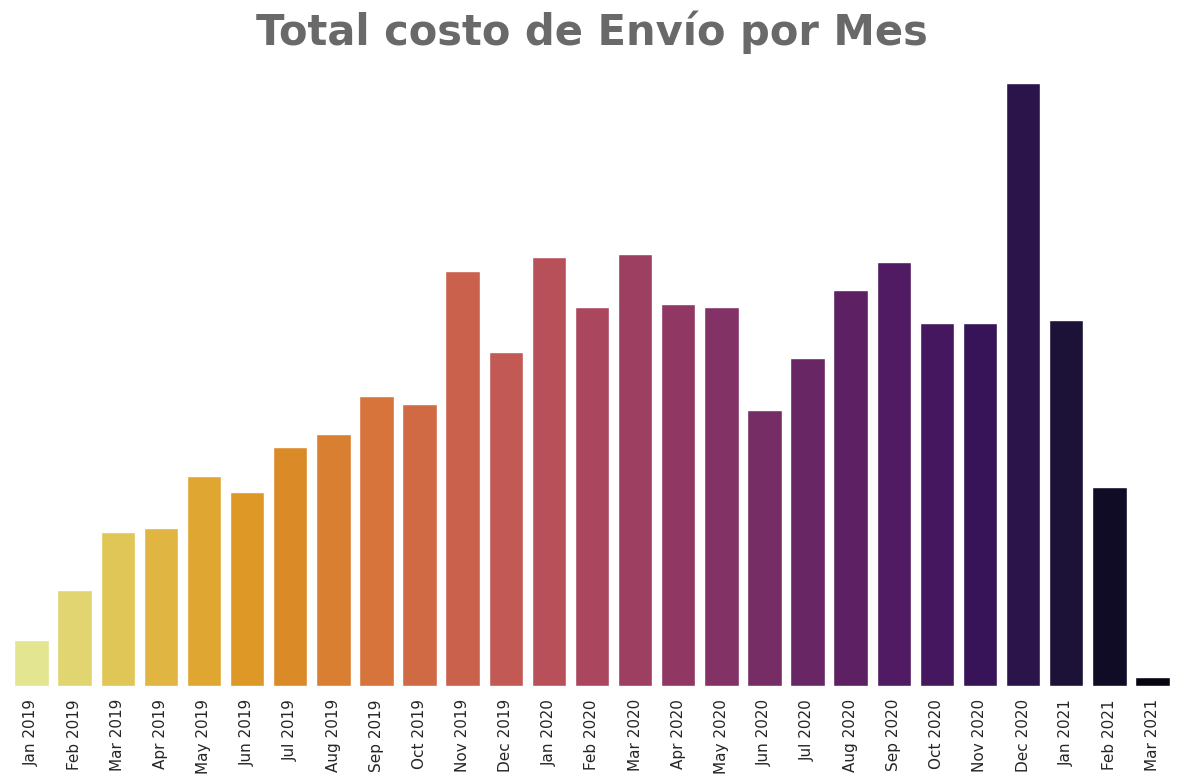

In [138]:
df = df_total_costos_por_año_mes.copy()

sns.set_style("whitegrid")

plt.figure(figsize=(12, 8),facecolor='none')
sns.barplot(data=df, x='year_month', y='costo_envio', palette='inferno_r')

plt.title('Total costo de Envío por Mes', fontsize=30, color='dimgray', fontweight='bold')
plt.xlabel('Mes', fontsize=14)
plt.ylabel('Costo de Envío', fontsize=14)

plt.xticks(rotation=90)
plt.yticks([])

for i, v in enumerate(df['costo_envio']):
    plt.text(i, v, f' {v/1000:.0f}K', ha='center', va='bottom', fontsize=12, color='white', rotation=90,fontweight='bold')


plt.xlabel('')
plt.ylabel('')
plt.grid(False)
plt.box(None)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/graf/costo_envio_meses_new.png', dpi=300)
plt.show()


<ipython-input-139-f72def557468>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='year_month', y='costo_envio', palette='inferno_r')


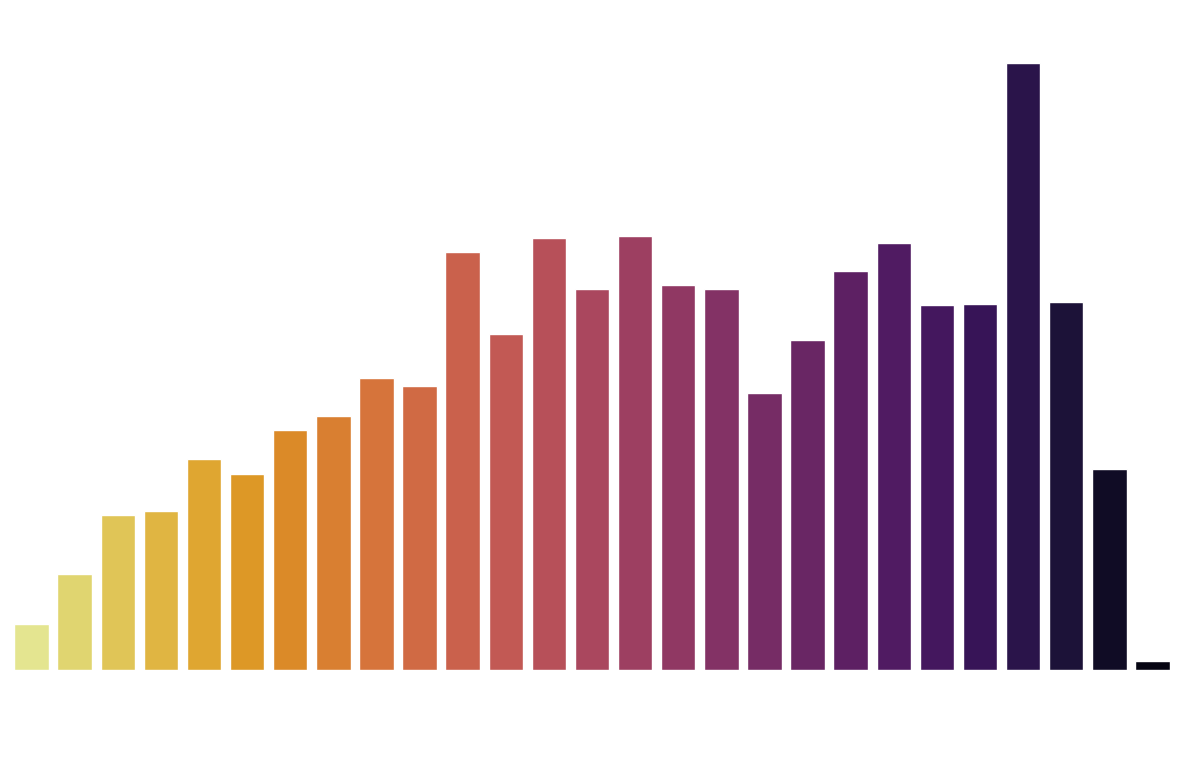

In [139]:
df = df_total_costos_por_año_mes.copy()

sns.set_style("whitegrid")

plt.figure(figsize=(12, 8),facecolor='none')
sns.barplot(data=df, x='year_month', y='costo_envio', palette='inferno_r')

# plt.title('Total costo de Envío por Mes', fontsize=30, color='dimgray', fontweight='bold')
plt.xticks(fontsize=12, color='white', rotation=90,fontweight='bold')
plt.yticks([])

for i, v in enumerate(df['costo_envio']):
    plt.text(i, v, f' {v/1000:.0f}K', ha='center', va='bottom', fontsize=12, color='white', rotation=90,fontweight='bold')


plt.xlabel('')
plt.ylabel('')
plt.grid(False)
plt.box(None)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/graf/costo_envio_meses.png', dpi=300)
plt.show()


###**Se destaca el mes de diciembre de 2020 con mayor costo de envíos, cual es proporcional a las ganancias netas, según el análisis anterior.**

In [140]:
from geopy.geocoders import Nominatim
from geopy.distance import geodesic

# Diccionario con las ciudades y sus coordenadas geográficas aproximadas
ciudades = {
    'Acre': (-9.0477, -70.5267),
    'Alagoas': (-9.5713, -36.782),
    'Amazonas': (-3.4168, -65.8561),
    'Amapá': (0.9026, -52.0028),
    'Bahía': (-12.9714, -38.5014),
    'Ceará': (-3.7172, -38.5431),
    'Distrito Federal': (-15.7934, -47.8825),
    'Espírito Santo': (-20.3155, -40.3128),
    'Goiás': (-15.827, -49.8362),
    'Maranhão': (-2.55, -44.3067),
    'Minas Gerais': (-19.9167, -43.9333),
    'Mato Grosso do Sul': (-20.4428, -54.6464),
    'Mato Grosso': (-15.596, -56.0969),
    'Pará': (-1.455, -48.5028),
    'Paraíba': (-7.115, -34.8631),
    'Pernambuco': (-8.0476, -34.877),
    'Piauí': (-5.0919, -42.8034),
    'Paraná': (-25.4284, -49.2733),
    'Río de Janeiro': (-22.9068, -43.1729),
    'Río Grande del Norte': (-5.7945, -35.211),
    'Rondônia': (-11.5057, -63.5806),
    'Roraima': (2.8198, -60.6715),
    'Río Grande del Sur': (-30.0331, -51.23),
    'Santa Catarina': (-27.5954, -48.548),
    'Sergipe': (-10.9472, -37.0731),
    'São Paulo': (-23.5505, -46.6333),
    'Tocantins': (-10.1753, -48.2982)
}

# Coordenadas de São Paulo
coordenadas_sp = ciudades['São Paulo']

# Inicializar el geolocalizador con OpenStreetMap como proveedor
geolocalizador = Nominatim(user_agent="geoapiExercises")

# Diccionario para almacenar las distancias
distancias_a_sp = {}

# Calcular la distancia desde São Paulo a cada ciudad
for ciudad, coordenadas in ciudades.items():
    distancia = geodesic(coordenadas_sp, coordenadas).kilometers
    distancias_a_sp[ciudad] = distancia

# Mostrar las distancias
for ciudad, distancia in distancias_a_sp.items():
    print(f"Distancia desde São Paulo a {ciudad}: {round(distancia,1)} km")


Distancia desde São Paulo a Acre: 3007.5 km
Distancia desde São Paulo a Alagoas: 1868.6 km
Distancia desde São Paulo a Amazonas: 3039.7 km
Distancia desde São Paulo a Amapá: 2767.0 km
Distancia desde São Paulo a Bahía: 1451.8 km
Distancia desde São Paulo a Ceará: 2360.7 km
Distancia desde São Paulo a Distrito Federal: 868.6 km
Distancia desde São Paulo a Espírito Santo: 744.6 km
Distancia desde São Paulo a Goiás: 918.5 km
Distancia desde São Paulo a Maranhão: 2337.0 km
Distancia desde São Paulo a Minas Gerais: 489.8 km
Distancia desde São Paulo a Mato Grosso do Sul: 895.9 km
Distancia desde São Paulo a Mato Grosso: 1326.3 km
Distancia desde São Paulo a Pará: 2452.9 km
Distancia desde São Paulo a Paraíba: 2211.7 km
Distancia desde São Paulo a Pernambuco: 2125.4 km
Distancia desde São Paulo a Piauí: 2083.4 km
Distancia desde São Paulo a Paraná: 338.9 km
Distancia desde São Paulo a Río de Janeiro: 361.3 km
Distancia desde São Paulo a Río Grande del Norte: 2315.0 km
Distancia desde São Pau

###**Obtener datos para graficar Top 3 de marcas más vendidas por mes:**

In [141]:
df=df_query_2_11.copy()
df['fecha_compra'] = pd.to_datetime(df['fecha_compra'])
top=3
# Crear una nueva columna para el año y mes en formato 'aaaa-mm'
df['año_mes'] = df['fecha_compra'].dt.strftime('%Y-%m')
ventas_por_marca_y_mes = df.groupby(['año_mes', 'marca'])['total'].sum().reset_index()
top_por_marca_por_año_mes = (ventas_por_marca_y_mes.groupby('año_mes')
                                .apply(lambda x: x.nlargest(top, 'total'))
                                .reset_index(drop=True))
top_por_marca_por_año_mes.head()


año_mes           marca  total
0  2019-01           Mixed  33479
1  2019-01  Bottega Veneta  30875
2  2019-01           Prada  23400
3  2019-02           Mixed  48412
4  2019-02        Givenchy  44000

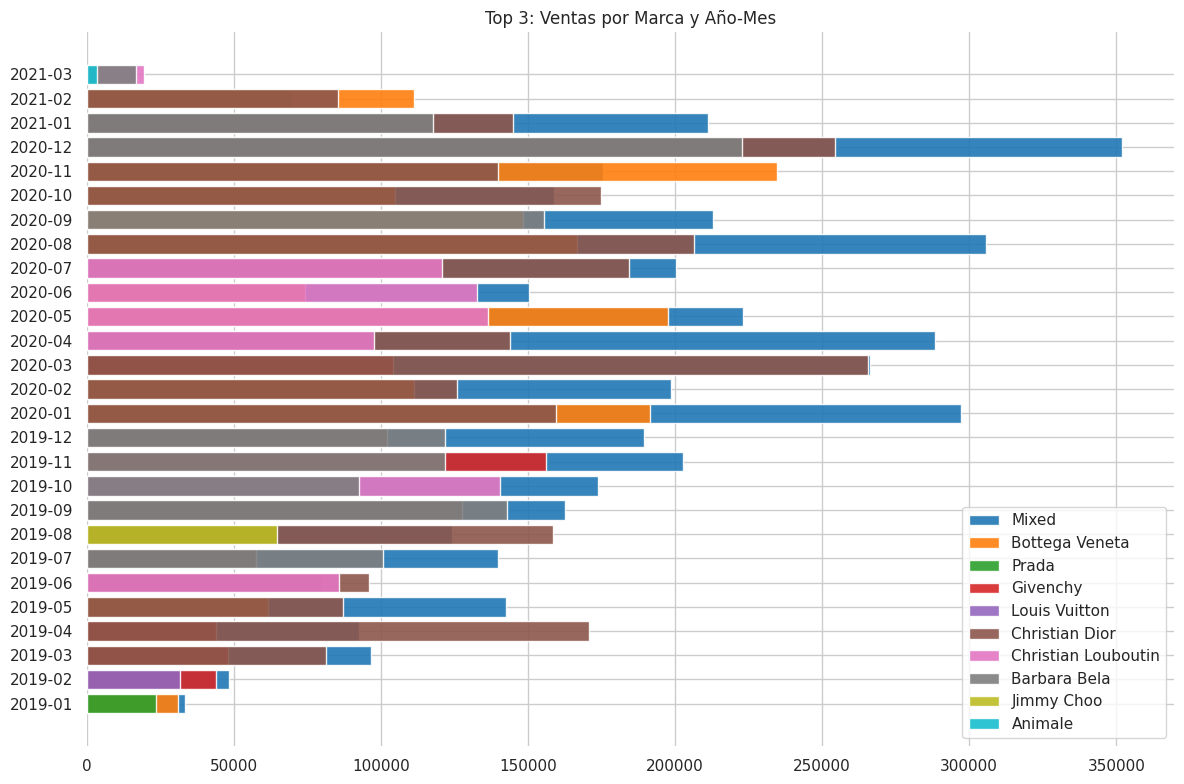

In [142]:
df=top_por_marca_por_año_mes.copy()
año_mes1 = df['año_mes'].unique()
marcas1 = df['marca'].unique()
total1_por_mes_y_marca = df.pivot(index='año_mes', columns='marca', values='total')

# Configuración del gráfico
plt.figure(figsize=(12, 8))
bar_width=.8

for i, marca in enumerate(marcas1):
    plt.barh(año_mes1, list(total1_por_mes_y_marca[marca]), label=marca, alpha=.9, color=plt.cm.tab10(i/len(marcas1)),height=bar_width)
    #         ('Qualitative', ['Pastel1', 'Pastel2', 'Paired', 'Accent','Dark2', 'Set1', 'Set2', 'Set3','tab10', 'tab20', 'tab20b', 'tab20c'])


plt.xlabel('')
plt.ylabel('')
plt.title(f'Top {top}: Ventas por Marca y Año-Mes')
# plt.xticks(rotation=45, labels=[format_ticks(value, None) for value in y])
plt.xticks( rotation=0 )
plt.legend()
plt.tight_layout()
plt.box(None)
# plt.grid(None)
plt.show()

###**Se puede apreciar  ala marca MIXED como prevalece ampliamente sobre el resto, con picos muy destacados con las ganancias netas. Destacar los meses de Enero, Abril, Agosto de 2020 están alrededor de los 300K, y Enero 2021  supera los 300K, pero luego continúa un declive muy pronunciado en ventas, por lo que consideramos estos meses del año 2021 como datos que deben ser evaluados por aparte, para tratar de inducir la causa, porque las tendencias del mercado online marcan un crecimiento acelerado para el 2021.**

In [143]:
!pip install bar_chart_race --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 kB 4.1 MB/s eta 0:00:00


###**Crear Bar chart Race: Ganancias por Marcas en función de las fechas por meses:**

In [144]:
df=df_query_2_11.copy()
df['fecha_compra'] = pd.to_datetime(df['fecha_compra'])
top=5
# Crear una nueva columna para el año y mes en formato 'aaaa-mm'
df['año_mes'] = df['fecha_compra'].dt.strftime('%Y-%m')
ventas_por_marca_y_mes = df.groupby(['año_mes', 'marca'])['total'].sum().reset_index()
top_por_marca_por_año_mes = (ventas_por_marca_y_mes.groupby('año_mes')
                                .apply(lambda x: x.nlargest(top, 'total'))
                                .reset_index(drop=True))
df_pivot = top_por_marca_por_año_mes.pivot(index='año_mes', columns='marca', values='total')
df_pivot=df_pivot.fillna(0)
df_pivot_sorted = df_pivot.astype(int).sort_index(ascending=True)

df_pivot.astype(int).head()

marca    Animale  Barbara Bela  Bottega Veneta  Christian Dior  \
año_mes                                                          
2019-01        0             0           30875               0   
2019-02    30756         25200               0               0   
2019-03        0         42000               0           81250   
2019-04        0             0           30875          170750   
2019-05        0             0           61750           87250   

marca    Christian Louboutin  Givenchy  Iorane  Isolda  J. Crew  Jimmy Choo  \
año_mes                                                                       
2019-01                    0         0       0    7670        0           0   
2019-02                    0     44000       0       0        0           0   
2019-03                    0     48000       0       0        0           0   
2019-04                    0     44000       0       0        0           0   
2019-05                    0         0       0       0        0           0   

marca    Louis Vuitton   Mixed  Prada   Zara  
año_mes                                       
2019-01              0   33479  23400   7617  
2019-02          31560   48412      0      0  
2019-03              0   96781      0  38508  
2019-04              0   92560      0  34912  
2019-05          52600  142687      0  34405

In [145]:
# import bar_chart_race as bcr

# animacion_top_5 = bcr.bar_chart_race(df_pivot, steps_per_period=10, period_length=1000,
#                    fixed_max=True,
#                    fixed_order=False,
#                    n_bars=5,
#                    figsize=(9, 5),
#                    title='Top 10: Ventas por Marca',
#                    title_size=20,
#                    label_bars=True,
#                    bar_size=0.95,
#                    period_label={'x': 0.9, 'y': 0.8, 'ha': 'right', 'va': 'center', 'fontsize': 14, 'color': 'navy'},
#                    tick_label_size=8, bar_label_size=8,
#                    period_fmt='Año {x}')

# animacion_top_5


In [146]:
# ##  GUARDAR GRAFICA  ####
# # Guardar la animación como un archivo MP4
# import bar_chart_race as bcr

# bcr.bar_chart_race(df_pivot,'/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/bar_chart_race/animacion_top_5.mp4', steps_per_period=10, period_length=1000,
#                    fixed_max=True,
#                    fixed_order=False,
#                    n_bars=5,
#                    figsize=(9, 5),
#                    title='Top 5: Ventas por Marca',
#                    title_size=20,
#                    label_bars=True,
#                    bar_size=0.95,
#                    period_label={'x': 0.9, 'y': 0.8, 'ha': 'right', 'va': 'center', 'fontsize': 14, 'color': 'navy'},
#                    tick_label_size=8, bar_label_size=8,
#                    period_fmt='Año {x}')

###**Todos los valores SKU son únicos**

In [147]:
todos_unicos = (df_productos.sku.value_counts() == 1).all()
todos_unicos

True

###**Clasificación de marcas por género:**

In [148]:
marca = {
    'marca': ['D&g Dolce & Gabbana', 'Givenchy', 'Joe Fresh', 'Mixed', 'Zara',
       'Gap', 'Banana Republic', 'Fyi', 'Sacada', 'Rag & Bone', 'Cori',
       'Forever 21', 'Tigresse', 'Tory Burch', 'Brooksfield', 'Animale',
       '284', 'Dkny', 'Cheroy', 'Canal', 'Le Lis Blanc', 'Spezzato',
       'Cantão', 'Talie Nk', 'H&M', 'Schutz', 'Jorge Bischoff', #27
       'Luisa Farani', 'Seven', 'Kipling', 'Louis Vuitton', 'Agilità',
       'Fabiana Caterina', 'Reinaldo Lourenço', 'Karmani', 'Erre Erre',
       'H&m', 'Forum', 'Ellus', 'J. Crew', "Joe's", 'Galeria Tricot',
       'Loft 747', 'Oxyfit', 'Topshop', 'A.brand', 'Isolda',
       'American Eagle', 'Colcci', 'Carter’s', 'Thay Ribas', #51
       'Carina Duek', 'Kate Spade', 'Bottega Veneta', 'Morena Rosa',
       'Luiza Barcelos', 'Lezalez', 'My Place', 'Farm', 'Armani Exchange',
       'Bcbgmaxzria', 'Dica da Ka', 'My Shoes', 'Argentum',
       'Red Valentino', 'Maria Filó', 'Marc By Marcjacobs',
       'Track & Field', 'Christian Dior', 'Toca do Coelho',
       'Barbara Bela', 'Miu Miu', 'Gregory', 'Prada', 'Steal The Look',
       'Shoulder', 'Maria Bonita', 'Isa Kulikovski', 'Ralph Lauren',
       'Camila Klein', 'Bazar Genial', 'Hollister', 'Diesel', #83
       'All Saints Spitalfields', 'Iorane', 'Felini', 'Miss Sixty',
       'Linda de Morrer', 'Vera Wang', 'Daslu', 'Adidas', 'Amaro',
       'Jimmy Choo', 'Sweet Cotton', 'Cris Barros', 'Mara Mac',
       'Paula Raia', 'Dress&co', 'Mango', 'Ateliê de Calças', 'Thelure', #101
       'Converse', "Levi's", 'Lemon Cola', 'Limone By Jade Seba',
       'Espaço Fashion', 'Seal Brasil', 'Alix Shop', 'Bo. bô.',
       'Lauren Ralph Lauren', 'Christian Louboutin', 'Saad', 'Osklen',
       'Skazi', 'Carol Bassi', 'Calvin Klein', 'Express','Bobô'],


    'marca_genero': ['U', 'F', 'F', 'F', "F", "U", "U", "U", "F", "F", "F", "F", "F", "F", "M", "F",
                              "F", "F", "F", "U", "F", "F", "F", "U", "U", "F", "F", "F", "U", "U", "U", "F", "F",
                              "F", "F", "F", "U", "M", "U", "F", "U", "F", "F", "F", "F", "F", "F", "U", "F",
                              "U", "F", "F", "F", "U", "F", "F", "F", "F", "F", "M", "F", "F", "F", "F", "U",
                              "F", "F", "F", "U", "U", "F", "F", "U", "F", "F", "F", "F", "F", "U", "F", "U",
                              "U", "U", "U", "F", "M", "F", "F", "F", "F", "U", "F", "U", "F", "F", "U", "F",
                              "F", "F", "F", "F", "U", "U", "F", "F", "F", "M", "F", "F", "F", "F", "U", "U",
                               "F", "F", "U", "U","F"]}



df_marca_genero = pd.DataFrame(marca)
df_merged = pd.merge(df_query_5, df_marca_genero, on='marca', how='inner')

In [149]:
df_merged.marca_genero.value_counts()

marca_genero
F    17951
U     5772
M      803
Name: count, dtype: int64

In [150]:
marca_genero_percentage = df_merged.marca_genero.value_counts(normalize=True) * 100
marca_genero_percentage

marca_genero
F    73.191715
U    23.534209
M     3.274076
Name: proportion, dtype: float64

###**Ganancia neta totales por vendedores según el género:**

In [151]:
df_vendedor_genero_condicion = df_merged.groupby(['fecha_compra' ,'condicion', 'nombre_vendedor', 'marca_genero'])['ganancia_neta'].sum().reset_index()
df_vendedor_genero_condicion

fecha_compra           condicion  nombre_vendedor marca_genero  \
0      2019-01-05  Nuevo sin etiqueta   Nadia Oliveira            F   
1      2019-01-05               Usado       Ana Duarte            F   
2      2019-01-05               Usado  Daniel Siqueira            F   
3      2019-01-05               Usado  Millena Pereira            F   
4      2019-01-05               Usado   Nadia Oliveira            U   
...           ...                 ...              ...          ...   
9477   2021-03-09               Usado       Ana Duarte            F   
9478   2021-03-09               Usado  Daniel Siqueira            F   
9479   2021-03-10               Usado       Ana Duarte            F   
9480   2021-03-10               Usado  Millena Pereira            F   
9481   2021-03-10               Usado   Nadia Oliveira            F   

      ganancia_neta  
0            1120.0  
1            1989.6  
2            1260.0  
3            2767.2  
4           24700.0  
...             ...  
9477         1888.0  
9478         2240.0  
9479        15600.0  
9480          208.0  
9481          333.6  

[9482 rows x 5 columns]

In [152]:
ganancia_por_vendedor_genero = df_vendedor_genero_condicion.groupby(['nombre_vendedor', 'marca_genero'])['ganancia_neta'].sum().reset_index()
ganancia_por_vendedor_genero

nombre_vendedor marca_genero  ganancia_neta
0        Ana Duarte            F      5114787.2
1        Ana Duarte            M       149792.0
2        Ana Duarte            U      2491162.4
3   Daniel Siqueira            F      5133171.2
4   Daniel Siqueira            M       155084.0
5   Daniel Siqueira            U      2418883.2
6   Millena Pereira            F      4101441.6
7   Millena Pereira            M       121832.0
8   Millena Pereira            U      2034690.4
9    Nadia Oliveira            F      4799940.8
10   Nadia Oliveira            M       159804.0
11   Nadia Oliveira            U      2194164.0
12    Paulo Calanca            F      5430306.4
13    Paulo Calanca            M       166488.0
14    Paulo Calanca            U      2170972.8

In [153]:
df_vendedor_genero_condicion['fecha_compra'] = pd.to_datetime(df_vendedor_genero_condicion['fecha_compra'])

# Filtrar las filas según años anteriores a 2021
df_filtrado = df_vendedor_genero_condicion[df_vendedor_genero_condicion['fecha_compra'].dt.year < 2021]
ganancia_por_vendedor_genero_ano2019al2020 = df_filtrado.groupby(['nombre_vendedor', 'marca_genero'])['ganancia_neta'].sum().reset_index()
ganancia_por_vendedor_genero_ano2019al2020

nombre_vendedor marca_genero  ganancia_neta
0        Ana Duarte            F      4789503.2
1        Ana Duarte            M       139988.0
2        Ana Duarte            U      2278780.0
3   Daniel Siqueira            F      4849304.0
4   Daniel Siqueira            M       148056.0
5   Daniel Siqueira            U      2290076.0
6   Millena Pereira            F      3821340.8
7   Millena Pereira            M       109580.0
8   Millena Pereira            U      1928147.2
9    Nadia Oliveira            F      4238586.4
10   Nadia Oliveira            M       146216.0
11   Nadia Oliveira            U      1959086.4
12    Paulo Calanca            F      5143248.8
13    Paulo Calanca            M       156016.0
14    Paulo Calanca            U      2013100.8

In [154]:
ganancia_vendedor_2019and2020=ganancia_por_vendedor_genero_ano2019al2020.groupby('nombre_vendedor')['ganancia_neta'].sum().reset_index()
ganancia_vendedor_2019and2020

nombre_vendedor  ganancia_neta
0       Ana Duarte      7208271.2
1  Daniel Siqueira      7287436.0
2  Millena Pereira      5859068.0
3   Nadia Oliveira      6343888.8
4    Paulo Calanca      7312365.6

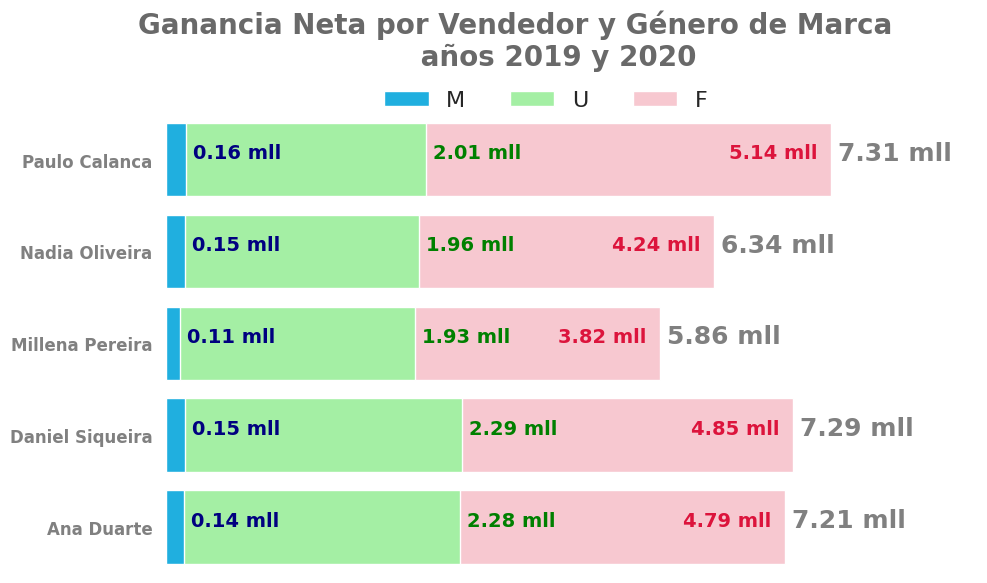

In [155]:
df=ganancia_por_vendedor_genero_ano2019al2020.copy()
plt.subplots(figsize=(10, 6),facecolor='none')

ganancia_vendedor_2019and2020=ganancia_por_vendedor_genero_ano2019al2020.groupby('nombre_vendedor')['ganancia_neta'].sum().reset_index()

ax = sns.barplot(data=df, y='nombre_vendedor', x='ganancia_neta', hue='marca_genero', hue_order=['F', 'U', 'M'], palette=['pink','palegreen','deepskyblue'], errorbar=None, dodge=False)

plt.xlabel('')
plt.ylabel('')
plt.title('Ganancia Neta por Vendedor y Género de Marca\n         años 2019 y 2020',fontsize=20, color='dimgray', fontweight='bold',pad=35)
plt.gca().invert_yaxis()

# Mostrar los valores en las barras
for p in ax.patches:
  if (p.get_width() != 0) and (p.get_width() < 5e5):
        ax.annotate(f'{str(round(p.get_width()/1e6,2))} mll', (p.get_width(), p.get_y() + p.get_height() / 2), xytext=(5, 5), textcoords='offset points', ha='left', va='center', color='navy', fontsize=14,fontweight= 'bold')
  if (p.get_width() != 0) and (p.get_width() > 5e5)and (p.get_width() < 3e6):
        ax.annotate(f'{str(round(p.get_width()/1e6,2))} mll', (p.get_width(), p.get_y() + p.get_height() / 2), xytext=(5, 5), textcoords='offset points', ha='left', va='center', color='green', fontsize=14,fontweight= 'bold')

for p, total in zip(ax.patches,ganancia_vendedor_2019and2020.ganancia_neta):
  if (p.get_width() != 0) and (p.get_width() > 3e6):
        ax.annotate(f'{str(round(p.get_width()/1e6,2))} mll   ', (p.get_width(), p.get_y() + p.get_height() / 2), xytext=(5, 5), textcoords='offset points', ha='right', va='center', color='crimson', fontsize=14,fontweight= 'bold')
        ax.annotate(f'{str(round(total/1e6,2))} mll   ', (p.get_width(), p.get_y() + p.get_height() / 2), xytext=(5, 5), textcoords='offset points', ha='left', va='center', color='gray', fontsize=18,fontweight= 'bold')

plt.xticks([])
plt.yticks(color='gray', fontsize=12,fontweight= 'bold')
plt.grid(False)
plt.box(False)
# plt.yticks([])

# Ajustar la leyenda
handles, labels = ax.get_legend_handles_labels()
handles.reverse()
labels.reverse()
ax.legend(handles=handles, labels=labels, title='', bbox_to_anchor=(0.3, 1.07), loc='upper left', borderaxespad=0., ncol=3, frameon=False,fontsize=16)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/graf/vendedor_ganancia_genero.png', dpi=300)
plt.show()

In [156]:
df=ganancia_por_vendedor_genero_ano2019al2020.copy()
total = df.groupby('nombre_vendedor')['ganancia_neta'].sum().reset_index()
total.rename(columns={'ganancia_neta': 'ganancia_total'}, inplace=True)
df = pd.merge(df, total, on='nombre_vendedor')
df['porcentaje'] = df['ganancia_neta'] / df['ganancia_total'] * 100
# df=df[['nombre_vendedor',	'marca_genero',	'ganancia_neta',	'porcentaje']]
df

nombre_vendedor marca_genero  ganancia_neta  ganancia_total  porcentaje
0        Ana Duarte            F      4789503.2       7208271.2   66.444548
1        Ana Duarte            M       139988.0       7208271.2    1.942047
2        Ana Duarte            U      2278780.0       7208271.2   31.613405
3   Daniel Siqueira            F      4849304.0       7287436.0   66.543349
4   Daniel Siqueira            M       148056.0       7287436.0    2.031661
5   Daniel Siqueira            U      2290076.0       7287436.0   31.424990
6   Millena Pereira            F      3821340.8       5859068.0   65.220967
7   Millena Pereira            M       109580.0       5859068.0    1.870263
8   Millena Pereira            U      1928147.2       5859068.0   32.908770
9    Nadia Oliveira            F      4238586.4       6343888.8   66.813693
10   Nadia Oliveira            M       146216.0       6343888.8    2.304832
11   Nadia Oliveira            U      1959086.4       6343888.8   30.881474
12    Paulo Calanca            F      5143248.8       7312365.6   70.336319
13    Paulo Calanca            M       156016.0       7312365.6    2.133591
14    Paulo Calanca            U      2013100.8       7312365.6   27.530090

In [157]:
perct_unisex=df[df['marca_genero']=='U']
perct_unisex

nombre_vendedor marca_genero  ganancia_neta  ganancia_total  porcentaje
2        Ana Duarte            U      2278780.0       7208271.2   31.613405
5   Daniel Siqueira            U      2290076.0       7287436.0   31.424990
8   Millena Pereira            U      1928147.2       5859068.0   32.908770
11   Nadia Oliveira            U      1959086.4       6343888.8   30.881474
14    Paulo Calanca            U      2013100.8       7312365.6   27.530090

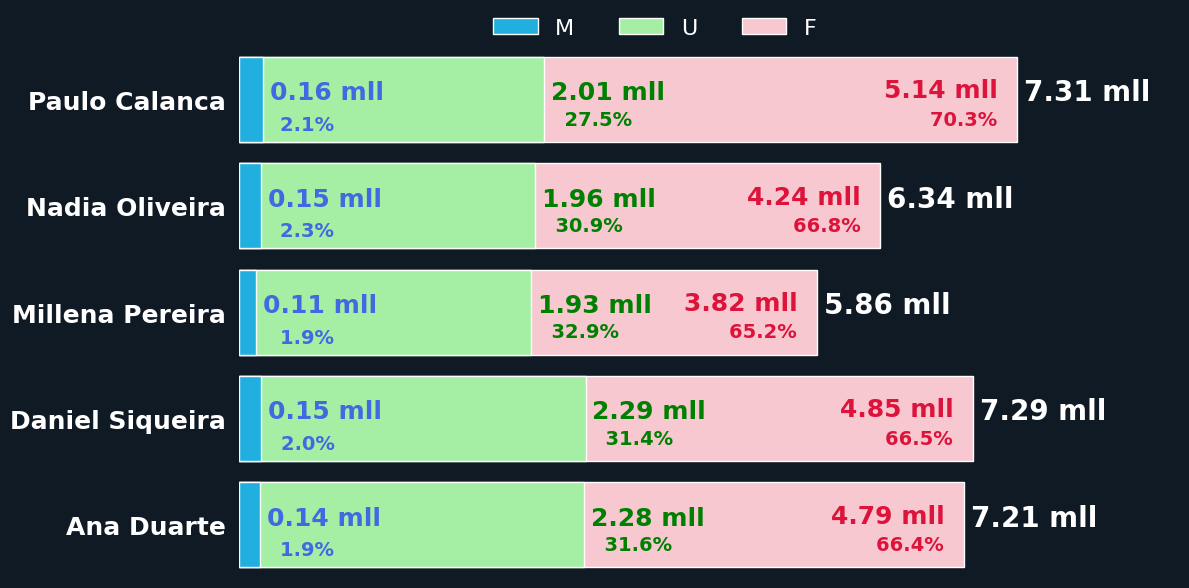

In [158]:
####   graf: Ganancias vs marca género   ####

df=ganancia_por_vendedor_genero_ano2019al2020.copy()
total = df.groupby('nombre_vendedor')['ganancia_neta'].sum().reset_index()
total.rename(columns={'ganancia_neta': 'ganancia_total'}, inplace=True)
df = pd.merge(df, total, on='nombre_vendedor')
df['porcentaje'] = df['ganancia_neta'] / df['ganancia_total'] * 100
df=df[['nombre_vendedor',	'marca_genero',	'ganancia_neta',	'porcentaje']]

perct_women=df[df['marca_genero']=='F']
perct_men=df[df['marca_genero']=='M']
perct_unisex=df[df['marca_genero']=='U']


plt.subplots(figsize=(12, 6),facecolor='#101a24')
# plt.subplots(figsize=(10, 6),facecolor='none')

ganancia_vendedor_2019and2020=ganancia_por_vendedor_genero_ano2019al2020.groupby('nombre_vendedor')['ganancia_neta'].sum().reset_index()

ax = sns.barplot(data=df, y='nombre_vendedor', x='ganancia_neta', hue='marca_genero', hue_order=['F', 'U', 'M'], palette=['pink','palegreen','deepskyblue'], errorbar=None, dodge=False)

plt.xlabel('')
plt.ylabel('')
# plt.title('Ganancia Neta por Vendedor y Género de Marca\n         años 2019 y 2020',fontsize=20, color='dimgray', fontweight='bold',pad=35)
plt.gca().invert_yaxis()

# Mostrar los valores en las barras
for p in ax.patches:
  if (p.get_width() != 0) and (p.get_width() < 5e5):
        ax.annotate(f'{str(round(p.get_width()/1e6,2))} mll', (p.get_width(), p.get_y() + p.get_height() / 2), xytext=(5, 5), textcoords='offset points', ha='left', va='center', color='royalblue', fontsize=18,fontweight= 'bold')

  if (p.get_width() != 0) and (p.get_width() > 5e5)and (p.get_width() < 3e6):
        ax.annotate(f'{str(round(p.get_width()/1e6,2))} mll', (p.get_width(), p.get_y() + p.get_height() / 2), xytext=(5, 5), textcoords='offset points', ha='left', va='center', color='green', fontsize=18,fontweight= 'bold')

for p, total,women,man,unisex,gan_neta_unisex in zip(ax.patches,ganancia_vendedor_2019and2020.ganancia_neta,perct_women.porcentaje,perct_men.porcentaje,perct_unisex.porcentaje,perct_unisex.ganancia_neta):
  if (p.get_width() != 0) and (p.get_width() > 3e6):
        ax.annotate(f'{str(round(p.get_width()/1e6,2))} mll   ', (p.get_width(), p.get_y() + p.get_height() / 2+.02), xytext=(5, 5), textcoords='offset points', ha='right', va='center', color='crimson', fontsize=18,fontweight= 'bold')
        ax.annotate(f'{women:.1f}%    ', (p.get_width(), p.get_y() + p.get_height() / 2-.25), xytext=(5, 5), textcoords='offset points', ha='right', va='center', color='crimson', fontsize=14,fontweight= 'bold')
        ax.annotate(f'{man:.1f}%    ', (8e5, p.get_y() + p.get_height() / 2-.25), xytext=(1, 1), textcoords='offset points', ha='right', va='center', color='royalblue', fontsize=14,fontweight= 'bold')
        ax.annotate(f'  {unisex:.1f}%', (gan_neta_unisex, p.get_y() + p.get_height() / 2-.25), xytext=(5, 5), textcoords='offset points', ha='left', va='center', color='green', fontsize=14,fontweight= 'bold')
        ax.annotate(f'{str(round(total/1e6,2))} mll   ', (p.get_width(), p.get_y() + p.get_height() / 2), xytext=(5, 5), textcoords='offset points', ha='left', va='center', color='white', fontsize=20,fontweight= 'bold')


plt.xticks([])
plt.yticks(color='white', fontsize=18,fontweight= 'bold')
plt.grid(False)
plt.box(False)
# plt.yticks([])

# Ajustar la leyenda
handles, labels = ax.get_legend_handles_labels()
handles.reverse()
labels.reverse()
ax.legend(handles=handles, labels=labels, title='', bbox_to_anchor=(0.3, 1.07), loc='upper left', borderaxespad=0., ncol=3, frameon=False,fontsize=16,labelcolor='white')
# plt.legend([])
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/graf/vendedor_ganancia_genero_new.png', dpi=300)
plt.show()

###**Graficar ganancias por regiones:

###**Destacar la gran superioridad de las marcas femeninas sobre las masculinas. El Vendedor Calanca lidera nuevamente en las ganancias netas por genenro masculino y femenino. En el géreno unisex Siqueira y Duarte lideran en ganancias**

In [159]:
df_query_5.head()

pedido_id  producto_id  vendedor_id fecha_compra  total  id_recibo  \
0          1         5292            2   2020-02-16   3456      10062   
1        107        41189            2   2020-01-17    800       8839   
2        210        10086            1   2020-02-25   4500      10466   
3        356        56571            1   2019-12-25    420       8015   
4        434        40082            4   2019-12-11   1260       7600   

   cantidad  valor_unitario  valor_total ciudad  costo_envio  ganancia_neta  \
0         6             576         3456  BR-PE        691.2         2764.8   
1         5             160          800  BR-PE        160.0          640.0   
2         6             750         4500  BR-PE        900.0         3600.0   
3         1             420          420  BR-PE         84.0          336.0   
4         4             315         1260  BR-PE        252.0         1008.0   

                producto  precio           marca       sku  \
0      Saia Jeans Forest   576.0           Mixed  222683.0   
1  Calca Acetinada Preta   160.0            Zara  176893.0   
2           Oculos Metal   750.0  Christian Dior  319314.0   
3    Vestido Seda Floral   420.0         Animale  178553.0   
4   Vestido Malha Vitral   315.0           Forum  324684.0   

            condicion  nombre_vendedor abbrev_state  code_state  name_state  \
0  Nuevo con etiqueta  Daniel Siqueira           PE        26.0  Pernambuco   
1               Usado  Daniel Siqueira           PE        26.0  Pernambuco   
2               Usado       Ana Duarte           PE        26.0  Pernambuco   
3               Usado       Ana Duarte           PE        26.0  Pernambuco   
4               Usado  Millena Pereira           PE        26.0  Pernambuco   

   code_region name_region                                           geometry  
0          2.0    Nordeste  MULTIPOLYGON (((-32.39705 -3.83294, -32.39774 ...  
1          2.0    Nordeste  MULTIPOLYGON (((-32.39705 -3.83294, -32.39774 ...  
2          2.0    Nordeste  MULTIPOLYGON (((-32.39705 -3.83294, -32.39774 ...  
3          2.0    Nordeste  MULTIPOLYGON (((-32.39705 -3.83294, -32.39774 ...  
4          2.0    Nordeste  MULTIPOLYGON (((-32.39705 -3.83294, -32.39774 ...

###**Total ventas por región:**

In [160]:
df_region_total = df_query_5.groupby('name_region')['total'].sum().reset_index()
df_region_total.sort_values(by='total',ascending=True,inplace=True)
df_region_total

name_region     total
4           Sul   5131996
3       Sudeste   6661838
0  Centro Oeste   6662627
2         Norte  11432248
1      Nordeste  15914441

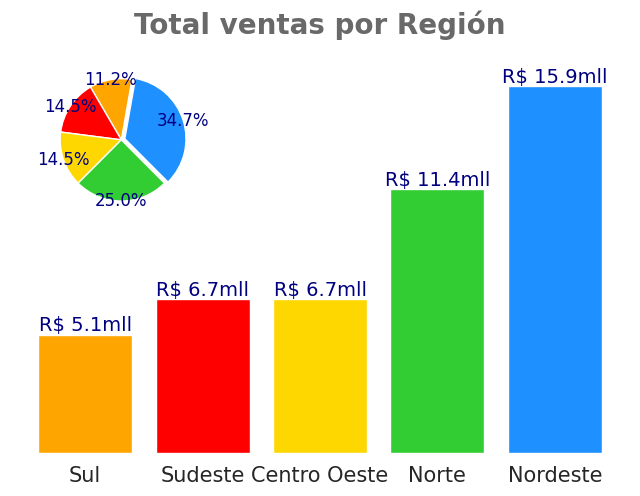

In [161]:
df=df_region_total.copy()

colores = [ 'orange' ,'limegreen', 'gold','dodgerblue', 'red']

####   GRAFICA DE BARRAS CON GRAFICA PIE   ####

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Datos de la gráfica de barras
# colores = ['#00b4d8','#adb5bd', '#dee2e6', '#90e0ef', '#0077b6']
# colores = [ 'dodgerblue','limegreen', 'orange' , 'gold', 'red']
colores = [ 'orange','red', 'gold' , 'limegreen', 'dodgerblue']

# labels = ['S-E', 'N-E', 'C-O', 'N', 'S']
bar_positions = np.arange(len(df['name_region']))
bar_heights = df['total']

# Crear la gráfica de barras
fig, ax = plt.subplots(figsize=(8, 5),facecolor='none')
ax.bar(bar_positions, bar_heights, color=colores)
plt.box(False)
plt.grid(False)
# Configuraciones de la gráfica de barras
ax.set_xticks(bar_positions)
ax.set_xticklabels(df['name_region'], fontsize=15)
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title(f'Total ventas por Región', color='dimgray', fontweight='bold', fontsize=20,pad=25)

# Mostrar etiquetas en las barras
for i, value in enumerate(bar_heights):
    ax.text(i, value, f'R$ {value/1e6:,.1f}mll', ha='center', va='bottom', fontsize=14, color='navy')

# Configuración adicional para quitar las líneas al lado de los ejes
ax.yaxis.tick_left()
ax.xaxis.tick_bottom()
ax.xaxis.set_tick_params(width=0)
ax.yaxis.set_tick_params(width=0)

#GRafica pie:
explode = (0, 0, 0, 0, 0.06)  # Separar la primera porción (Sureste)
axins = inset_axes(ax, width="35%", height="35%", loc='upper left', borderpad=0.3)
axins.pie(df['total'], autopct='%1.1f%%', colors=colores, startangle=80,
          textprops={'fontsize': 12,'color':'navy'}, labels=None, pctdistance=1,explode=explode)
# axins.axis('equal')


# Guardar la imagen como PNG
plt.savefig('/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/graf/ventas_regiones_brasil.png', dpi=300)
plt.box(False)
plt.axis('equal')  # Asegura que el gráfico de torta sea un círculo
plt.show()

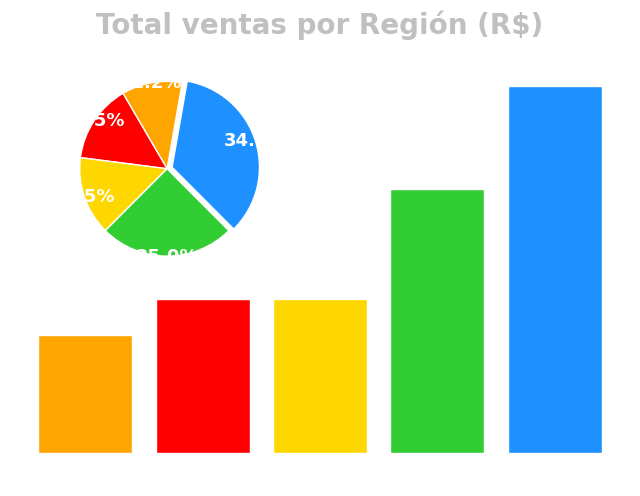

In [162]:
df=df_region_total.copy()

colores = [ 'orange' ,'limegreen', 'gold','dodgerblue', 'red']

####   GRAFICA DE BARRAS CON GRAFICA PIE   ####

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Datos de la gráfica de barras
# colores = ['#00b4d8','#adb5bd', '#dee2e6', '#90e0ef', '#0077b6']
# colores = [ 'dodgerblue','limegreen', 'orange' , 'gold', 'red']
colores = [ 'orange','red', 'gold' , 'limegreen', 'dodgerblue']

# labels = ['S-E', 'N-E', 'C-O', 'N', 'S']
bar_positions = np.arange(len(df['name_region']))
bar_heights = df['total']

# Crear la gráfica de barras
fig, ax = plt.subplots(figsize=(8, 5),facecolor='none')
ax.bar(bar_positions, bar_heights, color=colores)
plt.box(False)
plt.grid(False)
# Configuraciones de la gráfica de barras
ax.set_xticks(bar_positions)
ax.set_xticklabels(df['name_region'], fontsize=15,color='white')
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title(f'Total ventas por Región (R$)', color='silver', fontweight='bold', fontsize=20,pad=25)

# Mostrar etiquetas en las barras
for i, value in enumerate(bar_heights):
    ax.text(i, value, f'{value/1e6:,.1f}mll', ha='center', va='bottom', fontsize=16, color='white',fontweight='bold')

# Configuración adicional para quitar las líneas al lado de los ejes
ax.yaxis.tick_left()
ax.xaxis.tick_bottom()
ax.xaxis.set_tick_params(width=0)
ax.yaxis.set_tick_params(width=0)

#GRafica pie:
explode = (0, 0, 0, 0, 0.06)  # Separar la primera porción (Sureste)
axins = inset_axes(ax, width="50%", height="50%", loc='upper left', borderpad=0.3)
axins.pie(df['total'], autopct='%1.1f%%', colors=colores, startangle=80,
          textprops={'fontsize': 13,'color':'white','fontweight':'bold'}, labels=None, pctdistance=1,explode=explode)
# axins.axis('equal')


# Guardar la imagen como PNG
plt.savefig('/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/graf/ventas_regiones_brasil_new.png', dpi=300)
plt.box(False)
plt.axis('equal')  # Asegura que el gráfico de torta sea un círculo
plt.show()

###**

###**Obtener datos de PBI:**

In [163]:
####  Obtener datos del PBI  ####

url = "https://es.wikipedia.org/wiki/Anexo:Estados_de_Brasil_por_PIB_per_c%C3%A1pita_(nominal)"
tablas = pd.read_html(url)
tabla = tablas[0]

# Seleccionar las regiones de interés y los datos relevantes
regiones_interes = ['Centro-Oeste', 'Sudeste', 'Sur', 'Norte', 'Nordeste']
df_pib_usd_region = tabla[tabla[('Unidad', 'Unidad')].isin(regiones_interes)][[('Unidad', 'Unidad'), ('PIB per cápita', 'USD'), ('Población (2022)', 'Población (2022)')]]

# Renombrar columnas y realizar el procesamiento necesario
df_pib_usd_region.columns = ['Region', 'PBI_USD', 'Poblacion']
df_pib_usd_region['Poblacion_mll'] = round(df_pib_usd_region['Poblacion'] / 1e6, 2)
df_pib_usd_region.sort_values(by='Poblacion_mll', ascending=False, inplace=True)
df_pib_usd_region.drop('Poblacion', axis=1, inplace=True)
df_pib_usd_region.reset_index(drop=True, inplace=True)
df_pib_usd_region.sort_values(by='PBI_USD', ascending=True, inplace=True)

df_pib_usd_region


Region  PBI_USD  Poblacion_mll
1      Nordeste     4910          51.52
3         Norte     6683          17.35
2           Sur    10985          29.93
4  Centro-Oeste    11713          16.29
0       Sudeste    11979          84.85

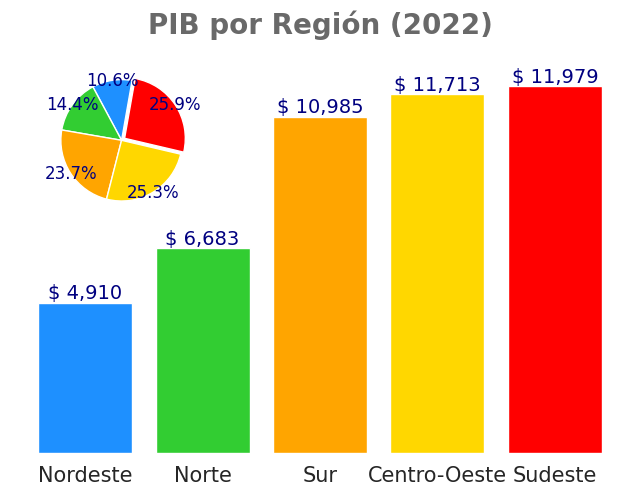

In [164]:
####   GRAFICA DE BARRAS CON GRAFICA PIE   ####

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

df=df_pib_usd_region.copy()
# colores = ['#00b4d8','#adb5bd', '#dee2e6', '#90e0ef', '#0077b6']
colores = [ 'dodgerblue','limegreen', 'orange' , 'gold', 'red']
# colores = [ 'gold','limegreen', 'orange' , 'dodgerblue', 'red']

# labels = ['S-E', 'N-E', 'C-O', 'N', 'S']
bar_positions = np.arange(len(df['Region']))
bar_heights = df['PBI_USD']

# Crear la gráfica de barras
fig, ax = plt.subplots(figsize=(8, 5),facecolor='none')
ax.bar(bar_positions, bar_heights, color=colores)
plt.box(False)
plt.grid(False)
# Configuraciones de la gráfica de barras
ax.set_xticks(bar_positions)
ax.set_xticklabels(df['Region'], fontsize=15)
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title(f'PIB por Región (2022)', color='dimgray', fontweight='bold', fontsize=20,pad=25)

# Mostrar etiquetas en las barras
for i, value in enumerate(bar_heights):
    ax.text(i, value, f'$ {value:,.0f}', ha='center', va='bottom', fontsize=14, color='navy')

# Configuración adicional para quitar las líneas al lado de los ejes
ax.yaxis.tick_left()
ax.xaxis.tick_bottom()
ax.xaxis.set_tick_params(width=0)
ax.yaxis.set_tick_params(width=0)

#GRafica pie:
explode = (0, 0, 0, 0, 0.06)  # Separar la primera porción (Sureste)
axins = inset_axes(ax, width="35%", height="35%", loc='upper left', borderpad=0.3)
axins.pie(df['PBI_USD'], autopct='%1.1f%%', colors=colores, startangle=80,
          textprops={'fontsize': 12,'color':'navy'}, labels=None, pctdistance=1,explode=explode)

axins.axis('equal')

# Guardar la imagen como PNG
plt.savefig('/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/graf/pib_regiones_brasil.png', dpi=300)
plt.box(False)
plt.show()


In [165]:
df=df_pib_usd_region.copy()
colores = [ 'dodgerblue','limegreen', 'orange' , 'gold', 'red']

labels = ['NE', 'N', 'S', 'CO', 'SE']
bar_positions = np.arange(len(df['Region']))
bar_heights = df['PBI_USD'].reset_index()
bar_heights['region'] = labels
bar_heights.drop(columns='index',axis=1,inplace=True)
bar_heights

PBI_USD region
0     4910     NE
1     6683      N
2    10985      S
3    11713     CO
4    11979     SE

In [166]:
Region={'Nordeste':'NE',
        'Norte':'N',
        'Sur': 'S',
        'Centro-Oeste':'CO',
        'Sudeste':'SE'}
df=df_pib_usd_region.copy()
df['Region_cod'] = df['Region'].map(Region)
df

Region  PBI_USD  Poblacion_mll Region_cod
1      Nordeste     4910          51.52         NE
3         Norte     6683          17.35          N
2           Sur    10985          29.93          S
4  Centro-Oeste    11713          16.29         CO
0       Sudeste    11979          84.85         SE

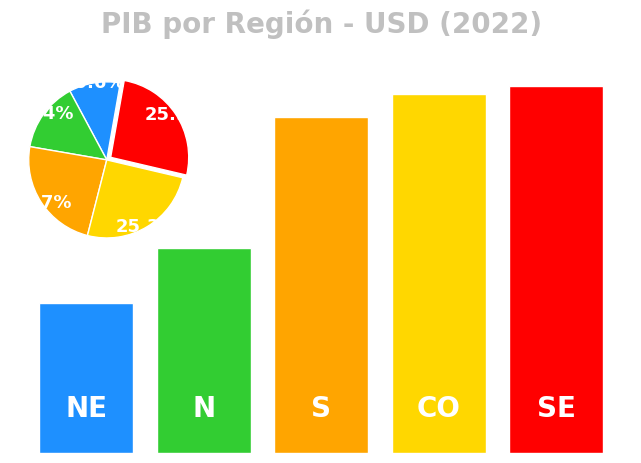

In [167]:
####  PBI: GRAFICA DE BARRAS CON GRAFICA PIE   ####

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

Region={'Nordeste':'NE',
        'Norte':'N',
        'Sur': 'S',
        'Centro-Oeste':'CO',
        'Sudeste':'SE'}

df=df_pib_usd_region.copy()
df['Region_cod'] = df['Region'].map(Region)


colores = [ 'dodgerblue','limegreen', 'orange' , 'gold', 'red']
bar_positions = np.arange(len(df['Region']))
bar_heights = df['PBI_USD']
codigo = df['Region_cod']

# Crear la gráfica de barras
fig, ax = plt.subplots(figsize=(8, 5),facecolor='none')
ax.bar(bar_positions, bar_heights, color=colores)
# ax.bar(bar_positions, bar_heights, color=colores,labels=labels)
plt.box(False)
plt.grid(False)
# Configuraciones de la gráfica de barras
ax.set_xticks(bar_positions)
ax.set_xticklabels([])
# ax.set_xticklabels(labels, fontsize=15,color='red')
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title(f'PIB por Región - USD (2022)', color='silver', fontweight='bold', fontsize=20,pad=25)

# Mostrar etiquetas en las barras
for i, value in enumerate(bar_heights):
    ax.text(i, value, f'{value/1000:,.1f}K', ha='center', va='bottom', fontsize=16, color='white',fontweight='bold')
for i, value in enumerate(codigo):
    ax.text(i, 1000, value, ha='center', va='bottom', fontsize=20, color='white',fontweight='bold')

# Configuración adicional para quitar las líneas al lado de los ejes
ax.yaxis.tick_left()
ax.xaxis.tick_bottom()
ax.xaxis.set_tick_params(width=0)
ax.yaxis.set_tick_params(width=0)

#GRafica pie:
explode = (0, 0, 0, 0, 0.06)  # Separar la primera porción (Sureste)
axins = inset_axes(ax, width="30%", height="45%", loc='upper left', borderpad=0.3)
axins.pie(df['PBI_USD'], autopct='%1.1f%%', colors=colores, startangle=80,
          textprops={'fontsize': 13,'color':'white','fontweight':'bold'}, labels=None, pctdistance=1,explode=explode)

axins.axis('equal')


# Guardar la imagen como PNG
plt.savefig('/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/graf/pib_regiones_brasil_new.png', dpi=300)
plt.box(False)
plt.show()


###**GRafica de Poblacion vs Región:**

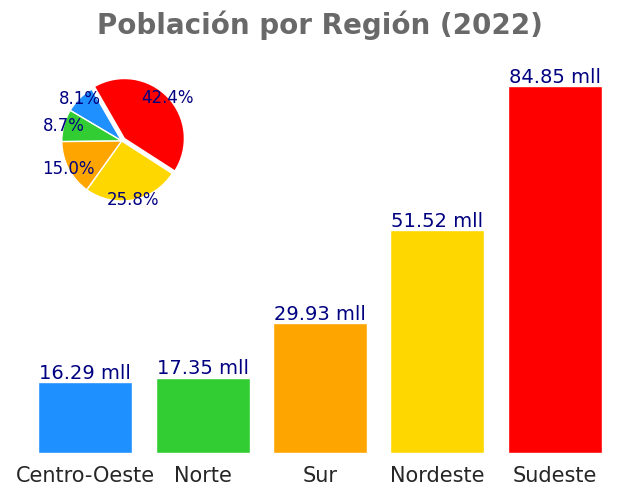

In [168]:
####  Población: GRAFICA DE BARRAS CON GRAFICA PIE   ####
Region={'Nordeste':'NE',
        'Norte':'N',
        'Sur': 'S',
        'Centro-Oeste':'CO',
        'Sudeste':'SE'}

df=df_pib_usd_region.sort_values(by='Poblacion_mll').copy()
df['Region_cod'] = df['Region'].map(Region)

colores = [ 'dodgerblue','limegreen', 'orange' , 'gold', 'red']
bar_positions = np.arange(len(df['Region']))
bar_heights = df['Poblacion_mll']

# Crear la gráfica de barras
fig, ax = plt.subplots(figsize=(8, 5),facecolor='none')
ax.bar(bar_positions, bar_heights, color=colores)
plt.box(False)
plt.grid(False)
# Configuraciones de la gráfica de barras
ax.set_xticks(bar_positions)
ax.set_xticklabels(df['Region'], fontsize=15)
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title(f'Población por Región (2022)', color='dimgray', fontweight='bold', fontsize=20,pad=25)

# Mostrar etiquetas en las barras
for i, value in enumerate(bar_heights):
    ax.text(i, value, f'{value:,.2f} mll', ha='center', va='bottom', fontsize=14, color='navy')

# Configuración adicional para quitar las líneas al lado de los ejes
ax.yaxis.tick_left()
ax.xaxis.tick_bottom()
ax.xaxis.set_tick_params(width=0)
ax.yaxis.set_tick_params(width=0)

#GRafica pie:
explode = (0, 0, 0, 0, 0.06)  # Separar la primera porción (Sureste)
axins = inset_axes(ax, width="35%", height="35%", loc='upper left', borderpad=0.3)
axins.pie(df['Poblacion_mll'], autopct='%1.1f%%', colors=colores, startangle=120,
          textprops={'fontsize': 12,'color':'navy'}, labels=None, pctdistance=1,explode=explode)
axins.axis('equal')


# Guardar la imagen como PNG
plt.savefig('/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/graf/pop_regiones_brasil.png', dpi=300)
plt.box(False)
plt.show()


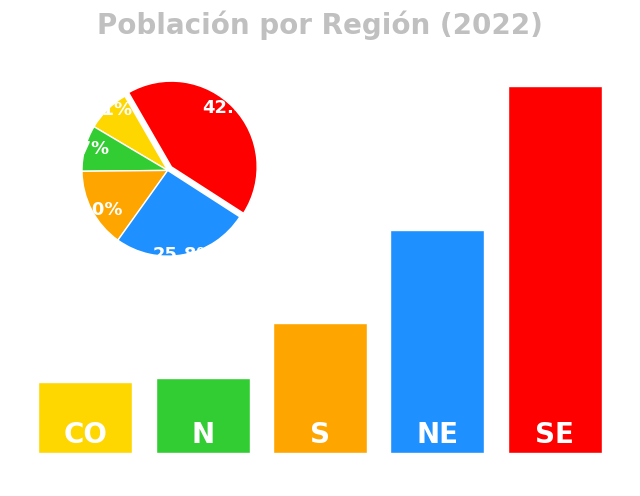

In [169]:
####  Población: GRAFICA DE BARRAS CON GRAFICA PIE   ####
Region={'Nordeste':'NE',
        'Norte':'N',
        'Sur': 'S',
        'Centro-Oeste':'CO',
        'Sudeste':'SE'}

df=df_pib_usd_region.sort_values(by='Poblacion_mll').copy()
df['Region_cod'] = df['Region'].map(Region)

colores = [ 'gold','limegreen', 'orange' , 'dodgerblue', 'red']
# colores = [ 'dodgerblue','limegreen', 'orange' , 'gold', 'red']

# labels = ['S-E', 'N-E', 'C-O', 'N', 'S']
bar_positions = np.arange(len(df['Region']))
bar_heights = df['Poblacion_mll']
codigo = df['Region_cod']

# Crear la gráfica de barras
fig, ax = plt.subplots(figsize=(8, 5),facecolor='none')
ax.bar(bar_positions, bar_heights, color=colores)
plt.box(False)
plt.grid(False)
# Configuraciones de la gráfica de barras
ax.set_xticks(bar_positions)
ax.set_xticklabels(df['Region'], fontsize=15,color='white')
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title(f'Población por Región (2022)', color='silver', fontweight='bold', fontsize=20,pad=25)

# Mostrar etiquetas en las barras
for i, value in enumerate(bar_heights):
    ax.text(i, value, f'{value:,.2f} mll', ha='center', va='bottom', fontsize=14, color='white',fontweight='bold')
    # ax.text(i, value, f'{value/1000:,.1f}K', ha='center', va='bottom', fontsize=16, color='white',fontweight='bold')
for i, value in enumerate(codigo):
    ax.text(i, 1, value, ha='center', va='bottom', fontsize=20, color='white',fontweight='bold')

# Configuración adicional para quitar las líneas al lado de los ejes
ax.yaxis.tick_left()
ax.xaxis.tick_bottom()
ax.xaxis.set_tick_params(width=0)
ax.yaxis.set_tick_params(width=0)

#GRafica pie:
explode = (0, 0, 0, 0, 0.06)  # Separar la primera porción (Sureste)
axins = inset_axes(ax, width="50%", height="50%", loc='upper left', borderpad=0.3)
axins.pie(df['Poblacion_mll'], autopct='%1.1f%%', colors=colores, startangle=120,
          textprops={'fontsize': 13,'color':'white','fontweight':'bold'}, labels=None, pctdistance=1,explode=explode)
axins.axis('equal')


# Guardar la imagen como PNG
plt.savefig('/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/graf/pop_regiones_brasil_new.png', dpi=300)
plt.box(False)
plt.show()


In [170]:
df_query_5.head(2)

pedido_id  producto_id  vendedor_id fecha_compra  total  id_recibo  \
0          1         5292            2   2020-02-16   3456      10062   
1        107        41189            2   2020-01-17    800       8839   

   cantidad  valor_unitario  valor_total ciudad  costo_envio  ganancia_neta  \
0         6             576         3456  BR-PE        691.2         2764.8   
1         5             160          800  BR-PE        160.0          640.0   

                producto  precio  marca       sku           condicion  \
0      Saia Jeans Forest   576.0  Mixed  222683.0  Nuevo con etiqueta   
1  Calca Acetinada Preta   160.0   Zara  176893.0               Usado   

   nombre_vendedor abbrev_state  code_state  name_state  code_region  \
0  Daniel Siqueira           PE        26.0  Pernambuco          2.0   
1  Daniel Siqueira           PE        26.0  Pernambuco          2.0   

  name_region                                           geometry  
0    Nordeste  MULTIPOLYGON (((-32.39705 -3.83294, -32.39774 ...  
1    Nordeste  MULTIPOLYGON (((-32.39705 -3.83294, -32.39774 ...

In [171]:
df_query_5[['abbrev_state', 'name_region','name_state']].head(1)

abbrev_state name_region  name_state
0           PE    Nordeste  Pernambuco

In [172]:
br_uf_d.head(1)

geometry abbrev_state  \
0  MULTIPOLYGON (((-63.32721 -7.97672, -62.86662 ...           RO   

   ingresos_netos  Population     state  
0       1317495.2     1581016  Rondônia

In [173]:
# br_uf_d = pd.merge(br_uf_d, df_query_5[['abbrev_state', 'name_region','name_state', 'geometry']], on='abbrev_state')
# br_uf_d

In [174]:
# import geopandas as gpd
# import matplotlib.pyplot as plt

# # Cargar los límites de los estados de Brasil
# br_uf = geobr.read_state()

# # Fusionar con los datos de ingresos netos
# # br_uf_d = br_uf.merge(df_query_5, on='abbrev_state')
# # br_uf_d = br_uf_d[['geometry_x', 'abbrev_state', 'ganancia_neta']]
# # br_uf_d = pd.merge(br_uf_d, df_query_5[['abbrev_state', 'name_region','name_state', 'geometry']], on='abbrev_state')

# # Mapear el nombre completo del estado
# # br_uf_d['state'] = br_uf_d['abbrev_state'].map(ciudades)

# br_uf_d_geo = gpd.GeoDataFrame(br_uf_d, geometry='geometry_x')

# # Proyectar a un sistema de coordenadas específico
# br_uf_d_projected = br_uf_d_geo.to_crs('EPSG:3857')
# # Definir los colores para cada región
# region_colors = {
#     'Norte': 'lightblue',
#     'Nordeste': 'lightgreen',
#     'Centro Oeste': 'orange',
#     'Sudeste': 'lightpink',
#     'Sul': 'lightyellow'
# }

# # Colorear los estados según la región
# fig, ax = plt.subplots(1, 1, figsize=(15, 10))
# for region, color in region_colors.items():
#     br_uf_d_projected[br_uf_d_projected['name_region'] == region].plot(ax=ax, color=color, edgecolor='0.8')

# # Agregar el nombre de la ciudad en cada lugar
# for x, y, label in zip(br_uf_d_projected.geometry.centroid.x, br_uf_d_projected.geometry.centroid.y, br_uf_d_projected.state):
#     ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize=9, color='black')

# plt.title('Mapa de Estados de Brasil Coloreado por Región', fontsize=20, color='dimgray', fontweight='bold', pad=30)
# plt.axis('off')
# plt.show()


###**Marca Mixed:**

In [175]:
df_mixed_count=df_query_5[df_query_5.marca=='Mixed']['condicion'].value_counts().reset_index()
df_mixed_total=df_query_5[df_query_5.marca=='Mixed'][['condicion','total']].groupby('condicion')['total'].sum().reset_index()
df_mixed = pd.merge(df_mixed_count, df_mixed_total, on='condicion', suffixes=('_count', '_total'))
df_mixed.columns = ['condicion', 'count', 'total']
df_mixed

condicion  count    total
0               Usado    948  3277923
1  Nuevo con etiqueta    725  1311218

In [176]:
# Camisa Xadrez Azul (podria ser cualquiera de los 2, por defecto dejo "F").
# Las "Regatas" le dicen a las musculosas y son bien "U", pero depende el modelo tambien

clasificando_productos_unisex = {
    "productos" : ['Oculos Metal', 'Bolsa Classica Roxa', 'Camisa Jeans Classica',
       'Camisa Xadrez Azul', 'Regata Nude Textura',
       'Blusinha Guipir Black', 'Calca Ziper Preto',
       'Casaco Preto Botoes', 'Saia Amarela Faixa', 'Calca Jeans Basica',
       'Tenis Xadrez Tecido', 'Body Estampa Coracoes',
       'Conjunto Body Calca', 'Macaquinho Tricot Bege',
       'Calca Preta Resinada', 'Vestido Nude Reta', 'Calca Veludo Cotele',
       'Blusa Tricot Mescla', 'Blazer Cinza E Azul Marinho',
       'Calca Estampa Flare', 'Blusa Babados Cats',
       'Vestido Preto Franzido', 'Vestido Estampa Pb',
       'Cropped Courino Texturas', 'Vestido Preto Amarracao', ###
       'Regata Listras Azul', 'Regata Estampa Roxa', 'Calca Estampa Pb',
       'Vestido Polo Lilas', 'Blusa Tricot Lilas', ###
       'Bolsa Vermelha Brilhos', 'Oculos Lente Azulada',
       'Bermuda Jeans Lavagem', 'Calca Jeans Costuras',
       'Shorts Listras Bordados', 'Mala Bolsos Preta',
       'Regata Bicolor Alcinha', 'Vestido Estampa Laco',
       'Scarpin Bege Textura', 'Bolsa Intrecciato Caramelo',
       'Vestido Malha Cinza', 'Sneaker Monograma Bege',
       'Clutch Preta Pregas', 'Blusa Malha Azul',
       'Bermuda Listras Bolsos', 'Vestido Listras Malha',
       'Tenis Tecido Purple', 'Calca Jeans Trancada'], # SON 48 PRODUCTOS

    "genero" : ['F','F','M','F','F','F','F','F','F','F','F','F','F','F','F','F',
                'F','F','M','F','F','F','F','F','F','M','F','F','F','F','F','M',
                'M','F','F','M','F','F','F','F','F','F','F','F','M','F','F','F']
                                  }


df_clasificando_productos_unisex  = pd.DataFrame(clasificando_productos_unisex )
df_clasificando_productos_unisex
df_clasificando_productos_unisex.head()

diccionario_productos_genero = {}

for registro in df_clasificando_productos_unisex.to_dict(orient='records'):
    diccionario_productos_genero[registro['productos']] = registro['genero']

diccionario_productos_genero


{'Oculos Metal': 'F',
 'Bolsa Classica Roxa': 'F',
 'Camisa Jeans Classica': 'M',
 'Camisa Xadrez Azul': 'F',
 'Regata Nude Textura': 'F',
 'Blusinha Guipir Black': 'F',
 'Calca Ziper Preto': 'F',
 'Casaco Preto Botoes': 'F',
 'Saia Amarela Faixa': 'F',
 'Calca Jeans Basica': 'F',
 'Tenis Xadrez Tecido': 'F',
 'Body Estampa Coracoes': 'F',
 'Conjunto Body Calca': 'F',
 'Macaquinho Tricot Bege': 'F',
 'Calca Preta Resinada': 'F',
 'Vestido Nude Reta': 'F',
 'Calca Veludo Cotele': 'F',
 'Blusa Tricot Mescla': 'F',
 'Blazer Cinza E Azul Marinho': 'M',
 'Calca Estampa Flare': 'F',
 'Blusa Babados Cats': 'F',
 'Vestido Preto Franzido': 'F',
 'Vestido Estampa Pb': 'F',
 'Cropped Courino Texturas': 'F',
 'Vestido Preto Amarracao': 'F',
 'Regata Listras Azul': 'M',
 'Regata Estampa Roxa': 'F',
 'Calca Estampa Pb': 'F',
 'Vestido Polo Lilas': 'F',
 'Blusa Tricot Lilas': 'F',
 'Bolsa Vermelha Brilhos': 'F',
 'Oculos Lente Azulada': 'M',
 'Bermuda Jeans Lavagem': 'M',
 'Calca Jeans Costuras': 'F'

In [177]:
diccionario_productos_genero={'Oculos Metal': 'F', 'Bolsa Classica Roxa': 'F', 'Camisa Jeans Classica': 'M', 'Camisa Xadrez Azul': 'F', 'Regata Nude Textura': 'F', 'Blusinha Guipir Black': 'F', 'Calca Ziper Preto': 'F', 'Casaco Preto Botoes': 'F', 'Saia Amarela Faixa': 'F', 'Calca Jeans Basica': 'F', 'Tenis Xadrez Tecido': 'F', 'Body Estampa Coracoes': 'F', 'Conjunto Body Calca': 'F', 'Macaquinho Tricot Bege': 'F', 'Calca Preta Resinada': 'F', 'Vestido Nude Reta': 'F', 'Calca Veludo Cotele': 'F', 'Blusa Tricot Mescla': 'F', 'Blazer Cinza E Azul Marinho': 'M', 'Calca Estampa Flare': 'F', 'Blusa Babados Cats': 'F', 'Vestido Preto Franzido': 'F', 'Vestido Estampa Pb': 'F', 'Cropped Courino Texturas': 'F', 'Vestido Preto Amarracao': 'F', 'Regata Listras Azul': 'M', 'Regata Estampa Roxa': 'F', 'Calca Estampa Pb': 'F', 'Vestido Polo Lilas': 'F', 'Blusa Tricot Lilas': 'F', 'Bolsa Vermelha Brilhos': 'F', 'Oculos Lente Azulada': 'M', 'Bermuda Jeans Lavagem': 'M', 'Calca Jeans Costuras': 'F', 'Shorts Listras Bordados': 'F', 'Mala Bolsos Preta': 'M', 'Regata Bicolor Alcinha': 'F', 'Vestido Estampa Laco': 'F', 'Scarpin Bege Textura': 'F', 'Bolsa Intrecciato Caramelo': 'F', 'Vestido Malha Cinza': 'F', 'Sneaker Monograma Bege': 'F', 'Clutch Preta Pregas': 'F', 'Blusa Malha Azul': 'F', 'Bermuda Listras Bolsos': 'M', 'Vestido Listras Malha': 'F', 'Tenis Tecido Purple': 'F', 'Calca Jeans Trancada': 'F'}


In [178]:
marca = {
    'marca': ['D&g Dolce & Gabbana', 'Givenchy', 'Joe Fresh', 'Mixed', 'Zara',
       'Gap', 'Banana Republic', 'Fyi', 'Sacada', 'Rag & Bone', 'Cori',
       'Forever 21', 'Tigresse', 'Tory Burch', 'Brooksfield', 'Animale',
       '284', 'Dkny', 'Cheroy', 'Canal', 'Le Lis Blanc', 'Spezzato',
       'Cantão', 'Talie Nk', 'H&M', 'Schutz', 'Jorge Bischoff', #27
       'Luisa Farani', 'Seven', 'Kipling', 'Louis Vuitton', 'Agilità',
       'Fabiana Caterina', 'Reinaldo Lourenço', 'Karmani', 'Erre Erre',
       'H&m', 'Forum', 'Ellus', 'J. Crew', "Joe's", 'Galeria Tricot',
       'Loft 747', 'Oxyfit', 'Topshop', 'A.brand', 'Isolda',
       'American Eagle', 'Colcci', 'Carter’s', 'Thay Ribas', #51
       'Carina Duek', 'Kate Spade', 'Bottega Veneta', 'Morena Rosa',
       'Luiza Barcelos', 'Lezalez', 'My Place', 'Farm', 'Armani Exchange',
       'Bcbgmaxzria', 'Dica da Ka', 'My Shoes', 'Argentum',
       'Red Valentino', 'Maria Filó', 'Marc By Marcjacobs',
       'Track & Field', 'Christian Dior', 'Toca do Coelho',
       'Barbara Bela', 'Miu Miu', 'Gregory', 'Prada', 'Steal The Look',
       'Shoulder', 'Maria Bonita', 'Isa Kulikovski', 'Ralph Lauren',
       'Camila Klein', 'Bazar Genial', 'Hollister', 'Diesel', #83
       'All Saints Spitalfields', 'Iorane', 'Felini', 'Miss Sixty',
       'Linda de Morrer', 'Vera Wang', 'Daslu', 'Adidas', 'Amaro',
       'Jimmy Choo', 'Sweet Cotton', 'Cris Barros', 'Mara Mac',
       'Paula Raia', 'Dress&co', 'Mango', 'Ateliê de Calças', 'Thelure', #101
       'Converse', "Levi's", 'Lemon Cola', 'Limone By Jade Seba',
       'Espaço Fashion', 'Seal Brasil', 'Alix Shop', 'Bo. bô.',
       'Lauren Ralph Lauren', 'Christian Louboutin', 'Saad', 'Osklen',
       'Skazi', 'Carol Bassi', 'Calvin Klein', 'Express','Bobô'],


    'marca_genero': ['U', 'F', 'F', 'F', "F", "U", "U", "U", "F", "F", "F", "F", "F", "F", "M", "F",
                              "F", "F", "F", "U", "F", "F", "F", "U", "U", "F", "F", "F", "U", "U", "U", "F", "F",
                              "F", "F", "F", "U", "M", "U", "F", "U", "F", "F", "F", "F", "F", "F", "U", "F",
                              "U", "F", "F", "F", "U", "F", "F", "F", "F", "F", "M", "F", "F", "F", "F", "U",
                              "F", "F", "F", "U", "U", "F", "F", "U", "F", "F", "F", "F", "F", "U", "F", "U",
                              "U", "U", "U", "F", "M", "F", "F", "F", "F", "U", "F", "U", "F", "F", "U", "F",
                              "F", "F", "F", "F", "U", "U", "F", "F", "F", "M", "F", "F", "F", "F", "U", "U",
                               "F", "F", "U", "U","F"]}



df_marca_genero = pd.DataFrame(marca)
df_all = pd.merge(df_query_5, df_marca_genero, on='marca', how='inner')
df_all['product_genero']=df_all['marca_genero']


In [179]:
mapeo=diccionario_productos_genero
df_all['product_genero'] = df_all['producto'].map(mapeo).fillna(df_all['product_genero'])
df_all.product_genero.value_counts()

product_genero
F    22871
M     1655
Name: count, dtype: int64

In [180]:
ganancia_por_vendedor_genero_producto_ano2019al2020=df_all.groupby(['nombre_vendedor',	'product_genero'])['ganancia_neta'].sum().reset_index()
df=ganancia_por_vendedor_genero_producto_ano2019al2020
total = df.groupby('nombre_vendedor')['ganancia_neta'].sum().reset_index()

# Renombrar la columna para evitar conflictos al unir DataFrames
total.rename(columns={'ganancia_neta': 'ganancia_total'}, inplace=True)

# Combinar el DataFrame total con el DataFrame original
df = pd.merge(df, total, on='nombre_vendedor')

# Calcular el porcentaje de ganancia neta para cada combinación de nombre de vendedor y género
df['porcentaje'] = df['ganancia_neta'] / df['ganancia_total'] * 100
df=df[['nombre_vendedor',	'product_genero',	'ganancia_neta',	'porcentaje']]
df

nombre_vendedor product_genero  ganancia_neta  porcentaje
0       Ana Duarte              F      7406341.6   95.494950
1       Ana Duarte              M       349400.0    4.505050
2  Daniel Siqueira              F      7355462.4   95.437009
3  Daniel Siqueira              M       351676.0    4.562991
4  Millena Pereira              F      5956924.0   95.189490
5  Millena Pereira              M       301040.0    4.810510
6   Nadia Oliveira              F      6786192.8   94.859929
7   Nadia Oliveira              M       367716.0    5.140071
8    Paulo Calanca              F      7411359.2   95.411706
9    Paulo Calanca              M       356408.0    4.588294

In [181]:
perct_women=df[df['product_genero']=='F']
perct_men=df[df['product_genero']=='M']

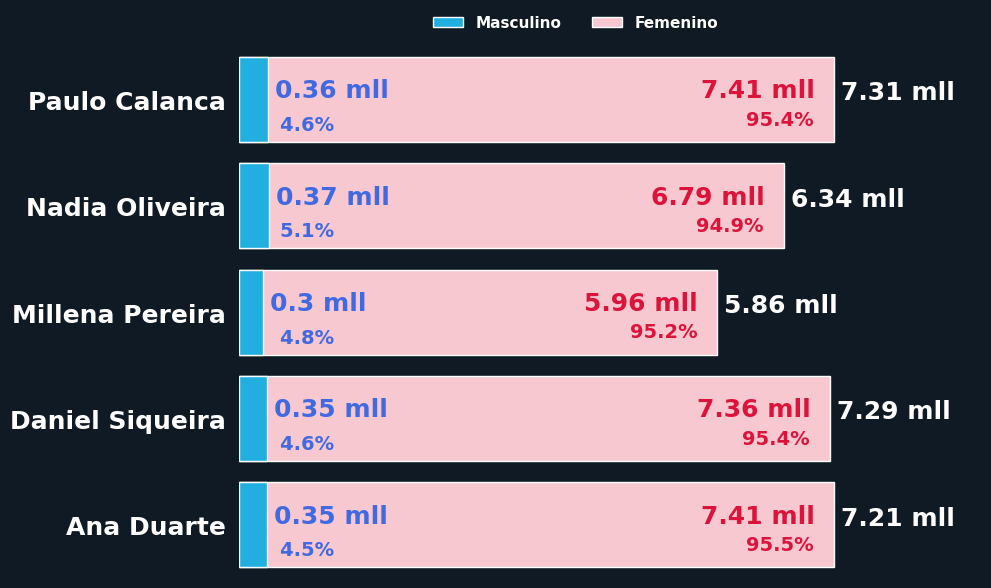

In [182]:
ganancia_por_vendedor_genero_producto_ano2019al2020=df_all.groupby(['nombre_vendedor',	'product_genero'])['ganancia_neta'].sum().reset_index()
df=ganancia_por_vendedor_genero_producto_ano2019al2020
total = df.groupby('nombre_vendedor')['ganancia_neta'].sum().reset_index()

# Renombrar la columna para evitar conflictos al unir DataFrames
total.rename(columns={'ganancia_neta': 'ganancia_total'}, inplace=True)

# Combinar el DataFrame total con el DataFrame original
df = pd.merge(df, total, on='nombre_vendedor')

# Calcular el porcentaje de ganancia neta para cada combinación de nombre de vendedor y género
df['porcentaje'] = df['ganancia_neta'] / df['ganancia_total'] * 100
df=df[['nombre_vendedor',	'product_genero',	'ganancia_neta',	'porcentaje']]

perct_women=df[df['product_genero']=='F']
perct_men=df[df['product_genero']=='M']

plt.subplots(figsize=(10, 6),facecolor='#101a24')

ganancia_vendedor_2019and2020=ganancia_por_vendedor_genero_ano2019al2020.groupby('nombre_vendedor')['ganancia_neta'].sum().reset_index()

ax = sns.barplot(data=df, y='nombre_vendedor', x='ganancia_neta', hue='product_genero', hue_order=['F', 'M'], palette=['pink','deepskyblue'], errorbar=None, dodge=False)

plt.xlabel('')
plt.ylabel('')
# plt.title('Ganancia Neta por Vendedor y Género de Marca\n         años 2019 y 2020',fontsize=20, color='dimgray', fontweight='bold',pad=35)
plt.gca().invert_yaxis()

# Mostrar los valores en las barras
for p in ax.patches:
  if (p.get_width() != 0) and (p.get_width() < 5e5):
        ax.annotate(f'{str(round(p.get_width()/1e6,2))} mll', (p.get_width(), p.get_y() + p.get_height() / 2+.02), xytext=(5, 5), textcoords='offset points', ha='left', va='center', color='royalblue', fontsize=18,fontweight= 'bold')

for p, total,women,men in zip(ax.patches,ganancia_vendedor_2019and2020.ganancia_neta,perct_women.porcentaje,perct_men.porcentaje):
  if (p.get_width() != 0) and (p.get_width() > 3e6):
        ax.annotate(f'{str(round(p.get_width()/1e6,2))} mll   ', (p.get_width(), p.get_y() + p.get_height() / 2+.02), xytext=(5, 5), textcoords='offset points', ha='right', va='center', color='crimson', fontsize=18,fontweight= 'bold')
        ax.annotate(f'{women:.1f}%    ', (p.get_width(), p.get_y() + p.get_height() / 2-.25), xytext=(5, 5), textcoords='offset points', ha='right', va='center', color='crimson', fontsize=14,fontweight= 'bold')
        ax.annotate(f'{men:.1f}%    ', (1.5e6, p.get_y() + p.get_height() / 2-.25), xytext=(1, 1), textcoords='offset points', ha='right', va='center', color='royalblue', fontsize=14,fontweight= 'bold')
        ax.annotate(f'{str(round(total/1e6,2))} mll   ', (p.get_width(), p.get_y() + p.get_height() / 2), xytext=(5, 5), textcoords='offset points', ha='left', va='center', color='white', fontsize=18,fontweight= 'bold')

plt.xticks([])
plt.yticks(color='white', fontsize=18,fontweight= 'bold')
plt.grid(False)
plt.box(False)
# plt.yticks([])

# Ajustar la leyenda
handles, labels = ax.get_legend_handles_labels()
handles.reverse()
labels.reverse()
ax.legend(handles=handles, labels=['Masculino','Femenino'], title='', bbox_to_anchor=(0.3, 1.07), loc='upper left', borderaxespad=0., ncol=3, frameon=False,fontsize=20,labelcolor='white',prop={'weight': 'bold'})
# plt.legend(title='', loc='upper center', frameon=False, fontsize=14, ncol=3, labelcolor='white')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/graf/ganancia_por_vendedor_genero_producto_ano2019al2020.png', dpi=300)
plt.show()

In [183]:
df_ganancia_genero=df_all.groupby('product_genero')['ganancia_neta'].sum().reset_index()
total_ganancia = df_ganancia_genero.ganancia_neta.sum()

# # Calcular el porcentaje relativo para cada género de producto
df_ganancia_genero['porcentaje_relativo'] = (df_ganancia_genero.ganancia_neta / total_ganancia) * 100

df_ganancia_genero

product_genero  ganancia_neta  porcentaje_relativo
0              F     34916280.0             95.28897
1              M      1726240.0              4.71103

In [185]:
prod=df_query_5[df_query_5.marca=='Christian Dior']
prod.groupby(['producto','condicion','valor_unitario'])['marca'].unique()

producto             condicion  valor_unitario
Bolsa Classica Roxa  Usado      6500              [Christian Dior]
Oculos Metal         Usado      750               [Christian Dior]
Name: marca, dtype: object

In [186]:
prod=df_query_5[df_query_5.marca=='Mixed']
prod.groupby(['producto','condicion','valor_unitario'])['marca'].unique()

producto                 condicion           valor_unitario
Blusa Cinza              Usado               590               [Mixed]
Calca Alfaiataria Preta  Usado               490               [Mixed]
Calca Linho Ten          Nuevo con etiqueta  398               [Mixed]
Camisa Seda Pb           Usado               399               [Mixed]
Camisa Tear Folk         Nuevo con etiqueta  100               [Mixed]
Camiseta Cindy Sky       Nuevo con etiqueta  586               [Mixed]
Camiseta Eternity        Nuevo con etiqueta  644               [Mixed]
Camiseta Tencel Umay     Nuevo con etiqueta  788               [Mixed]
Casaqueto Fio Mescla     Usado               790               [Mixed]
Saia Couro Tijolo        Usado               3800              [Mixed]
Saia Guipir Nude         Usado               740               [Mixed]
Saia Jeans Forest        Nuevo con etiqueta  576               [Mixed]
Saia Preta Babado        Usado               320               [Mixed]
Vestido Jeans Omb

In [187]:
prod=df_query_5[df_query_5.marca=='Bottega Veneta']
prod.groupby(['producto','condicion','valor_unitario'])['marca'].unique()

producto                    condicion  valor_unitario
Bolsa Intrecciato Caramelo  Usado      6175              [Bottega Veneta]
Name: marca, dtype: object

In [188]:
prod=df_query_5[df_query_5.marca=='Christian Louboutin']
prod.groupby(['producto','condicion','valor_unitario'])['marca'].unique()

producto           condicion  valor_unitario
Sapato Cetim Pink  Usado      3900              [Christian Louboutin]
Name: marca, dtype: object

In [189]:
prod.cantidad.value_counts().sum()

135

In [190]:
135*3900

526500

In [224]:
df=df_query_5
# Convertir la columna fecha_compra al formato de fecha
df['fecha_compra'] = pd.to_datetime(df['fecha_compra'])

# Filtrar los datos para seleccionar solo el mes de diciembre de 2020
df_diciembre_2020 = df[(df['fecha_compra'].dt.year == 2020) & (df['fecha_compra'].dt.month == 12)]
df_diciembre_2020.head()

pedido_id  producto_id  vendedor_id fecha_compra  total  id_recibo  \
13       1955        50330            3   2020-12-18    840      22510   
27       3887        40082            3   2020-12-18   1260      22515   
62       9432       100932            3   2020-12-16  23400      22305   
82      12101        93262            4   2020-12-21    450      22742   
83      12141        64127            4   2020-12-13   3540      22095   

    cantidad  valor_unitario  valor_total ciudad  costo_envio  ganancia_neta  \
13         4             210          840  BR-PE        168.0          672.0   
27         4             315         1260  BR-PE        252.0         1008.0   
62         6            3900        23400  BR-PE       4680.0        18720.0   
82         1             450          450  BR-PE         90.0          360.0   
83         6             590         3540  BR-PE        708.0         2832.0   

                   producto  precio                marca       sku condicion  \
13        Camisa Jeans Azul   210.0                 Zara  250096.0     Usado   
27     Vestido Malha Vitral   315.0                Forum  324684.0     Usado   
62        Sapato Cetim Pink  3900.0  Christian Louboutin  304370.0     Usado   
82  Sandalia Prata Pedraria   450.0           Thay Ribas  233379.0     Usado   
83   Vestido Textura Branco   590.0              J. Crew  317928.0     Usado   

    nombre_vendedor abbrev_state  code_state  name_state  code_region  \
13   Nadia Oliveira           PE        26.0  Pernambuco          2.0   
27   Nadia Oliveira           PE        26.0  Pernambuco          2.0   
62   Nadia Oliveira           PE        26.0  Pernambuco          2.0   
82  Millena Pereira           PE        26.0  Pernambuco          2.0   
83  Millena Pereira           PE        26.0  Pernambuco          2.0   

   name_region                                           geometry  
13    Nordeste  MULTIPOLYGON (((-32.39705 -3.83294, -32.39774 ...  
27    Nordeste  MULTIPOLYGON (((-32.39705 -3.83294, -32.39774 ...  
62    Nordeste  MULTIPOLYGON (((-32.39705 -3.83294, -32.39774 ...  
82    Nordeste  MULTIPOLYGON (((-32.39705 -3.83294, -32.39774 ...  
83    Nordeste  MULTIPOLYGON (((-32.39705 -3.83294, -32.39774 ...

In [236]:
df_diciembre_2020_state=df_diciembre_2020.groupby('name_state')['ganancia_neta'].sum().reset_index().sort_values(by='ganancia_neta',ascending=False)
df_diciembre_2020_state['ganancia_neta']=df_diciembre_2020_state['ganancia_neta'].astype(int)
df_diciembre_2020_state

name_state  ganancia_neta
9              Maranhão         135148
2                 Amapá         133039
13               Paraná         129217
6      Distrito Federal         123132
23       Santa Catarina         121348
18       Rio De Janeiro         118460
17                Piauí         114006
1               Alagoas         113487
16           Pernambuco         109905
20    Rio Grande Do Sul         109724
8                 Goiás         107305
3              Amazonas         107255
24              Sergipe         106074
11   Mato Grosso Do Sul         102269
4                 Bahia         100066
25            São Paulo          97013
5                 Ceará          93247
22              Roraima          91969
15                 Pará          90283
10          Mato Grosso          89212
0                  Acre          88608
21             Rondônia          85522
19  Rio Grande Do Norte          83967
14              Paraíba          83402
7        Espirito Santo          82303
12         Minas Gerais          80197
26            Tocantins          67256

In [237]:
df_diciembre_2020_marca=df_diciembre_2020.groupby('marca')['ganancia_neta'].sum().reset_index().sort_values(by='ganancia_neta',ascending=False).head(10)
df_diciembre_2020_marca['ganancia_neta']=df_diciembre_2020_marca['ganancia_neta'].astype(int)
df_diciembre_2020_marca

marca  ganancia_neta
85                 Mixed         281613
27        Christian Dior         203400
13          Barbara Bela         178080
51              Givenchy         118400
60            Jimmy Choo         107744
17        Bottega Veneta         103740
28   Christian Louboutin          87360
116                 Zara          86305
92                 Prada          83200
8                Animale          70247

In [288]:
df_marcas_top5_and_others=df_query_5.groupby('marca')['ganancia_neta'].sum().reset_index().sort_values('ganancia_neta', ascending=False)
df_marcas_top5_and_others.head(6)

marca  ganancia_neta
85                 Mixed      3671312.8
27        Christian Dior      2529200.0
17        Bottega Veneta      1773460.0
28   Christian Louboutin      1457040.0
13          Barbara Bela      1451520.0
116                 Zara      1159305.6

In [260]:
# df_marcas_top5_and_others=df_marcas_top5_and_others.head(5).copy()
df_marcas_top5_ganancia=df_marcas_top5_and_others.iloc[:5].copy()
df_marcas_top5_ganancia

marca  ganancia_neta
85                Mixed      3671312.8
27       Christian Dior      2529200.0
17       Bottega Veneta      1773460.0
28  Christian Louboutin      1457040.0
13         Barbara Bela      1451520.0

In [297]:
ganancias_marcas_otros=df_marcas_top5_and_others.ganancia_neta[5:].sum()
ganancias_marcas_otros

25759987.0

In [298]:
ganancias_marcas_otros=df_marcas_top5_and_others.ganancia_neta[5:].sum()
nueva_fila = {'marca': 'otros', 'ganancia_neta': ganancias_marcas_otros}
nuevo_df = pd.DataFrame([nueva_fila])
df_marcas_top5_and_others = pd.concat([df_marcas_top5_ganancia, nuevo_df], ignore_index=True)
df_marcas_top5_and_others

marca  ganancia_neta
0                Mixed      3671312.8
1       Christian Dior      2529200.0
2       Bottega Veneta      1773460.0
3  Christian Louboutin      1457040.0
4         Barbara Bela      1451520.0
5                otros     25759987.0

In [270]:
df = df_marcas_top5_and_others.set_index('marca')
df

ganancia_neta
marca                             
Mixed                    3671312.8
Christian Dior           2529200.0
Bottega Veneta           1773460.0
Christian Louboutin      1457040.0
Barbara Bela             1451520.0
otros                   25759987.0

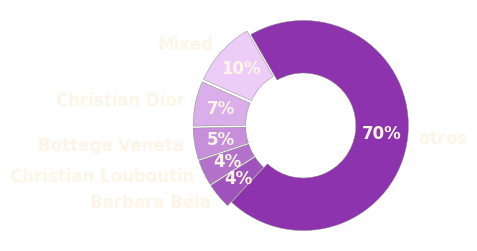

In [284]:
# Convertir la columna "marca" en el índice del DataFrame
df_filtered = df_marcas_top5_and_others.set_index('marca')

# df=df_marcas_top5_and_others.copy()

# Obtener las marcas que superan el 4% y sumar los porcentajes del resto
# df_filtered = df[df['ganancia_neta'] > df['ganancia_neta'].sum() * 0.04]
# otros = df[df['ganancia_neta'] <= df['ganancia_neta'].sum() * 0.04]['ganancia_neta'].sum()
# df_filtered.loc['Otros'] = otros

# Crear el gráfico de pastel
plt.figure(figsize=(3, 3),facecolor='none')
# plt.title('Distribución de ganancias por marca')

# Utilizar colores predeterminados de Seaborn
colors = sns.color_palette("blend:#EDCDF8,#8D33AD", len(df_filtered))
explode = [0.05,.05,.05,.05,.05,0]
wedgeprops = {'edgecolor': 'gray', 'linewidth': .3, 'width':.5}
text_props = {'color':'oldlace', 'fontsize': 12,'fontweight':'bold'}
plt.pie(df_filtered['ganancia_neta'],explode=explode, labels=df_filtered.index, colors=colors, autopct='%1.0f%%', startangle=120,textprops=text_props,wedgeprops=wedgeprops,pctdistance=0.75)
# plt.pie(df_filtered['ganancia_neta'], labels=df_filtered.index, colors=colors, autopct='%1.0f%%', startangle=120,textprops=text_props,wedgeprops=wedgeprops)

# Mostrar el gráfico
plt.axis('equal')  # Asegurar que el gráfico de pastel sea circular
plt.savefig('/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/graf/pie_marca_ganancias.png', dpi=100, bbox_inches='tight')

plt.show()


In [290]:
df=df_query_5.groupby('producto')['ganancia_neta'].sum().reset_index().sort_values('ganancia_neta', ascending=False)
df

producto  ganancia_neta
40          Bolsa Classica Roxa      2288000.0
42   Bolsa Intrecciato Caramelo      1773460.0
142           Sapato Cetim Pink      1457040.0
178         Vestido Longo Preto      1451520.0
120           Saia Couro Tijolo      1401440.0
..                          ...            ...
148       Shorts Estampa Floral        28512.0
153               Shorts Poa Pb        28480.0
157       Top Cropped Coqueiros        25152.0
103      Macaquinho Tricot Bege        16520.0
167        Vestido Estampa Laco        14904.0

[201 rows x 2 columns]

In [291]:
df_producto_top5_ganancia=df.iloc[:5].copy()
df_producto_top5_ganancia

producto  ganancia_neta
40          Bolsa Classica Roxa      2288000.0
42   Bolsa Intrecciato Caramelo      1773460.0
142           Sapato Cetim Pink      1457040.0
178         Vestido Longo Preto      1451520.0
120           Saia Couro Tijolo      1401440.0

In [300]:
ganancias_pproductos_otros=df.ganancia_neta[5:].sum()
nueva_fila = {'producto': 'otros', 'ganancia_neta': ganancias_pproductos_otros}
nuevo_df = pd.DataFrame([nueva_fila])
df_productos_top5_and_others = pd.concat([df_producto_top5_ganancia, nuevo_df], ignore_index=True)
df_productos_top5_and_others

producto  ganancia_neta
0         Bolsa Classica Roxa      2288000.0
1  Bolsa Intrecciato Caramelo      1773460.0
2           Sapato Cetim Pink      1457040.0
3         Vestido Longo Preto      1451520.0
4           Saia Couro Tijolo      1401440.0
5                       otros     28271060.0

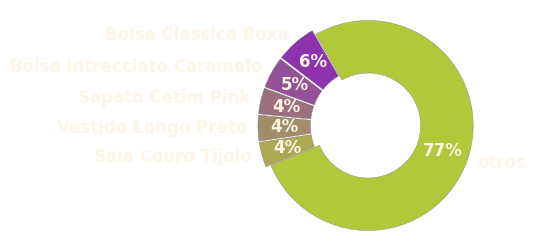

In [304]:
df_filtered = df_productos_top5_and_others.set_index('producto')

plt.figure(figsize=(3, 3),facecolor='none')

# Utilizar colores predeterminados de Seaborn
colors = sns.color_palette("blend:#8D33AD,#B2C83B", len(df_filtered))
explode = [0.05,.05,.05,.05,.05,0]
wedgeprops = {'edgecolor': 'gray', 'linewidth': .3, 'width':.5}
text_props = {'color':'oldlace', 'fontsize': 12,'fontweight':'bold'}
plt.pie(df_filtered['ganancia_neta'],explode=explode, labels=df_filtered.index, colors=colors, autopct='%1.0f%%', startangle=120,textprops=text_props,wedgeprops=wedgeprops,pctdistance=0.75)
# plt.pie(df_filtered['ganancia_neta'], labels=df_filtered.index, colors=colors, autopct='%1.0f%%', startangle=120,textprops=text_props,wedgeprops=wedgeprops)

# Mostrar el gráfico
plt.axis('equal')  # Asegurar que el gráfico de pastel sea circular
plt.savefig('/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/graf/pie_productos_ganancias.png', dpi=100, bbox_inches='tight')

plt.show()
